# `ab_retirements`

An end-to-end statistics+ML project testing whether a "nudging" campaign can increase investor contributions to their retirement accounts at the (fictitious) ``ABC Investments'' firm.

**Written by Manuel A. Buen-Abad.**

## 0. Loading Modules

### Basic

In [1]:
import os
import sys
import time

import numpy as np

from math import pi, e

import itertools

# import inspect
# import warnings

### Data Handling and Cleaning

In [2]:
# pandas
import pandas as pd

# duckdb
import duckdb

# from sklearn import set_config

Ensuring all Pipelines output `pandas.DataFrame`, globally!

In [3]:
# set_config(transform_output="pandas") # globally!

pd.set_option('display.max_columns', None) # displaying all columns!

Defining some useful functions to check the efficiency of the SQL queries:

In [4]:
# ONE_MB = 10**6
# ONE_GB = 1000*ONE_MB

# # ...........................................................

# def show_amount_of_data_scanned(query, client=None):
#     """
#     Estimates and prints the amount of data (in MB) a BigQuery SQL query would scan without executing it.

#     This function performs a dry run of a given SQL query using the BigQuery API to determine how much data would be processed if the query were run. It is useful for cost estimation and query optimization.

#     Parameters
#     ----------
#     query : str
#         A valid SQL query string to be analyzed.
#     client : google.cloud.bigquery.Client, optional
#         An instance of a BigQuery client. If None, the function assumes a globally available client.

#     Returns
#     -------
#     None
#         Prints the estimated amount of data the query would scan in megabytes (MB).
#     """


#     dry_run_config = bigquery.QueryJobConfig(dry_run=True)
#     query_job = client.query(query, job_config=dry_run_config)

#     print("Data processed: {} MB".format(round(query_job.total_bytes_processed / ONE_MB, 3)))


# # ...........................................................

# def show_time_to_run(query, client=None):
#     """
#     Measures and prints the execution time (in seconds) for a BigQuery SQL query.

#     This function runs a query using the BigQuery client with caching disabled to ensure an accurate measurement of query execution time. It prints the elapsed time in seconds.

#     Parameters
#     ----------
#     query : str
#         A valid SQL query string to be executed.
#     client : google.cloud.bigquery.Client, optional
#         An instance of a BigQuery client. If None, the function assumes a globally available client.

#     Returns
#     -------
#     None
#         Prints the time taken to execute the query in seconds.
#     """


#     timed_run_config = bigquery.QueryJobConfig(use_query_cache=False)
#     start = time()
#     query_job = client.query(query, job_config=timed_run_config)
#     query_result = query_job.result()
#     end = time()

#     print("Time to run: {} s".format(round(end - start, 3)))

### Data Visualization and Analysis

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

# for saving images to RAM and then making a grid with them:
from io import BytesIO
from PIL import Image

In [6]:
# very pretty plots!
plt.style.use('fivethirtyeight')

# Override aggressive elements
plt.rcParams['font.size'] = 10
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

Defining the colors and the palette:

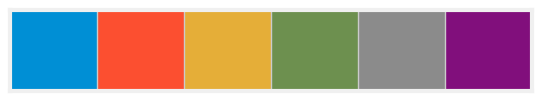

In [7]:
colors_538 = plt.rcParams['axes.prop_cycle'].by_key()['color']
palette_538 = sns.color_palette()

sns.palplot(palette_538)

Putting the the `matplotlib` verbosity at the `warning` level or above (_i.e._, `error` and `critical`):

In [8]:
plt.set_loglevel('WARNING')

### Memory Handling

The "safe" number of CPUs we can use:

In [9]:
import multiprocessing as mp

# number of cores in laptop, minus 2 (so we free one *physical* core)
safe_cpus = mp.cpu_count() - 2
print(safe_cpus)

18


Functions that find memory size of an object, and all references to it:

In [10]:
def get_object_size(obj):
    """
    Return the memory footprint of an object in bytes.

    If the object is a pandas DataFrame or Series, attempt to compute its deep memory usage; otherwise, fall back to using sys.getsizeof.

    Args:
        obj: The object whose memory size will be computed.

    Returns:
        int: The size of the object in bytes.
    """

    if isinstance(obj, pd.DataFrame) or isinstance(obj, pd.Series):
        try:
            return obj.memory_usage(deep=True).sum()
        except:
            return sys.getsizeof(obj)
    return sys.getsizeof(obj)

def find_named_references(obj, namespace=None):
    """
    Find variable names in a given namespace that reference a specific object.

    Args:
        obj: The object to search for.
        namespace (dict, optional): A mapping of variable names to objects.
            Defaults to the global namespace.

    Returns:
        list[str]: Names of variables that reference the given object.
    """

    if namespace is None:
        namespace = globals()
    return [name for name, val in namespace.items() if val is obj]

Examples of use:

In [11]:
# all_sizes = {}
# for name in dir():
#     all_sizes[name] = get_object_size(globals()[name])

# del name

In [12]:
# sorted(all_sizes, key=lambda k: all_sizes[k], reverse=True)

In [13]:
# sum(list(all_sizes.values()))/1024/1024

# del all_sizes

### Cleanup

In [14]:
Out.clear()

for name in dir():
    if name.startswith('_') and name[1:].isdigit():
        del globals()[name]

del name

## 1. Preamble

### Paths

In [15]:
nb_dir = "./" # notebooks directory
data_dir = "../data/" # data directory
input_data_dir = data_dir+"input/" # input data directory
output_data_dir = data_dir+"output/" # output data directory
models_dir = "../models/" # models directory

## 2. Investor Data

### Investors: Wealth

#### Importing Data

The Fed runs the SCF (Survey of Consumer Finances), which has household-level retirement account indicators, balances, income, age, etc. This is useful for us to realistically simulate the investors in ABC Investments.

**ASSUMPTIONS: (_i_) one investor per household, (_ii_) this sample is representative of ABC's cross section of investors.**

The data can be found [here](https://www.federalreserve.gov/econres/scfindex.htm?utm_source=chatgpt.com), in the table corresponding to the _"Summary Extract Public Data - Summary variables used in the Federal Reserve Report – all dollar variables inflation-adjusted to 2022 dollars"_.

First, we point to the SCF 2022 data:

In [16]:
scf_file = "SCFP2022.csv"

We now write the basic query that extracts the most important data:

In [17]:
table = input_data_dir+scf_file

test_query = \
f"""
SELECT YY1 AS id,
       AVG(AGE) AS age,
       AVG(INCOME) AS income,
       AVG(NETWORTH) AS net_worth,
       AVG(COALESCE(IRAKH,0)
        + COALESCE(THRIFT,0)
        + COALESCE(CURRPEN,0)
        + COALESCE(FUTPEN,0)
        + COALESCE(ANNUIT,0)
        + COALESCE(RETQLIQ,0)) AS retirement_balance,
       CAST(AVG(IF(MARRIED=1, 2, 1) + KIDS) AS INTEGER) AS family_size
       
       FROM '{table}'
       
       GROUP BY id

       ORDER BY id
"""

del table

Running the query, and saving the result:

In [18]:
# Run SQL directly on the CSV
result = duckdb.query(test_query).to_df()

result.to_csv(input_data_dir+"scf_simple.csv")

In [19]:
result.describe()

id          age        income     net_worth  \
count  4595.000000  4595.000000  4.595000e+03  4.595000e+03   
mean   2302.597171    54.468988  1.592855e+06  1.995640e+07   
std    1328.865275    16.190491  1.239287e+07  1.095628e+08   
min       1.000000    18.000000  0.000000e+00 -4.284440e+05   
25%    1152.500000    42.000000  4.215556e+04  3.738300e+04   
50%    2303.000000    56.000000  9.403933e+04  3.858600e+05   
75%    3453.500000    67.000000  2.648234e+05  2.514100e+06   
max    4603.000000    95.000000  4.478196e+08  2.249005e+09   

       retirement_balance  family_size  
count        4.595000e+03  4595.000000  
mean         1.203939e+06     2.370838  
std          6.397529e+06     1.296163  
min          0.000000e+00     1.000000  
25%          0.000000e+00     1.000000  
50%          4.192000e+04     2.000000  
75%          7.206000e+05     3.000000  
max          2.964000e+08    12.000000

Let us now write a function that determines whether a household is poor or not. We determine this based on the 2022 FPL (Federal Poverty Level) guidelines from the HHS (Department of Health & Human Services). See [here](https://www.mybenefitadvisor.com/articles/compliance/2022/q1/2022-federal-poverty-guidelines-announced/).

In [20]:
def is_poor(household_income: float, household_size: int) -> int:
    """
    Determine whether a household is below the 2022 federal poverty guideline for the 48 contiguous states and DC.

    For household sizes greater than 8, the threshold is increased by $4,720 for each additional member.

    Args:
        household_income (float): Annual household income in dollars.
        household_size (int): Number of people in the household.

    Returns:
        int: 1 if the household is at or below the poverty threshold, else 0.
    """

    # Base poverty levels for sizes 1 to 8 (2022, annual)
    base_guidelines = {
        1: 13_590,
        2: 18_310,
        3: 23_030,
        4: 27_750,
        5: 32_470,
        6: 37_190,
        7: 41_910,
        8: 46_630
    }

    if household_size <= 8:
        threshold = base_guidelines[household_size]
    else:
        threshold = base_guidelines[8] + (household_size - 8) * 4_720

    return 1 if household_income <= threshold else 0

We can now further refine the query to those people with some income ($> \$ 10^4$), net worth ($> \$0$), investments ($> \$100$), and above the FPL.

In [21]:
table = input_data_dir+"scf_simple.csv"

test_query = \
f"""
SELECT id,
       age,
       income,
       net_worth,
       retirement_balance
       
       FROM '{table}'

       WHERE (age >= 18) AND (income > 10000) AND (net_worth > 0) AND (retirement_balance > 100) AND (is_poor(income, family_size) <> 1)

       ORDER BY id
"""

del table

For the query to be read we need to connect to duckdb, and register our function:

In [22]:
con = duckdb.connect() # connecting to duckdb
con.create_function("is_poor", is_poor) # registering our function

We now run the query, and save the result:

In [23]:
result = con.execute(test_query).fetchdf()
result.to_csv(input_data_dir+"scf_investors.csv")

Closing the connection:

In [24]:
con.close()

Running the query and saving the result:

In [25]:
result.describe()

id          age        income     net_worth  \
count  2649.000000  2649.000000  2.649000e+03  2.649000e+03   
mean   2308.013968    56.162703  2.456939e+06  2.754305e+07   
std    1329.235876    14.976377  1.596748e+07  1.247442e+08   
min       1.000000    18.000000  1.405185e+04  2.520000e+02   
25%    1164.000000    45.000000  9.122896e+04  3.414580e+05   
50%    2304.000000    57.000000  1.837550e+05  1.224220e+06   
75%    3468.000000    67.000000  5.575343e+05  6.672600e+06   
max    4602.000000    95.000000  4.478196e+08  2.249005e+09   

       retirement_balance  
count        2.649000e+03  
mean         2.065980e+06  
std          8.315406e+06  
min          1.040000e+02  
25%          1.000000e+05  
50%          4.896000e+05  
75%          1.943200e+06  
max          2.964000e+08

We now ``logify'' the data:

In [26]:
log_result = pd.DataFrame()

log_result['age'] = result['age']
log_result['log10_income'] = np.log10(result['income'])
log_result['log10_net_worth'] = np.log10(result['net_worth'])
log_result['log10_retirement_balance'] = np.log10(result['retirement_balance'])

display(log_result)

age  log10_income  log10_net_worth  log10_retirement_balance
0     70.0      4.561678         5.803020                  5.422261
1     46.0      5.351854         5.859006                  5.301030
2     68.0      5.667057         7.638642                  5.990516
3     74.0      5.169241         6.324817                  6.477411
4     74.0      5.436636         6.837477                  6.275173
...    ...           ...              ...                       ...
2644  63.0      5.962596         7.335667                  6.301898
2645  69.0      5.421180         6.351100                  6.447158
2646  55.0      6.273840         6.825569                  6.590262
2647  50.0      5.195158         5.859709                  6.046261
2648  56.0      4.823371         5.349180                  5.033424

[2649 rows x 4 columns]

Let us look at joint plots:

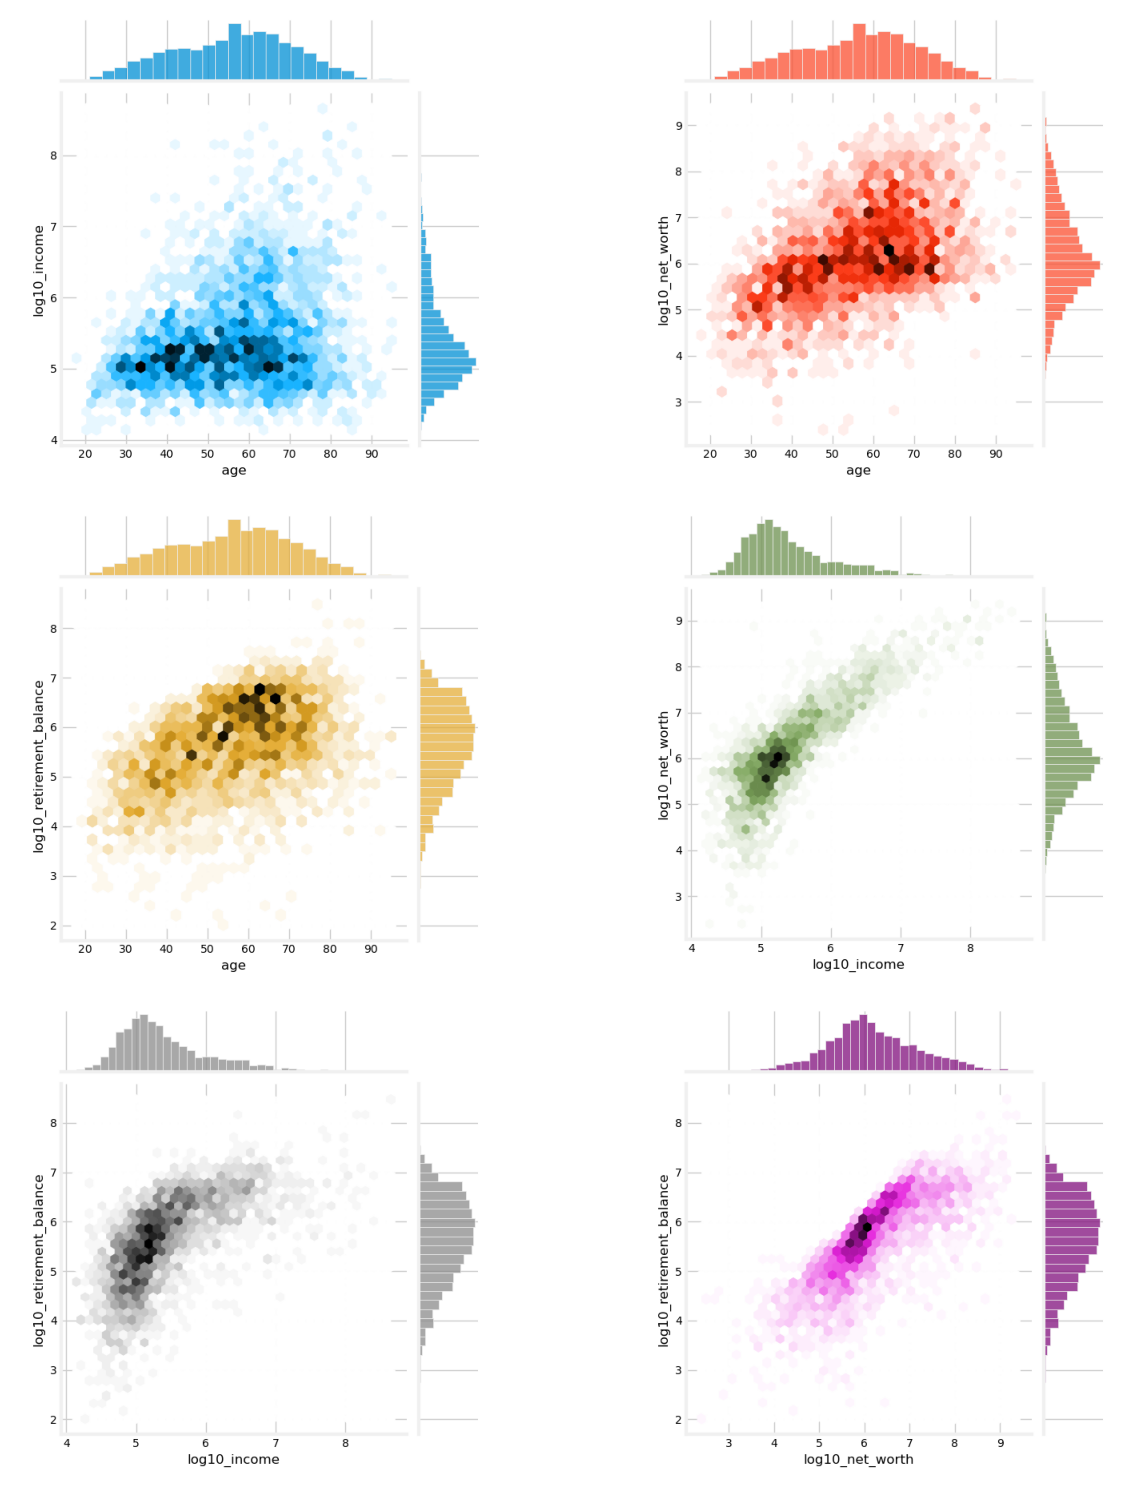

In [27]:
cols = log_result.columns.to_list()
combinations = list(itertools.combinations(cols, 2))
n = len(combinations)

# Compute grid size (square-ish)
rows = int(np.ceil(n/2))
# fig, axes = plt.subplots(rows, 2, figsize=(12, rows*5))

# Flatten axes for easy indexing
# axes = axes.flatten()

imgs = []
for i, (x, y) in enumerate(combinations):
    # Create jointplot for each pair
    jp = sns.jointplot(data=log_result, x=x, y=y, kind='hex', color=sns.color_palette(palette_538)[i]);
    # Move jointplot figure into our axes grid
    # g.fig.set_size_inches(6, 5);

    buf = BytesIO()
    jp.fig.savefig(buf, format="png")
    plt.close(jp.fig)
    buf.seek(0)
    img = Image.open(buf)
    imgs.append(img)

fig, axs = plt.subplots(rows, 2, figsize=(15, 15))

for k, img in enumerate(imgs):
    
    i = k // 2 # row
    j = k % 2 # column

    axs[i,j].imshow(img)
    axs[i,j].axis('off')

plt.tight_layout()
plt.show()

del cols, combinations, n, rows, fig, axs, k, img, jp, i, x, y

We will excise the most extreme values:

In [28]:
def remove_extremes(df, lower_q=0.01, upper_q=0.99):
    """
    Remove rows where any numeric column is outside the specified percentile bounds.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe containing numeric columns to check.
    lower_q : float, optional
        Lower percentile threshold (default is 0.01).
    upper_q : float, optional
        Upper percentile threshold (default is 0.99).

    Returns
    -------
    pd.DataFrame
        A copy of the dataframe with rows containing extreme values excised.
    """

    numeric_cols = df.select_dtypes(include=[np.number]).columns
    mask = np.ones(len(df), dtype=bool)  # start with all True

    for col in numeric_cols:
        
        if col == 'age':
            continue
        
        lower = df[col].quantile(lower_q)
        upper = df[col].quantile(upper_q)
        mask &= df[col].between(lower, upper)  # keep only values within bounds

    return df.loc[mask].copy()  # excise rows with extremes

In [29]:
log_result = remove_extremes(log_result, lower_q=0.01, upper_q=0.99)

display(log_result)

age  log10_income  log10_net_worth  log10_retirement_balance
0     70.0      4.561678         5.803020                  5.422261
1     46.0      5.351854         5.859006                  5.301030
2     68.0      5.667057         7.638642                  5.990516
3     74.0      5.169241         6.324817                  6.477411
4     74.0      5.436636         6.837477                  6.275173
...    ...           ...              ...                       ...
2644  63.0      5.962596         7.335667                  6.301898
2645  69.0      5.421180         6.351100                  6.447158
2646  55.0      6.273840         6.825569                  6.590262
2647  50.0      5.195158         5.859709                  6.046261
2648  56.0      4.823371         5.349180                  5.033424

[2521 rows x 4 columns]

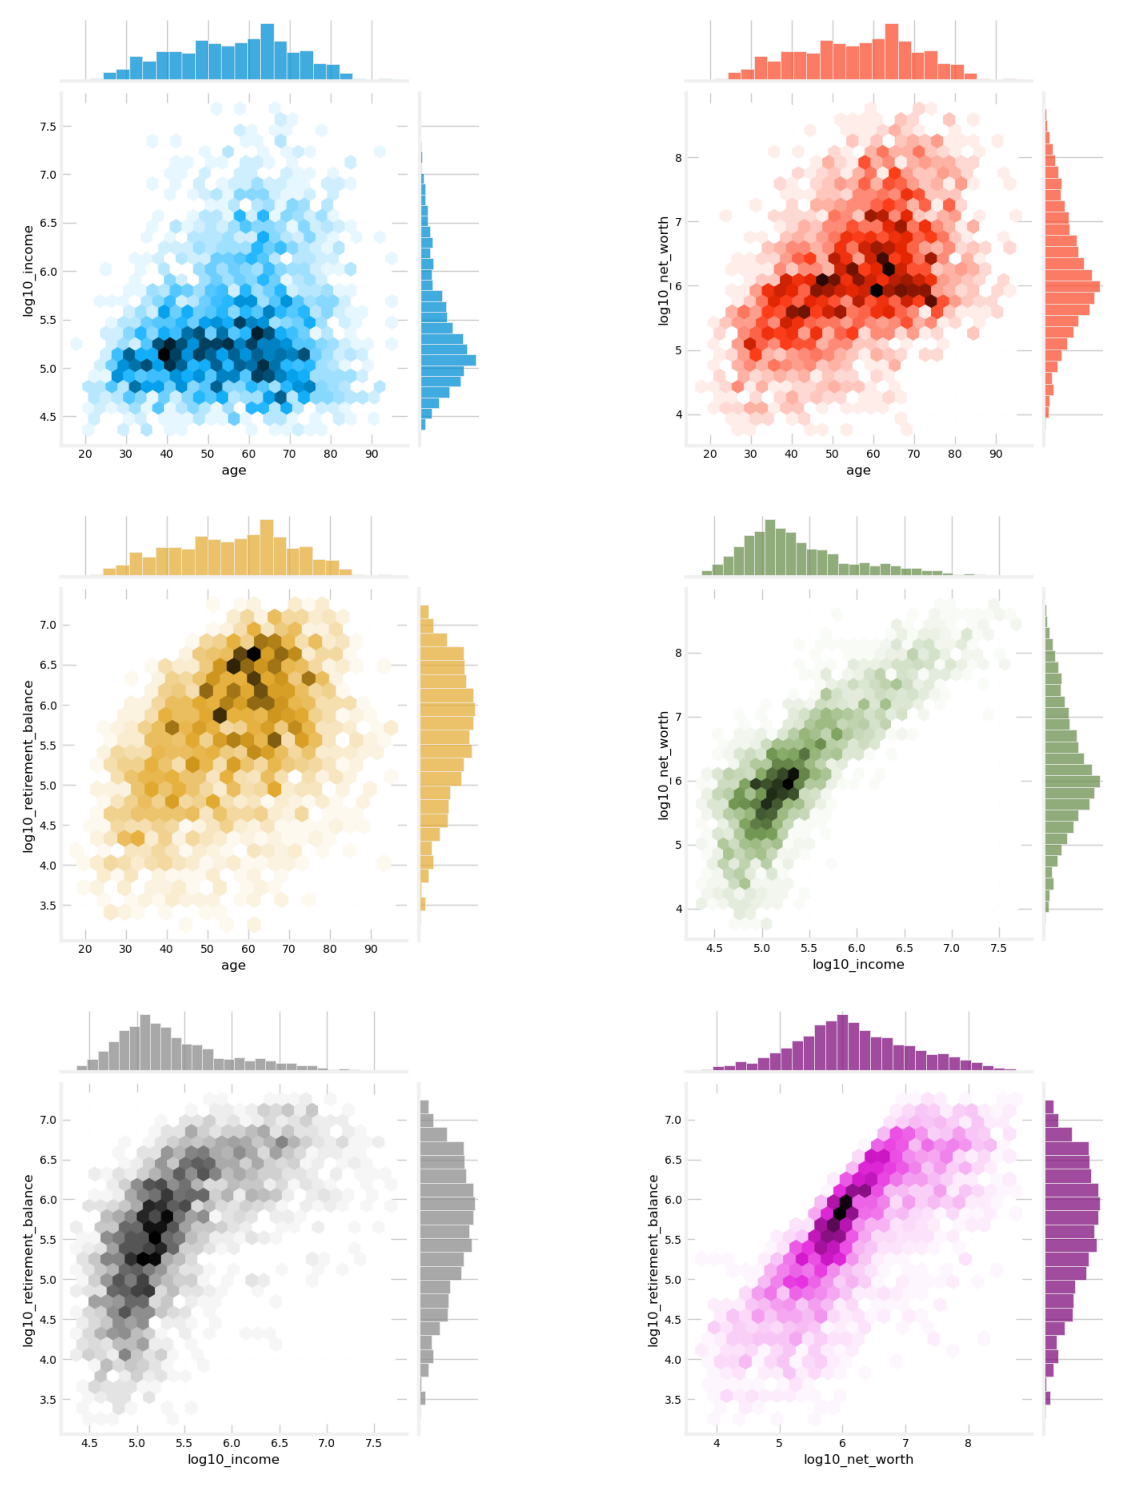

In [30]:
cols = log_result.columns.to_list()
combinations = list(itertools.combinations(cols, 2))
n = len(combinations)

# Compute grid size (square-ish)
rows = int(np.ceil(n/2))
# fig, axes = plt.subplots(rows, 2, figsize=(12, rows*5))

# Flatten axes for easy indexing
# axes = axes.flatten()

imgs = []
for i, (x, y) in enumerate(combinations):
    # Create jointplot for each pair
    jp = sns.jointplot(data=log_result, x=x, y=y, kind='hex', color=sns.color_palette(palette_538)[i]);
    # Move jointplot figure into our axes grid
    # g.fig.set_size_inches(6, 5);

    buf = BytesIO()
    jp.fig.savefig(buf, format="png")
    plt.close(jp.fig)
    buf.seek(0)
    img = Image.open(buf)
    imgs.append(img)

fig, axs = plt.subplots(rows, 2, figsize=(15, 15))

for k, img in enumerate(imgs):
    
    i = k // 2 # row
    j = k % 2 # column

    axs[i,j].imshow(img)
    axs[i,j].axis('off')

plt.tight_layout()
plt.show()

del cols, combinations, n, rows, fig, axs, k, img, jp, i, x, y

#### Generating Synthetic Data

From these distributions, how do we generate our mock investor pupulation? We can use Gaussian Multivariate copulas, which will capture the correlations and non-linear nature of the data, or more sophisticated CTGANs (Conditional Tabular Generative Adversarial Networks).

##### Gaussian Multivariate Copulas

Importing:

In [31]:
# from sklearn.preprocessing import PowerTransformer

# from copulas.multivariate import GaussianMultivariate, VineCopula

# # univariate classes I might use:
# from copulas.univariate.gaussian_kde import GaussianKDE
# from copulas.univariate.student_t import StudentTUnivariate
# from copulas.univariate.truncated_gaussian import TruncatedGaussian
# from copulas.univariate.gamma import GammaUnivariate

# # from copulas.visualization import scatter_3d, compare_3d

Transforming the data:

In [32]:
# transformer = PowerTransformer(method='yeo-johnson')

# Xtrans = log_result.copy()
# cols = Xtrans.columns.to_list()
# Xtrans[cols] = transformer.fit_transform(Xtrans[cols])

Checking distribution:

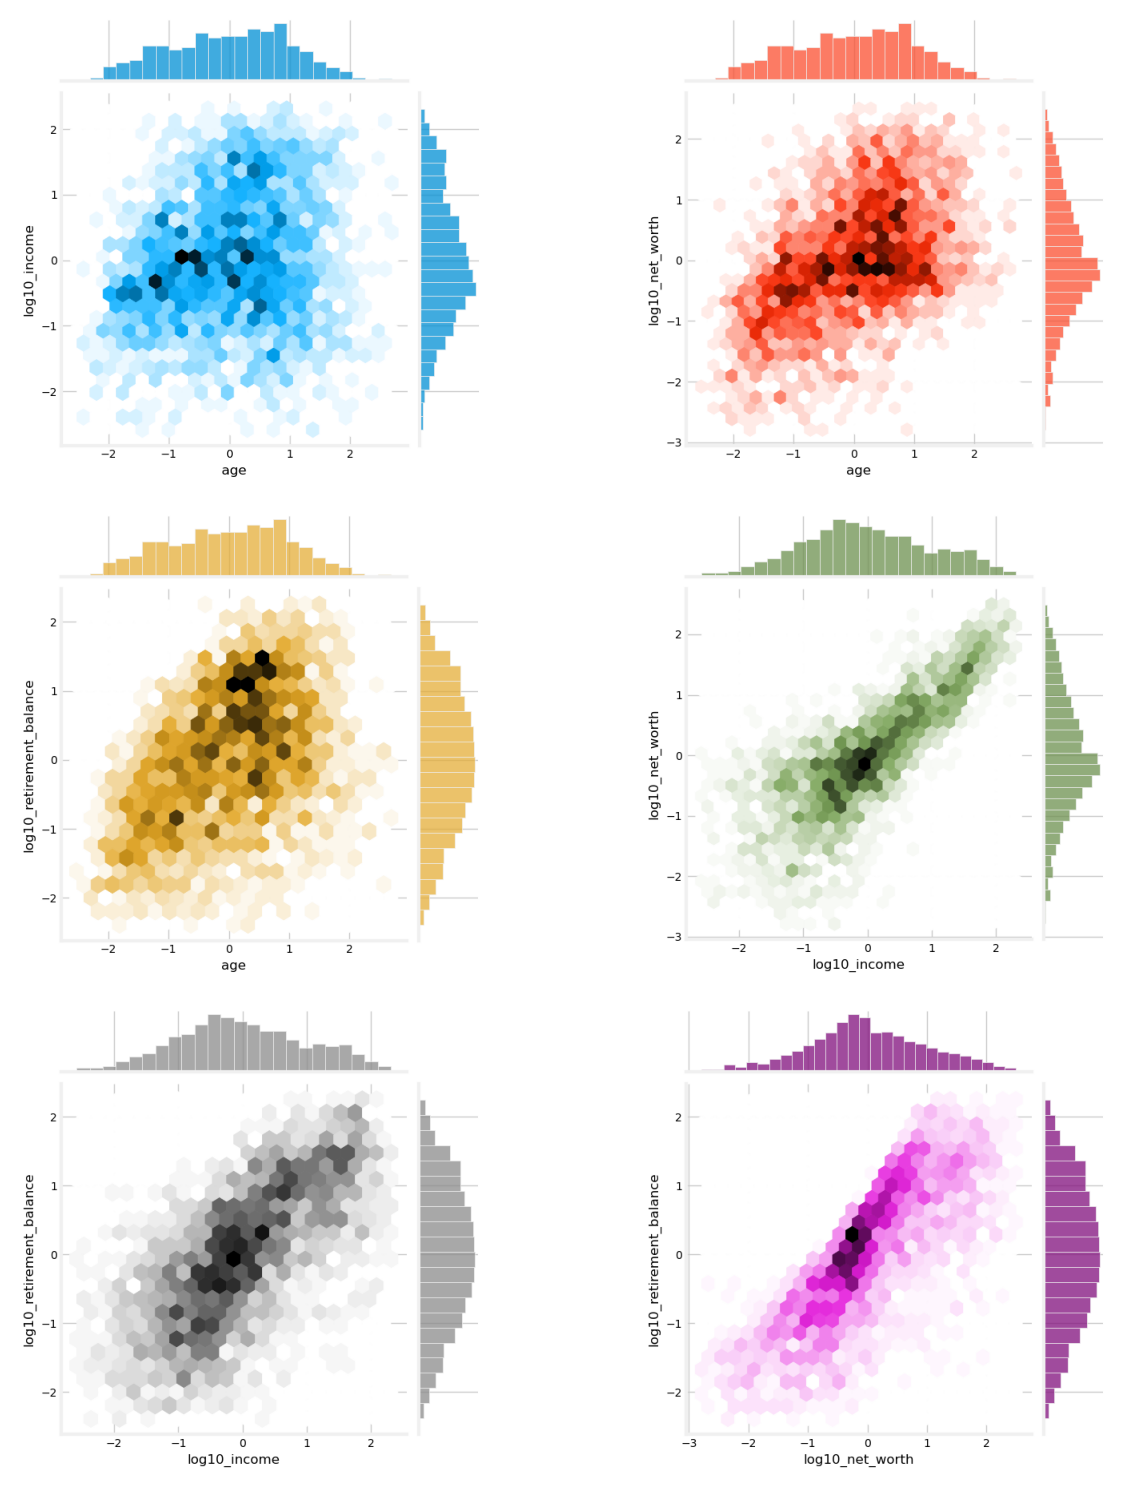

In [33]:
# combinations = list(itertools.combinations(cols, 2))
# n = len(combinations)

# # Compute grid size (square-ish)
# rows = int(np.ceil(n/2))
# # fig, axes = plt.subplots(rows, 2, figsize=(12, rows*5))

# # Flatten axes for easy indexing
# # axes = axes.flatten()

# imgs = []
# for i, (x, y) in enumerate(combinations):
#     # Create jointplot for each pair
#     jp = sns.jointplot(data=Xtrans, x=x, y=y, kind='hex', color=sns.color_palette(palette_538)[i]);
#     # Move jointplot figure into our axes grid
#     # g.fig.set_size_inches(6, 5);

#     buf = BytesIO()
#     jp.fig.savefig(buf, format="png")
#     plt.close(jp.fig)
#     buf.seek(0)
#     img = Image.open(buf)
#     imgs.append(img)

# fig, axs = plt.subplots(rows, 2, figsize=(15, 15))

# for k, img in enumerate(imgs):
    
#     i = k // 2 # row
#     j = k % 2 # column

#     axs[i,j].imshow(img)
#     axs[i,j].axis('off')

# plt.tight_layout()
# plt.show()

# del combinations, n, rows, fig, axs, k, img, jp, i, x, y

Fitting the model:

In [34]:
# # 1) Choose per-column univariate models
# distribution = {"age":GaussianKDE,
#                 "log10_income":GaussianKDE,
#                 "log10_net_worth":GaussianKDE,
#                 "log10_retirement_balance":GaussianKDE}

# # 2) Build GaussianMultivariate with explicit distribution map
# copula_model = GaussianMultivariate(distribution=distribution,
#                                     random_state=1)

# # 3) Fit to data
# copula_model.fit(Xtrans)

We can then generate our synthetic data...

In [36]:
# copula_model.set_random_state(0) # fix global RNG
# synth_data = copula_model.sample(num_rows=175_000)

... transform back...

In [37]:
# synth_data[cols] = transformer.inverse_transform(synth_data[cols])

... clip extremes again...

In [38]:
# synth_data = remove_extremes(synth_data)

... limit to 100,000...

In [39]:
# synth_data = synth_data.sample(n=100_000)

... reindex...

In [43]:
# synth_data.reset_index(drop=True, inplace=True)
# display(synth_data)

age  log10_income  log10_net_worth  log10_retirement_balance
0      83.117431      5.372373         6.903029                  6.296701
1      60.998169      5.516026         6.481488                  5.769385
2      61.260696      6.369193         7.938620                  6.481226
3      59.790852      6.764428         7.833539                  6.312154
4      59.981025      6.325588         6.279930                  5.675320
...          ...           ...              ...                       ...
99995  47.424480      5.756427         6.683537                  6.736509
99996  58.010022      6.052392         7.034091                  6.324063
99997  45.240766      5.381335         6.341721                  6.000331
99998  71.982608      5.533808         6.234119                  6.445209
99999  74.327107      5.038841         6.188764                  5.819271

[100000 rows x 4 columns]

... and save:

In [44]:
# synth_data.to_csv(input_data_dir+"synth_copula_investors.csv")

If the cells above are commented out, that means that we have already generated it, and we can just import it:

In [45]:
synth_data = pd.read_csv(input_data_dir+"synth_copula_investors.csv", index_col=0)

display(synth_data)

age  log10_income  log10_net_worth  log10_retirement_balance
0      83.117431      5.372373         6.903029                  6.296701
1      60.998169      5.516026         6.481488                  5.769385
2      61.260696      6.369193         7.938620                  6.481226
3      59.790852      6.764428         7.833539                  6.312154
4      59.981025      6.325588         6.279930                  5.675320
...          ...           ...              ...                       ...
99995  47.424480      5.756427         6.683537                  6.736509
99996  58.010022      6.052392         7.034091                  6.324063
99997  45.240766      5.381335         6.341721                  6.000331
99998  71.982608      5.533808         6.234119                  6.445209
99999  74.327107      5.038841         6.188764                  5.819271

[100000 rows x 4 columns]

Let us look at the plots:

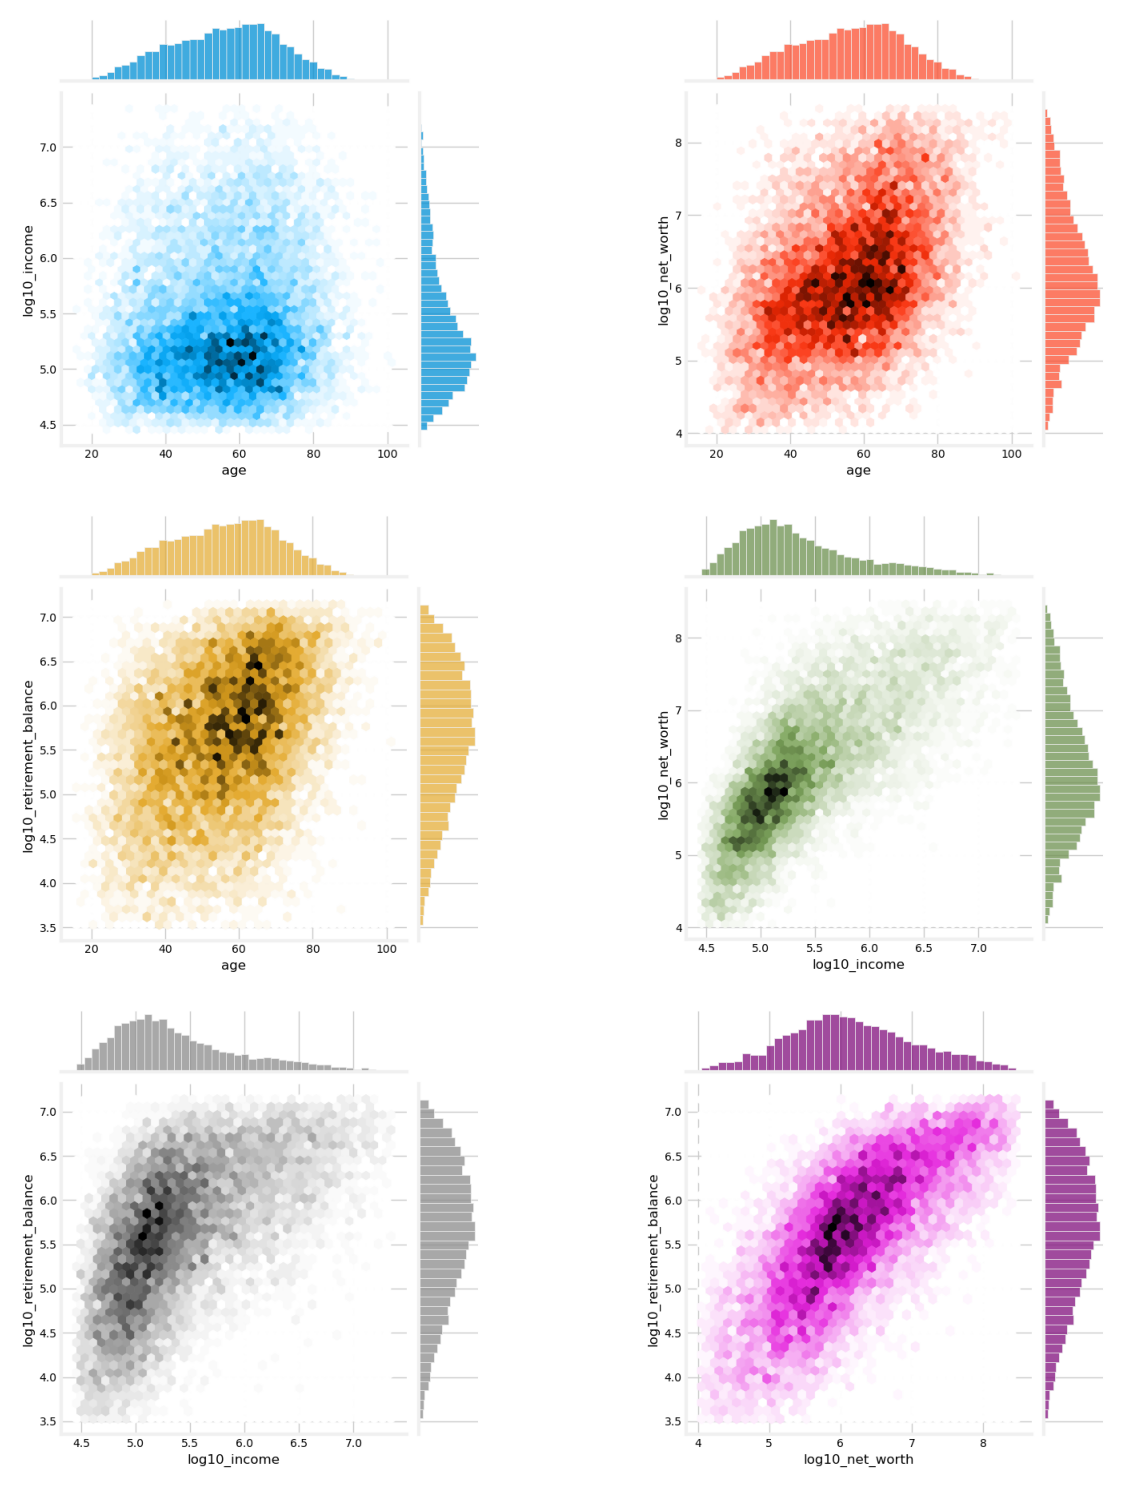

In [46]:
sample_data = synth_data.sample(frac=0.1)

cols = sample_data.columns.to_list()
combinations = list(itertools.combinations(cols, 2))
n = len(combinations)

# Compute grid size (square-ish)
rows = int(np.ceil(n/2))
# fig, axes = plt.subplots(rows, 2, figsize=(12, rows*5))

# Flatten axes for easy indexing
# axes = axes.flatten()

imgs = []
for i, (x, y) in enumerate(combinations):
    # Create jointplot for each pair
    jp = sns.jointplot(data=sample_data, x=x, y=y, kind='hex', color=sns.color_palette(palette_538)[i]);
    # Move jointplot figure into our axes grid
    # g.fig.set_size_inches(6, 5);

    buf = BytesIO()
    jp.fig.savefig(buf, format="png")
    plt.close(jp.fig)
    buf.seek(0)
    img = Image.open(buf)
    imgs.append(img)

fig, axs = plt.subplots(rows, 2, figsize=(15, 15))

for k, img in enumerate(imgs):
    
    i = k // 2 # row
    j = k % 2 # column

    axs[i,j].imshow(img)
    axs[i,j].axis('off')

plt.tight_layout()
plt.show()

del sample_data, combinations, n, rows, fig, axs, k, img, jp, i, x, y

In [47]:
del transformer, Xtrans, cols

##### CTGANs

Let us now try CTGANs.

In [48]:
# ?CTGANSynth

Detecting the metadata from our data:

In [49]:
# from sdv.metadata import Metadata

# metadata = Metadata.detect_from_dataframe(
#     data=log_result,
#     table_name='log_investors')

Training the CTGAN:

In [50]:
# from sdv.single_table import CTGANSynthesizer as CTGANSynth

# ctgan_model = CTGANSynth(metadata)
# ctgan_model.fit(log_result)

Generating and saving the synthetic data:

In [51]:
# synth_data = ctgan_model.sample(num_rows=100_000)
# synth_data.to_csv(input_data_dir+"synth_ctgan_investors.csv")

If the above cells are commented out, it means we have already synthetized the data, and therefore all we have to do is import it now:

In [52]:
synth_data = pd.read_csv(input_data_dir+"synth_ctgan_investors.csv", index_col=0)

display(synth_data)

age  log10_income  log10_net_worth  log10_retirement_balance
0      40.0      5.487021         6.281669                  6.319853
1      60.0      4.796932         4.534968                  6.112072
2      69.0      5.708108         6.640638                  7.195894
3      51.0      4.857052         7.431366                  6.581899
4      84.0      4.968282         4.438058                  4.603325
...     ...           ...              ...                       ...
49995  82.0      5.245562         7.853558                  6.109578
49996  70.0      4.855796         8.657961                  5.215414
49997  68.0      5.805733         2.490211                  5.180893
49998  52.0      4.817345         6.634175                  5.060597
49999  67.0      4.801772         5.609567                  6.347079

[50000 rows x 4 columns]

Joint plots:

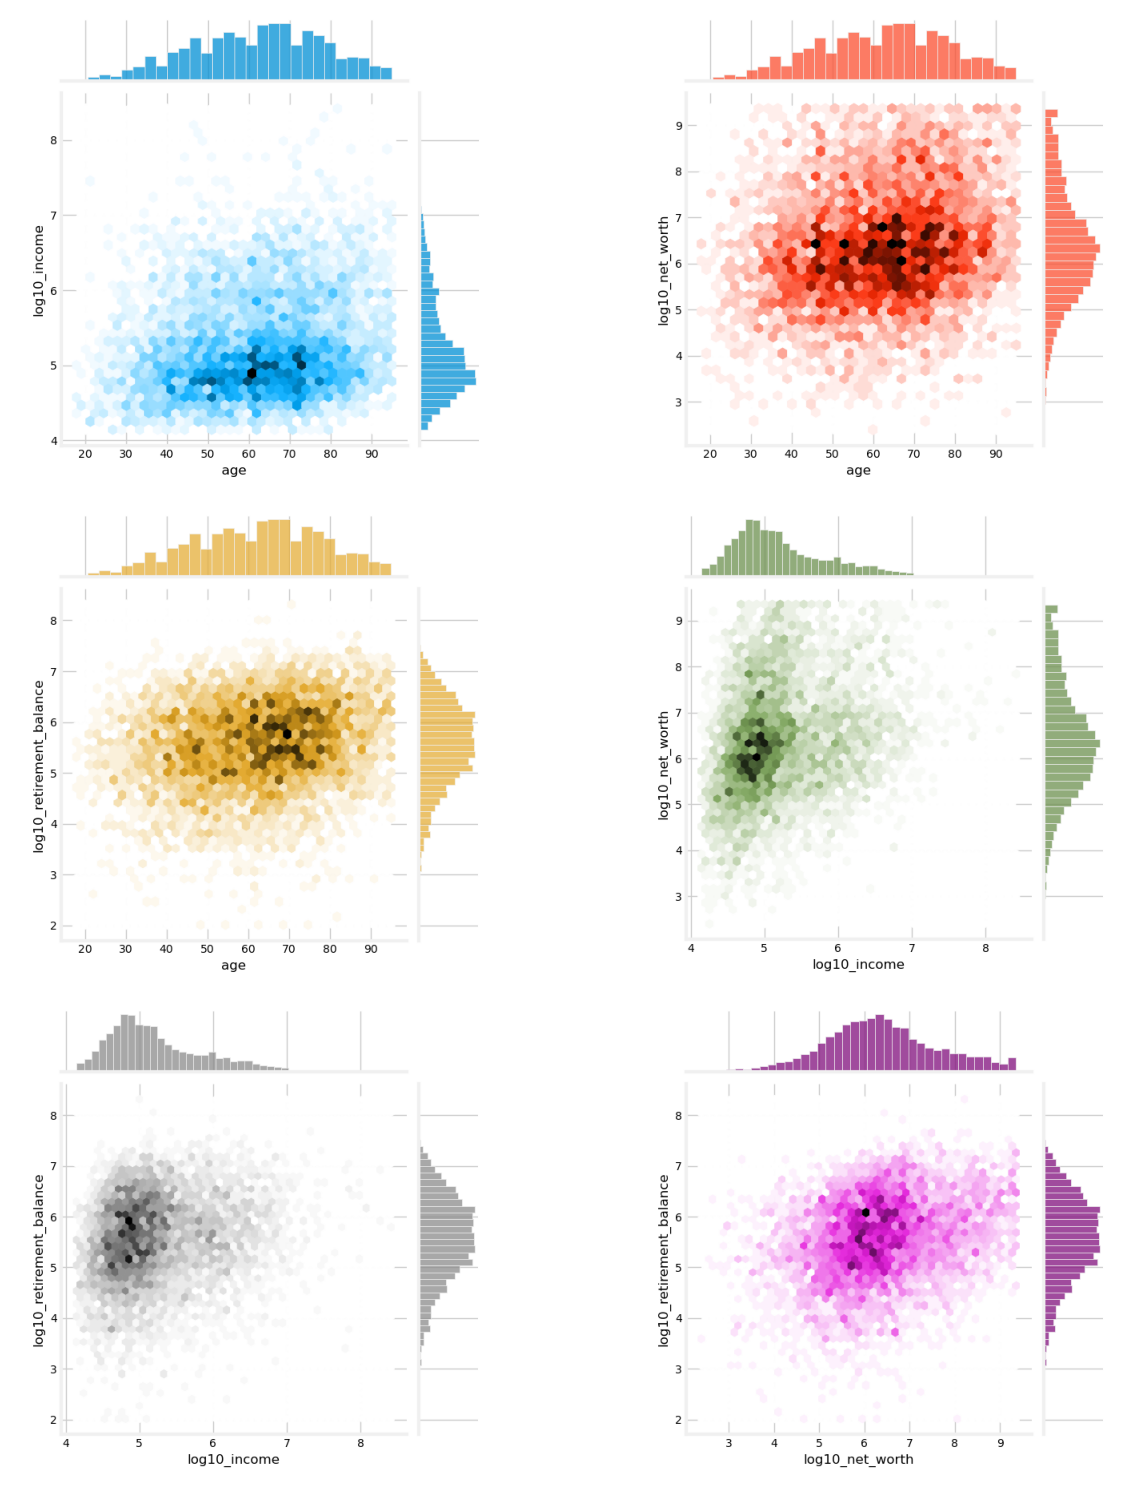

In [53]:
sample_data = synth_data.sample(frac=0.1)

cols = sample_data.columns.to_list()
combinations = list(itertools.combinations(cols, 2))
n = len(combinations)

# Compute grid size (square-ish)
rows = int(np.ceil(n/2))
# fig, axes = plt.subplots(rows, 2, figsize=(12, rows*5))

# Flatten axes for easy indexing
# axes = axes.flatten()

imgs = []
for i, (x, y) in enumerate(combinations):
    # Create jointplot for each pair
    jp = sns.jointplot(data=sample_data, x=x, y=y, kind='hex', color=sns.color_palette(palette_538)[i]);
    # Move jointplot figure into our axes grid
    # g.fig.set_size_inches(6, 5);

    buf = BytesIO()
    jp.fig.savefig(buf, format="png")
    plt.close(jp.fig)
    buf.seek(0)
    img = Image.open(buf)
    imgs.append(img)

fig, axs = plt.subplots(rows, 2, figsize=(15, 15))

for k, img in enumerate(imgs):
    
    i = k // 2 # row
    j = k % 2 # column

    axs[i,j].imshow(img)
    axs[i,j].axis('off')

plt.tight_layout()
plt.show()

del sample_data, cols, combinations, n, rows, fig, axs, k, img, jp, i, x, y

Yikes, that is not as good. Since this is just a toy project, I will not try to improve upon the CTGAN, and simply use the copulas instead.

#### Clean

In [54]:
Out.clear()

for name in dir():
    if name.startswith('_') and name[1:].isdigit():
        del globals()[name]

del name, result

### Investors: Contributions

Let us now consider how the investors contribute to their account, as a percentage of their income.

We simulate the contributions $r$ as a random sample from a beta distribution:

$r \sim 0.2 \times \mathrm{Beta}(\alpha, \beta) = 0.2 \times \frac{x^{\alpha-1}(1-x)^{\beta-1}}{\mathrm{B}(\alpha, \beta)}$,

where we have multiplied by $0.2$ to reflect that people, at most, will contribute $20\%$ of their income.

We shall pick some arbitrary numbers, $\alpha = 3$ and $\beta = 4.7$, which result in a right-skewed distribution, with mostly small percentages, but with a mode around $7\%$ (once we rescale by $0.2$), which is where most US 401(k) contributions are.

In [55]:
# rng = np.random.default_rng(seed=42)  # create a reproducible generator
# pcts = np.round(rng.beta(a=3, b=4.7, size=100_000)*0.2 * 100 * 4)/4 # rounds to the nearest 0.025

# pcts = pd.DataFrame(pcts, columns=['current_pct'])

Let us now compute the employee contributions. We will use a simple $100\%$ match up to $x\%$, where x is going to be a random draw from the same distribution.

In [56]:
# rng = np.random.default_rng(seed=10)
# cap = np.round(rng.beta(a=3, b=4.7, size=100_000)*0.2 * 100 * 4)/4

Computing matches:

In [57]:
# pcts['employer_cap'] = cap

# pcts.to_csv(input_data_dir+"synth_contributions.csv")

# del cap

If the above cells are commented out, it means we have already generated this data, so we just import it.

In [58]:
pcts = pd.read_csv(input_data_dir+"synth_contributions.csv", index_col=0)
display(pcts)

current_pct  employer_cap
0             6.75          6.00
1             8.00          5.25
2             9.75         10.75
3             8.00          9.00
4            10.50          9.00
...            ...           ...
99995        13.00          8.00
99996         7.25          1.75
99997        14.50          4.75
99998         9.75          5.50
99999         8.75          5.50

[100000 rows x 2 columns]

<Axes: ylabel='Count'>

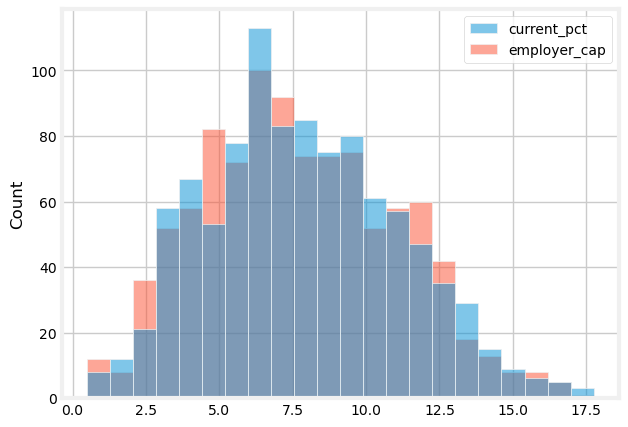

In [59]:
sns.histplot(pcts.sample(frac=0.01, random_state=10))

In [60]:
del pcts

### Investors: Engagement & Activity

We now focus on how do the investors engage with ABC's Investments' ecosystem. We will focus on covariates such as last_login, login_frequency, email_check_frequency, and such.

#### Last login

We begin by modeling the last time the users logged in to ABC's Investments platform. We assume that they log in roughly once a month (30 days) or so, and that this is roughly uniform across all kinds of users.

In [61]:
# rng = np.random.default_rng(seed=1)
# logindays = np.round(rng.exponential(scale=30, size=100_000), 1)

# logindays = pd.DataFrame(logindays, columns=['last_login'])
# logindays.to_csv(input_data_dir+"synth_last_login.csv")

In [62]:
logindays = pd.read_csv(input_data_dir+"synth_last_login.csv", index_col=0)
display(logindays)

last_login
0            32.2
1             9.3
2           161.3
3            11.0
4             3.5
...           ...
99995         5.4
99996        30.0
99997         0.1
99998        21.1
99999        20.1

[100000 rows x 1 columns]

<Axes: ylabel='Count'>

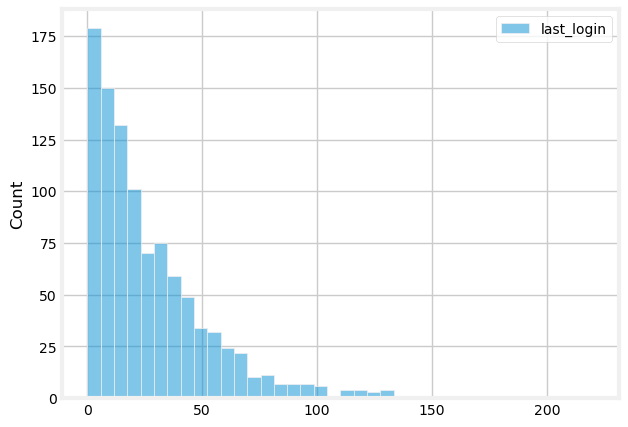

In [63]:
sns.histplot(logindays.sample(frac=0.01))

#### Account Tenure

Let us now model the account tenure. We will do this by capping, at the lower end, from last_login, and at the upper end, by min(age_of_ABC_investments, age_of_user - 18). We will simulate the distribution as an exponential.

In [64]:
from scipy.stats import truncexpon

In [65]:
abc_age = 50 # 50 years!

def tenure_fn(age, lastlogin, scale=5, random_state=1):
    """
    Simulate retirement account tenure using a truncated exponential distribution.

    The lower bound is derived from the last login date (converted to years), while the upper bound is capped by the minimum of the user's age minus 18 and the maximum allowed age of ABC investments.

    Args:
        age (array-like or float): User age(s) in years.
        lastlogin (array-like, float, or pandas object): Days since last login, converted internally to years.
        scale (float, optional): Scale parameter for the exponential distribution.
            Defaults to 5.
        random_state (int, optional): Random seed for reproducibility.
            Defaults to 1.

    Returns:
        float or ndarray: Simulated tenure(s) in years.
    """

    try:
        n = len(age)
    except TypeError:
        n = 1

    lower_end = (lastlogin/365) # convert days into years
    upper_end = np.minimum(np.max(age-18., 0), abc_age)

    if isinstance(lower_end, pd.DataFrame):
        lower_end = lower_end.squeeze().to_numpy()
    elif isinstance(lower_end, pd.Series):
        lower_end = lower_end.to_numpy()
    
    if isinstance(upper_end, pd.DataFrame):
        upper_end = upper_end.squeeze().to_numpy()
    elif isinstance(upper_end, pd.Series):
        upper_end = upper_end.to_numpy()

    tenure_arr = truncexpon.rvs(b=upper_end, loc=lower_end, scale=scale, random_state=random_state)

    if np.isscalar(tenure_arr):
        return float(tenure_arr)
    else:
        return tenure_arr

In [66]:
print(tenure_fn(60, 1))
print(tenure_fn(synth_data['age'], logindays))

2.7007689123233245
[2.78624836 6.39610572 0.44248972 ... 8.52027631 4.25276213 4.80246341]


<Axes: ylabel='Count'>

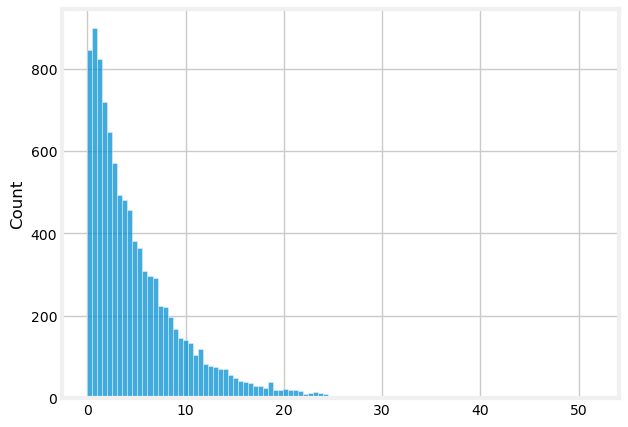

In [67]:
sns.histplot(pd.Series(tenure_fn(synth_data['age'], logindays)).sample(frac=0.1))

#### Time online (_e.g._ in email inbox)

Let us now model how much time each user spends in their email inbox.

I don't have data, but I have some anecdotal experience. Younger generations spend more time online than the older ones, and according to some cursory Google searches (from an Adobe survey cited [here](https://www.cnbc.com/2018/08/22/millennials-spend-more-time-on-their-email-than-any-other-generation.html), but that I have been unable to find), we are talking about 6.5 hrs for millenials (25 -- 24 y.o.), while 5 hrs for older people (> 35 y.o.).

Let us further assume, for simplicity, that this same time is time both on a PC and on their phones.

So let us take the mean of the ages in question (assuming the upper end of the larger age group is 65 y.o.), the fraction of hours in the day spent in the email inbox/on their phones, and draw a line through it.

In particular, if we have the data `[[x_1, y_1], [x_2, y_2]]`, then the formula for the line is simply:

$y(x) = m x + b$,

where $m = \frac{y_2 - y_1}{x_2 - x_1}$ and $b = \frac{x_2 y_1 - x_1 y_2}{x_2 - x_1}$.

In [68]:
# the data
age_time_data = np.array([[(25+34)/2, 6.5/24], [(65+35)/2, 5./24]])

# the function
def inbox_time_fn(age, data=age_time_data, noise=False, noise_sigma=(0.5/24), random_state=1):
    """
    Estimate time spent in the email inbox based on age using a linear interpolation.

    Optionally, add Gaussian noise to the estimate.

    Args:
        age (array-like or float): User age(s) in years.
        data (ndarray, optional): 2D array with age in column 0 and average email time in column 1. Defaults to `age_time_data`.
        noise (bool, optional): Whether to add Gaussian noise. Defaults to False.
        noise_sigma (float, optional): Standard deviation of noise in days.
            Defaults to 0.5/24 (half an hour). 
        random_state (int, optional): Seed for random number generation. Defaults to 1.

    Returns:
        ndarray or float: Estimated email time(s), rounded to 3 decimal places.
    """

    age_data = data[:,0]
    time_data = data[:,1]

    slope = float((time_data[-1] - time_data[0])/(age_data[-1] - age_data[0]))

    intercept = float((age_data[-1]*time_data[0] - age_data[0]*time_data[-1])/(age_data[-1] - age_data[0]))

    email_time = slope*age + intercept

    if noise:
        rng = np.random.default_rng(seed=random_state)
        noise_arr = rng.normal(loc=0., scale=noise_sigma, size=len(email_time))
        email_time += noise_arr

    return np.round(email_time, 3)

Let us now plot the results:

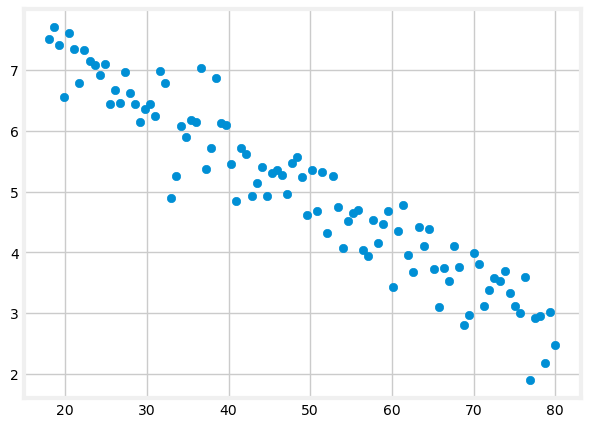

In [69]:
age_arr = np.linspace(18, 80, 101)
time_arr = inbox_time_fn(age_arr, noise=True)

plt.scatter(age_arr, time_arr*24)

del age_arr, time_arr

### Investors: Final Data

#### Concatenating Data

We have almost all that we need to construct our synthetic data.

We begin by importing all the data we have:

In [70]:
inv_data = pd.read_csv(input_data_dir+"synth_copula_investors.csv", index_col=0) # investor data

pct_data = pd.read_csv(input_data_dir+"synth_contributions.csv", index_col=0) # contributions

login_data = pd.read_csv(input_data_dir+"synth_last_login.csv", index_col=0)

Let us generate a random user ID:

In [71]:
unique_ids = np.random.choice(
    np.arange(100_000, 1_000_000),  # all possible 6-digit numbers
    size=len(inv_data),             # how many you want
    replace=False                   # no duplicates
)

final_data = inv_data.copy()
final_data.insert(0, 'user_id', pd.Series(unique_ids))

display(final_data)

user_id        age  log10_income  log10_net_worth  \
0       132549  83.117431      5.372373         6.903029   
1       725619  60.998169      5.516026         6.481488   
2       315630  61.260696      6.369193         7.938620   
3       376800  59.790852      6.764428         7.833539   
4       683596  59.981025      6.325588         6.279930   
...        ...        ...           ...              ...   
99995   523997  47.424480      5.756427         6.683537   
99996   598830  58.010022      6.052392         7.034091   
99997   146035  45.240766      5.381335         6.341721   
99998   450168  71.982608      5.533808         6.234119   
99999   451290  74.327107      5.038841         6.188764   

       log10_retirement_balance  
0                      6.296701  
1                      5.769385  
2                      6.481226  
3                      6.312154  
4                      5.675320  
...                         ...  
99995                  6.736509  
99996                  6.324063  
99997                  6.000331  
99998                  6.445209  
99999                  5.819271  

[100000 rows x 5 columns]

Concatenate to it the contributions data and the login data:

In [72]:
final_data = pd.concat([final_data, pct_data, login_data], axis=1)

display(final_data)

user_id        age  log10_income  log10_net_worth  \
0       132549  83.117431      5.372373         6.903029   
1       725619  60.998169      5.516026         6.481488   
2       315630  61.260696      6.369193         7.938620   
3       376800  59.790852      6.764428         7.833539   
4       683596  59.981025      6.325588         6.279930   
...        ...        ...           ...              ...   
99995   523997  47.424480      5.756427         6.683537   
99996   598830  58.010022      6.052392         7.034091   
99997   146035  45.240766      5.381335         6.341721   
99998   450168  71.982608      5.533808         6.234119   
99999   451290  74.327107      5.038841         6.188764   

       log10_retirement_balance  current_pct  employer_cap  last_login  
0                      6.296701         6.75          6.00        32.2  
1                      5.769385         8.00          5.25         9.3  
2                      6.481226         9.75         10.75       161.3  
3                      6.312154         8.00          9.00        11.0  
4                      5.675320        10.50          9.00         3.5  
...                         ...          ...           ...         ...  
99995                  6.736509        13.00          8.00         5.4  
99996                  6.324063         7.25          1.75        30.0  
99997                  6.000331        14.50          4.75         0.1  
99998                  6.445209         9.75          5.50        21.1  
99999                  5.819271         8.75          5.50        20.1  

[100000 rows x 8 columns]

Now, we generate the account tenure...

In [73]:
final_data['acct_tenure'] = pd.Series(tenure_fn(final_data['age'],
                                                final_data['last_login'],
                                                scale=5,
                                                random_state=1))

... and the expected time each user spends in their email inbox:

In [74]:
final_data['time_online_frac'] = inbox_time_fn(final_data['age'],
                                              noise=True,
                                              random_state=1)

We now rescale the `income`, `net_worth`, and `retirement_balance` (remember we took the log10(x), and rename them:

In [75]:
# rescaling
final_data[['log10_income', 'log10_net_worth', 'log10_retirement_balance']] = final_data[['log10_income', 'log10_net_worth', 'log10_retirement_balance']].apply(lambda col: 10**col)

# renaming
final_data.rename(columns={"log10_income":"income",
                           "log10_net_worth":"net_worth",
                           "log10_retirement_balance":"retirement_balance"}, inplace=True)

#### Buckets

First, we define the following buckets, of age, income, and balance:

In [76]:
def age_bucket(age):
    """
    Categorize age into predefined buckets.

    Buckets:
        <18      : None
        18-40    : "18-40"
        41-65    : "41-65"
        >65      : ">65"

    Args:
        age (int or float): Age in years.

    Returns:
        str or None: Age bucket label.
    """

    if age < 18:
        return None
    if age < 41:
        return "18-40"
    elif age < 66:
        return "41-65"
    else:
        return ">65"


income_quartiles = dict(zip(['income_25%', 'income_50%', 'income_75%'],
                            final_data['income'].quantile(q=[0.25, 0.5, 0.75]).to_numpy()))

def income_bucket(income):
    """
    Assign income to quartile-based buckets.

    Quartiles are precomputed from `final_data['income']`.

    Args:
        income (float): Annual income.

    Returns:
        str: Income bucket label ("0-25%", "25-50%", "50-75%", ">75%").
    """

    if income <= income_quartiles["income_25%"]:
        return "0-25%"
    elif income <= income_quartiles["income_50%"]:
        return "25-50%"
    elif income <= income_quartiles["income_75%"]:
        return "50-75%"
    else:
        return ">75%"
        

networth_quartiles = dict(zip(['networth_25%', 'networth_50%', 'networth_75%'],
                            final_data['net_worth'].quantile(q=[0.25, 0.5, 0.75]).to_numpy()))

def networth_bucket(net_worth):
    """
    Assign net worth to quartile-based buckets.

    Quartiles are precomputed from `final_data['net_worth']`.

    Args:
        net_worth (float): Net worth value.

    Returns:
        str: Net worth bucket label ("0-25%", "25-50%", "50-75%", ">75%").
    """

    if net_worth <= networth_quartiles["networth_25%"]:
        return "0-25%"
    elif net_worth <= networth_quartiles["networth_50%"]:
        return "25-50%"
    elif net_worth <= networth_quartiles["networth_75%"]:
        return "50-75%"
    else:
        return ">75%"

balance_quartiles = dict(zip(['balance_25%', 'balance_50%', 'balance_75%'],
                            final_data['retirement_balance'].quantile(q=[0.25, 0.5, 0.75]).to_numpy()))

def balance_bucket(balance):
    """
    Assign retirement balance to quartile-based buckets.

    Quartiles are precomputed from `final_data['retirement_balance']`.

    Args:
        balance (float): Retirement account balance.

    Returns:
        str: Balance bucket label ("0-25%", "25-50%", "50-75%", ">75%").
    """

    if balance <= balance_quartiles["balance_25%"]:
        return "0-25%"
    elif balance <= balance_quartiles["balance_50%"]:
        return "25-50%"
    elif balance <= balance_quartiles["balance_75%"]:
        return "50-75%"
    else:
        return ">75%"

Assign buckets/cohorts

In [77]:
# age
final_data['age_cohort'] = final_data['age'].map(lambda age: age_bucket(age))

# income
final_data['income_cohort'] = final_data['income'].map(lambda income: income_bucket(income))

# net_worth
final_data['networth_cohort'] = final_data['net_worth'].map(lambda ntw: networth_bucket(ntw))

# balance
final_data['balance_cohort'] = final_data['retirement_balance'].map(lambda bal: balance_bucket(bal))

#### Saving Data

In [78]:
display(final_data)

user_id        age        income     net_worth  retirement_balance  \
0       132549  83.117431  2.357073e+05  7.998882e+06        1.980161e+06   
1       725619  60.998169  3.281153e+05  3.030317e+06        5.880100e+05   
2       315630  61.260696  2.339878e+06  8.682007e+07        3.028490e+06   
3       376800  59.790852  5.813371e+06  6.816155e+07        2.051888e+06   
4       683596  59.981025  2.116351e+06  1.905155e+06        4.734999e+05   
...        ...        ...           ...           ...                 ...   
99995   523997  47.424480  5.707252e+05  4.825438e+06        5.451412e+06   
99996   598830  58.010022  1.128215e+06  1.081661e+07        2.108935e+06   
99997   146035  45.240766  2.406215e+05  2.196451e+06        1.000763e+06   
99998   450168  71.982608  3.418284e+05  1.714427e+06        2.787459e+06   
99999   451290  74.327107  1.093557e+05  1.544414e+06        6.595847e+05   

       current_pct  employer_cap  last_login  acct_tenure  time_online_frac  \
0             6.75          6.00        32.2     2.786248             0.115   
1             8.00          5.25         9.3     6.396106             0.192   
2             9.75         10.75       161.3     0.442490             0.181   
3             8.00          9.00        11.0     1.830201             0.151   
4            10.50          9.00         3.5     0.803137             0.197   
...            ...           ...         ...          ...               ...   
99995        13.00          8.00         5.4     7.292631             0.217   
99996         7.25          1.75        30.0     6.564807             0.185   
99997        14.50          4.75         0.1     8.520276             0.193   
99998         9.75          5.50        21.1     4.252762             0.140   
99999         8.75          5.50        20.1     4.802463             0.154   

      age_cohort income_cohort networth_cohort balance_cohort  
0            >65        50-75%            >75%           >75%  
1          41-65        50-75%          50-75%         50-75%  
2          41-65          >75%            >75%           >75%  
3          41-65          >75%            >75%           >75%  
4          41-65          >75%          50-75%         25-50%  
...          ...           ...             ...            ...  
99995      41-65          >75%          50-75%           >75%  
99996      41-65          >75%            >75%           >75%  
99997      41-65        50-75%          50-75%         50-75%  
99998        >65        50-75%          50-75%           >75%  
99999        >65        25-50%          50-75%         50-75%  

[100000 rows x 14 columns]

Let us save the data!

In [79]:
final_data.to_csv(input_data_dir+"synth_final_inv.csv")

In [80]:
del synth_data, logindays, inv_data, pct_data, login_data, unique_ids, final_data

### Cleanup

In [81]:
Out.clear()

for name in dir():
    if name.startswith('_') and name[1:].isdigit():
        del globals()[name]

del name

## 3. A/B Test

Now that we have our investor data, it is time to prepare the A/B test. In order to do that, we need to:

1. Simulate the baseline/control conversion rate (need to use logistic regression)
2. Simulate the treatment conversion rate
3. Fix the randomization procedure
4. Compute the details of the A/B experiment ($\alpha$, $\beta$, MDE, $n_{A/B}$, etc.)
5. Simulate the experiment, as well as the monitoring procedure

### Loading investor data

Let us just load our entire data.

In [82]:
full_data = pd.read_csv(input_data_dir+"synth_final_inv.csv", index_col=0)

In [83]:
full_data.describe()

user_id            age        income     net_worth  \
count  100000.000000  100000.000000  1.000000e+05  1.000000e+05   
mean   550241.408430      56.137813  8.206821e+05  1.104189e+07   
std    260314.224486      14.809480  2.045445e+06  2.993177e+07   
min    100015.000000      12.733199  2.862283e+04  1.131242e+04   
25%    324907.750000      45.047763  9.490423e+04  3.554965e+05   
50%    550000.500000      57.121176  1.844484e+05  1.239396e+06   
75%    776721.500000      67.034736  5.157770e+05  5.802216e+06   
max    999998.000000     101.268174  2.245554e+07  2.888959e+08   

       retirement_balance    current_pct   employer_cap     last_login  \
count        1.000000e+05  100000.000000  100000.000000  100000.000000   
mean         1.434630e+06       7.811748       7.786893      29.879831   
std          2.184592e+06       3.310969       3.312753      29.749018   
min          3.369682e+03       0.000000       0.250000       0.000000   
25%          1.187074e+05       5.250000       5.250000       8.600000   
50%          4.948108e+05       7.500000       7.500000      20.700000   
75%          1.749212e+06      10.000000      10.000000      41.600000   
max          1.377162e+07      19.000000      19.250000     363.100000   

         acct_tenure  time_online_frac  
count  100000.000000     100000.000000  
mean        5.075178          0.189524  
std         4.993345          0.049818  
min         0.001531          0.016000  
25%         1.502575          0.154000  
50%         3.551274          0.188000  
75%         7.012268          0.225000  
max        57.877685          0.375000

### Modeling Conversion Rate

We are interested in the conversion rate $p$ over a given amount of time $T$. Thus, we are interested in the chances of a given investor or client increasing his retirement contributions in, say, $T=30 \text{ days}$.

We will model $p$ with a logistic regression.

The logit is:

$\eta_i = \boldsymbol{\beta} \cdot \mathbf{X}_i + \beta_0$, and the logistic regression models the probability as a sigmoid of the logit:

$p_i = \sigma(\eta_i) \equiv \frac{1}{1 + e^{-\eta_i}}$.

Note that this means

$\frac{p_i}{1-p_i} = e^{\eta_i}$

i.e.

$\eta_i = \ln\left( \frac{p_i}{1-p_i} \right)$.

**N.B.: do NOT confuse the conversion rate $p$ with the contribution percentage!**

In [84]:
from scipy.special import expit as logistic
from scipy.optimize import fsolve

First, a note about the baseline conversion rate $p_{\rm base} \equiv p_0$.

The conversion rate $p_A$ of the control arm A will be equal to it: $p_A = p_0$, while that for the arm B, $p_B$, will include the effect of the treatment.

**N.B.:** This baseline conversion rate is different from the reference rate $p_{\rm ref} = p_*$ defined below, although they are all similar.

In order to model the conversion, we need to fix the coefficients $(\boldsymbol{\beta}, \, \beta_0)$ of the logit. We can do that by:

1. $\boldsymbol{\beta}$: There are two cases:

_Continuous covariates:_ performing a Taylor expansion around a reference probability $p_*$ that is similar to all other probabilities of interest (such as $p_0 = p_A$, and $p_B$):

$\frac{d p}{d X_j} = \frac{d p}{d \eta} \frac{d \eta}{d X_j} = \left( \frac{d \eta}{d p} \right)^{-1} \frac{d \eta}{d X_j} = \beta_j \, p(1 - p)$,

where $X_j$ is the $j$-th covariate. Thus, for a reference $p_*$, a small change $\Delta X_j$ that corresponds to a small change $\Delta p$ means that:

$\Rightarrow \quad \beta_j \approx \frac{\Delta p}{p_*(1-p_*) \Delta X_j} = \frac{1}{(1-p_*)}\frac{\Delta p / p_*}{\Delta X_j}$.

Once again, since we have a specific conversion rate of interest in mind, we take $p_*$ close to $p_A$.

_Discrete covariates:_ we write

$\beta_j = \ln(\mathrm{OR})$,

where $\mathrm{OR}$ is the ``odds ratio'', i.e., what the presence of the covariate does for the probability compared to the absence:

$\mathrm{OR} = \frac{p_{X=1}/(1 - p_{X=1})}{p_{X=0}/(1 - p_{X=0})}$
   
2. $\beta_0$: it can be found by first computing the population average $\overline{p} = \frac{1}{N}\sum\limits_{i=1}^{N} \, \sigma(\eta(x_i))$, making it equal to the baseline conversion $p_0 = p_A$, and solving for $\beta_0$ numerically.

**N.B.** on $\boldsymbol{\beta}$:
In this section we fix them once and for all, for some given reference conversion rate $p_*$ in the vicinity of the baseline rate $p_{\rm base}$ and $p_B$ values of interest.

Once we perform the A/B test, we will be free to change the underlying baseline conversion rate $p_0 = p_A$ to test different scenarios. Whenever we make these changes, **we will maintain the same coefficients**. This is because these coefficients play the role of _"law of physics"_: they describe the laws that rule the underlying phenomenon (namely, the conversion rate as a function of the user's features).

The only thing that we _will_ change is the intercept: picking a new $p_{A/B}$ will leave the $\boldsymbol{\beta}$ coefficients the same (the same ``laws''), but change the intercept $\beta_0$.

But what to choose for $p_{\rm ref} = p_*$? Well, perhaps it's better if we look at the conversion probability over a long span of time.

Let us begin by assuming there is no heterogeneity (or rather, we are ignoring any difference between users), and the process of converting or not is memoryless.

Then, for example, assuming that there is a 15% chance of increasing one's contributions in a given year, then

$p_{*,\mathrm{yr}} = 0.15$.

To see that this seems reasonable, note that the chances of NOT converting in 4 years is

$(1 - p_{*,\mathrm{yr}})^4 \approx 0.52$,

a bit over a half. So one has a 50% chance of increasing one's contributions in 4 years, it seems reasonable.

Therefore, the probability of not converting in a year is:

$(1 - p_{*,\mathrm{yr}}) = 0.85 = (1 - p_{*,\mathrm{mo}})^{12} = (1 - p_{*,\mathrm{14d}})^{26}$

$\Rightarrow p_{*, \mathrm{mo.}} \approx 1.35\%$

and

$p_{*, \mathrm{14d}} \approx 0.62\%$

In [85]:
pstar = 0.0135 # this will be the reference conversion, pA and pB will be similar to it.

Begin by writing the logistic function $\sigma(\eta((\boldsymbol{\beta}, \beta_0), \mathbf{X}))$:

In [86]:
# rough scale of eta (from logit formula)
eta_scale = np.abs(np.log(pstar / (1 - pstar)))

def eta_fn(betaj_beta0, Xmatrix, noise=False, noise_sigma=(0.1*eta_scale), random_state=1):
    """
    Compute the linear predictor (eta) for a logistic model.

    eta = X * beta + beta0, optionally with additive Gaussian noise.

    Args:
        betaj_beta0 (tuple): Tuple containing array-like betas and scalar beta0.
        Xmatrix (DataFrame): Feature matrix with columns corresponding to betas.
        noise (bool, optional): Whether to add Gaussian noise. Defaults to False.
        noise_sigma (float or array-like, optional): Standard deviation of noise.
            Defaults to 0.1 * eta_scale.
        random_state (int, optional): Seed for random number generation. Defaults to 1.

    Returns:
        float or ndarray: Linear predictor(s) eta.
    """
    
    betas, beta0 = betaj_beta0 # splitting the betas

    # beta_j*X_j
    betaX = Xmatrix.mul(betas, axis=1).to_numpy()
    
    # sum(beta_j*X_j)
    covars = np.sum(betaX, axis=1)

    # eta = beta*X + beta0 = logit(p) = ln(p/(1-p))
    eta = covars + beta0

    # trying different lengths
    try:
        n = len(eta)
    except TypeError:
        n = 1

    # add noise
    if noise:
        rng = np.random.default_rng(seed=random_state)
        noise_arr = rng.normal(loc=0., scale=noise_sigma, size=n)
        eta += noise_arr

    if len(eta) == 1:
        return float(eta[0])
    else:
        return eta

    

def sigma_fn(betaj_beta0, Xmatrix, **eta_kwargs):
    """
    Compute the logistic function (sigma) for a given linear predictor.

    sigma = 1 / (1 + exp(-eta)), where eta = X * beta + beta0.

    Args:
        betaj_beta0 (tuple): Tuple containing array-like betas and scalar beta0.
        Xmatrix (DataFrame): Feature matrix with columns corresponding to betas.
        **eta_kwargs: Additional arguments passed to `eta_fn` (e.g., noise, noise_sigma, random_state).

    Returns:
        float or ndarray: Logistic function values corresponding to eta.
    """

    # eta = beta*X + beta0 = logit(p) = ln(p/(1-p))
    eta = eta_fn(betaj_beta0, Xmatrix, **eta_kwargs)

    return logistic(eta)

Now the individual $\beta$'s:

$\beta_j \approx \frac{1}{(1-p_*)}\frac{\Delta p / p_*}{\Delta X_j}$

In [87]:
def beta_j(p_ref, dp_rel, dX):
    """
    Approximate a single logistic regression coefficient beta_j.

    Uses the relationship beta_j ≈ (Δp / ΔX) / (1 - p_ref).

    Args:
        p_ref (float): Reference probability.
        dp_rel (float): Change in probability relative to reference.
        dX (float): Change in predictor variable.

    Returns:
        float: Approximated beta_j coefficient.
    """

    # numerator:
    num = dp_rel/dX

    # denominator:
    den = (1-p_ref)

    # approximation for beta_j
    bj = num/den
    
    return bj



def beta0_fn(conv_rate, betas, Xmatrix):
    """
    Compute the intercept (beta0) for a logistic regression to match a target conversion rate given beta coefficients and feature matrix.

    Solves for beta0 such that the population mean of the logistic function equals the desired conversion rate.

    Args:
        conv_rate (float): Target population conversion probability.
        betas (array-like): Coefficients for predictor variables.
        Xmatrix (DataFrame): Feature matrix corresponding to betas.

    Returns:
        float: Intercept (beta0) for the logistic regression model.
    """

    # population average of the probability
    def avg_prob(intercept):
        """
        Compute the average predicted probability across the population.

        Args:
            intercept (float): Intercept (beta0) for the logistic regression model.

        Returns:
            float: Mean predicted probability over all rows in Xmatrix.
        """

        # conversion probability for the entire population
        prop_pop = sigma_fn((betas, intercept), Xmatrix)

        return np.mean(prop_pop)

    # the function whose root we need to find
    def fn_to_solve(intercept):
        """
        Define the function whose root corresponds to the intercept that matches the target conversion rate.

        Args:
            intercept (float): Intercept (beta0) for the logistic regression model.

        Returns:
            float: log10 of the ratio between population mean probability and target conversion rate.
    """

        return np.log10(avg_prob(intercept)/conv_rate)

    
    # guess for the intercept
    b0_guess = np.log(conv_rate / (1 - conv_rate))

    # solving
    b0 = float(fsolve(fn_to_solve, b0_guess, xtol=1.e-10, maxfev=10_000)[0])

    return b0

Finally, a few words about $p_i = \sigma(eta_i)$. We have computed

$\mathbb{E}[p] \approx \hat{p} \approx \frac{1}{N}\sum\limits_{i=1}^N p_i$,

which for large $N$ we enforce to be equal to $p_0 = p_A$ for arm A; while equal to $p_B = p_0 + \Delta$ for arm B.

What about the variance of $p$?

$\mathrm{Var}(p) \approx \hat{\mathrm{Var}}(p) = \frac{1}{N-1} \sum\limits_{i=1}^{N} (p_i - \hat p)^2 = \mathbb{E}[p^2] - \hat{p}^2$

indeed, that's how we computed $\beta_0$.

But this is **not** the variance of the Yes/No (1/0 's) Bernoulli events that each user does based on its probability $p_i$. That is:

$\mathrm{Var}(Y) = \mathrm{Var}(p) + \mathbb{E}[\mathrm{Var}(p)]$,

i.e., the first term is the _heterogeneity_ variance, while the second term is the _within user_ (Bernoulli) variance. But that is

$\mathbb{E}[\mathrm{Var}(p)] = \mathbb{E}[p(1-p)] = \hat{p} - \mathbb{E}[\hat{p}^2]$,

so we have

$\mathrm{Var}(Y) = \hat{p}(1 - \hat{p})$,

as expected!

#### A: Baseline/Control

We now determine the coefficients $\boldsymbol\beta$ for the baseline model:

$\beta_j \approx \frac{1}{(1-p_*)}\frac{\Delta p / p_*}{\Delta X_j}$.

We will take the $\log_{10}$ of the monetary variables; all others will be as is.

In [88]:
beta_coeffs_base = {}

# age [increase = 10 years]:
# adding 10 years of age decreases reference conversion rate by a relative 50%
# EXPLANATION: 45 yo is right between 25 (entering work force) and 65 (roughly retirement). So once one is 65 yo, i.e. 20 years from 45 yo, we should almost erase the entire conversion rate. If that is 0.06%, erasing 4% sounds good
beta_coeffs_base['age'] = beta_j(pstar, -0.5, 10)

# income [increase = one order of magnitude]:
# one order of magnitude more a year in income increases conversion rate by a relative 100%
# EXPLANATION: earning $500,000 increasing the chances of choosing to raise one's contributions by a relative 50% (e.g., from 0.6% to 0.9%)
beta_coeffs_base['log10_income'] = beta_j(pstar, +1, 1)

# balance [increase = one order of magnitude]
# one order of magnitude larger balance decreases conversion rate by a relative 50%
# EXPLANATION: the median balance is roughly $500,000, so 5 increases of $100,000 takes us up to $1'000,000 in savings. That's 1M; assuming 10 years of retirement that's a good $100,000 per year. Such a healthy retirement should make us really want to decrease our contributions to almost nothing (so from 0.6% to 0%)
beta_coeffs_base['log10_retirement_balance'] = beta_j(pstar, -0.5, 1)

# acct_tenure [increase = 1 years]
# adding 1 year to the account decreases the conversion rate by 2.5%
# EXPLANATION: the older the account, the more likely one has reached a steady-state or equilibrium in one's contributions. Career length is, on average, 40 years (25 y.o. to 65 y.o.), and in that time one my go from an initial propensity to increase one's contributions ~ 0.6% all the way down to 0%
beta_coeffs_base['acct_tenure'] = beta_j(pstar, -0.025, 1)

# last_login [increase = 1 day]
# every additional 1 day since last login decreases the conversion rate by a relative 0.2%
# EXPLANATION: if it's been a whole year since the last login this corresponds to a relative decrease of 73%. Makes sense: such unattended accounts probably indicate a hands-off investor
beta_coeffs_base['last_login'] = beta_j(pstar, -0.002, 1)

# current_pct threshold
# if current_pct > 7% (the mode of employee contributions), odds decrease by half
# EXPLANATION: it starts to feel like a lot
beta_coeffs_base['current_pct_above_7pp'] = np.log(0.5)

# employer matching
# if current_pct > employer_cap, odds decrease by half
# EXPLANATION: if the employer is not going to match it, why increase conversion?
beta_coeffs_base['current_pct_above_employer_cap'] = np.log(0.5)

beta_coeffs_base = pd.Series(beta_coeffs_base)

In [89]:
beta_coeffs_base

age                              -0.050684
log10_income                      1.013685
log10_retirement_balance         -0.506842
acct_tenure                      -0.025342
last_login                       -0.002027
current_pct_above_7pp            -0.693147
current_pct_above_employer_cap   -0.693147
dtype: float64

Let us now define a function that takes the population data and applies to it the necessary transformations to turn it into the feature matrix `Xmatrix`:

In [90]:
def X_features_beta_base(data):
    """
    Construct a feature matrix for base logistic regression modeling.

    Features include age, log-transformed income and retirement balance, account tenure, last login, and binary indicators for contribution thresholds.

    Args:
        data (DataFrame): Input dataset containing columns:
            'age', 'income', 'retirement_balance', 'acct_tenure',
            'last_login', 'current_pct', 'employer_cap'.

    Returns:
        DataFrame: Feature matrix suitable for logistic regression.
    """

    Xmatrix = pd.DataFrame()

    Xmatrix['age'] = data['age']
    Xmatrix['log10_income'] = np.log10(data['income'])
    Xmatrix['log10_retirement_balance'] = np.log10(data['retirement_balance'])
    Xmatrix['acct_tenure'] = data['acct_tenure']
    Xmatrix['last_login'] = data['last_login']
    
    Xmatrix['current_pct_above_7pp'] =\
        (data['current_pct'] > 0.07).astype(int)
    
    Xmatrix['current_pct_above_employer_cap'] =\
        (data['current_pct'] >= data['employer_cap']).astype(int)

    return Xmatrix

Example computation:

In [91]:
Xm = X_features_beta_base(full_data)

display(Xm)

age  log10_income  log10_retirement_balance  acct_tenure  \
0      83.117431      5.372373                  6.296701     2.786248   
1      60.998169      5.516026                  5.769385     6.396106   
2      61.260696      6.369193                  6.481226     0.442490   
3      59.790852      6.764428                  6.312154     1.830201   
4      59.981025      6.325588                  5.675320     0.803137   
...          ...           ...                       ...          ...   
99995  47.424480      5.756427                  6.736509     7.292631   
99996  58.010022      6.052392                  6.324063     6.564807   
99997  45.240766      5.381335                  6.000331     8.520276   
99998  71.982608      5.533808                  6.445209     4.252762   
99999  74.327107      5.038841                  5.819271     4.802463   

       last_login  current_pct_above_7pp  current_pct_above_employer_cap  
0            32.2                      1                               1  
1             9.3                      1                               1  
2           161.3                      1                               0  
3            11.0                      1                               0  
4             3.5                      1                               1  
...           ...                    ...                             ...  
99995         5.4                      1                               1  
99996        30.0                      1                               1  
99997         0.1                      1                               1  
99998        21.1                      1                               1  
99999        20.1                      1                               1  

[100000 rows x 7 columns]

We can then compute $\beta_0$:

In [92]:
inter = beta0_fn(pstar, beta_coeffs_base, Xm)
print(inter)

-3.3416729947558825


From that we can compute $\eta$:

In [93]:
eta_fn((beta_coeffs_base, inter), Xm)

array([-6.82214374, -5.33321517, -4.30660615, ..., -4.82333102,
       -6.18407023, -6.49929106], shape=(100000,))

And from that we can find $\overline{p} = \langle \sigma(\eta) \rangle$:

In [94]:
sigeta = sigma_fn((beta_coeffs_base, inter), Xm)
print("sigma(eta) =", sigeta)
print("pbar = <sigma(eta)> =", float(np.mean(sigeta)))

sigma(eta) = [0.0010882  0.00480532 0.01329995 ... 0.00797584 0.00205777 0.00150225]
pbar = <sigma(eta)> = 0.013500000000000002


Proportion of values above 0.5:

In [95]:
np.std(sigeta, ddof=1)**2 / (pstar*(1-pstar))

np.float64(0.02040761008360605)

Histogram:

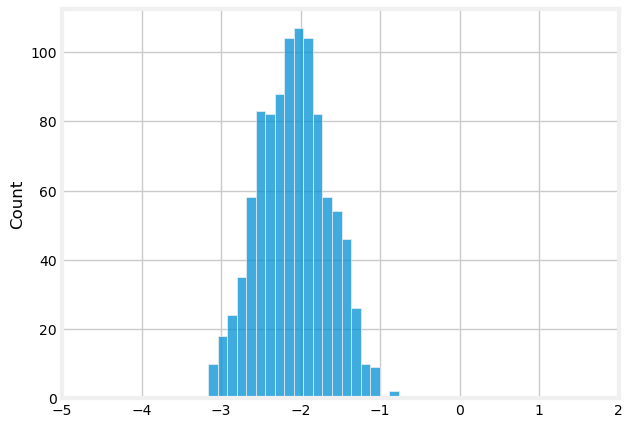

In [96]:
tmp = np.log10(pd.Series(sigeta).sample(frac=0.01))
sns.histplot(tmp)

plt.xlim(-5, 2)

del tmp

In [97]:
del Xm, inter, sigeta

#### B: Treatment

Let us now model the treatment. We follow the same formulas as before, but this we need to update the coefficients (and even the intercept, since the population itself has changed: we are conditioning on having received the treatment).

In [98]:
beta_coeffs_treat = beta_coeffs_base.copy() # we make a shallow copy of the baseline

# age [increase = 10 years]:
# treatment increases conversion rate for younger people: 10 years younger are a relative 10% more responsive
beta_coeffs_treat['age'] += beta_j(pstar, -0.1, 10)

# income [increase = one order of magnitude]:
# treatment increases conversion rate by an additional relative 10% every order of magnitude more of income a year
beta_coeffs_treat['log10_income'] += beta_j(pstar, +0.1, 1)

# balance [increase = one order of magnitude]:
# treatment increases conversion rate by an additional relative 10% by adding $100,000 to balance
beta_coeffs_treat['log10_retirement_balance'] += beta_j(pstar, +0.1, 1)

# acct_tenure [increase = 1 year]
# treatment increases conversion rate by an additional relative 1% when adding 1 year to the account tenure
beta_coeffs_treat['acct_tenure'] += beta_j(pstar, +0.01, 1)

# last_login [increase = 1 day]
# treatment increases the conversion rate of those with most recent logins by a relative 5%
beta_coeffs_treat['last_login'] += beta_j(pstar, -0.05, 1)

# time_online_frac [increase = 1 hr]
# treatment increases the conversion rate of those more terminally online by a relative 10% for every hour more spent
# EXPLANATION
beta_coeffs_treat['time_online_frac'] = beta_j(pstar, +0.1, (1./24))

So the new coefficients are:

In [99]:
beta_coeffs_treat

age                              -0.060821
log10_income                      1.115053
log10_retirement_balance         -0.405474
acct_tenure                      -0.015205
last_login                       -0.052712
current_pct_above_7pp            -0.693147
current_pct_above_employer_cap   -0.693147
time_online_frac                  2.432843
dtype: float64

Compare to baseline:

In [100]:
beta_coeffs_base

age                              -0.050684
log10_income                      1.013685
log10_retirement_balance         -0.506842
acct_tenure                      -0.025342
last_login                       -0.002027
current_pct_above_7pp            -0.693147
current_pct_above_employer_cap   -0.693147
dtype: float64

Let us now define a function that takes the population data and applies to it the necessary transformations to turn it into the feature matrix `Xmatrix` for the treatment:

In [101]:
def X_features_beta_treat(data):
    """
    Construct a feature matrix for treatment logistic regression modeling.

    Includes base features plus `time_online_frac`, and binary indicators for contribution thresholds.

    Args:
        data (DataFrame): Input dataset containing columns:
            'age', 'income', 'retirement_balance', 'acct_tenure',
            'last_login', 'time_online_frac', 'current_pct', 'employer_cap'.

    Returns:
        DataFrame: Feature matrix suitable for logistic regression with treatment features.
    """


    Xmatrix = pd.DataFrame()

    Xmatrix['age'] = data['age']
    Xmatrix['log10_income'] = np.log10(data['income'])
    Xmatrix['log10_retirement_balance'] = np.log10(data['retirement_balance'])
    Xmatrix['acct_tenure'] = data['acct_tenure']
    Xmatrix['last_login'] = data['last_login']
    Xmatrix['time_online_frac'] = data['time_online_frac']
    
    Xmatrix['current_pct_above_7pp'] =\
        (data['current_pct'] > 0.07).astype(int)
    
    Xmatrix['current_pct_above_employer_cap'] =\
        (data['current_pct'] >= data['employer_cap']).astype(int)

    return Xmatrix

Example computation:

In [102]:
Xm = X_features_beta_treat(full_data)

display(Xm)

age  log10_income  log10_retirement_balance  acct_tenure  \
0      83.117431      5.372373                  6.296701     2.786248   
1      60.998169      5.516026                  5.769385     6.396106   
2      61.260696      6.369193                  6.481226     0.442490   
3      59.790852      6.764428                  6.312154     1.830201   
4      59.981025      6.325588                  5.675320     0.803137   
...          ...           ...                       ...          ...   
99995  47.424480      5.756427                  6.736509     7.292631   
99996  58.010022      6.052392                  6.324063     6.564807   
99997  45.240766      5.381335                  6.000331     8.520276   
99998  71.982608      5.533808                  6.445209     4.252762   
99999  74.327107      5.038841                  5.819271     4.802463   

       last_login  time_online_frac  current_pct_above_7pp  \
0            32.2             0.115                      1   
1             9.3             0.192                      1   
2           161.3             0.181                      1   
3            11.0             0.151                      1   
4             3.5             0.197                      1   
...           ...               ...                    ...   
99995         5.4             0.217                      1   
99996        30.0             0.185                      1   
99997         0.1             0.193                      1   
99998        21.1             0.140                      1   
99999        20.1             0.154                      1   

       current_pct_above_employer_cap  
0                                   1  
1                                   1  
2                                   0  
3                                   0  
4                                   1  
...                               ...  
99995                               1  
99996                               1  
99997                               1  
99998                               1  
99999                               1  

[100000 rows x 8 columns]

We can then compute $\beta_0$, demanding a lift of 2% over baseline

In [103]:
lift = 0.02
inter = beta0_fn((pstar+lift), beta_coeffs_treat, Xm)
print(inter)

-2.700778625249093


From that we can compute $\eta$:

In [104]:
eta_fn((beta_coeffs_treat, inter), Xm)

array([ -7.16493359,  -4.10608615, -10.71461207, ...,  -2.93645423,
        -5.74428766,  -6.10658244], shape=(100000,))

And from that we can find $\overline{p} = \langle \sigma(\eta) \rangle$:

In [105]:
sigeta = sigma_fn((beta_coeffs_treat, inter), Xm)
print("sigma(eta) =", sigeta)
print("pbar = <sigma(eta)> =", float(np.mean(sigeta)))

sigma(eta) = [7.72632905e-04 1.62051843e-02 2.22174112e-05 ... 5.03806414e-02
 3.19080016e-03 2.22319904e-03]
pbar = <sigma(eta)> = 0.033500000000000016


Proportion of values above 0.5:

Histogram:

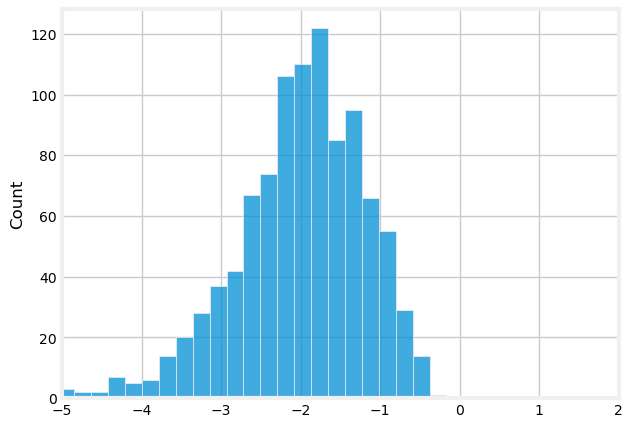

In [106]:
tmp = np.log10(pd.Series(sigeta).sample(frac=0.01))
sns.histplot(tmp)

plt.xlim(-5, 2)

del tmp

In [107]:
del Xm, lift, inter, sigeta

### Modeling Contribution Change

We now proceed to model the change $\Delta$ in contributions, as a percentage of the income. We will model them as draws from a log normal:

$\ln\Delta \sim \mathcal{N}(\mu_{\ln}, \sigma_{\ln})$.

This has the following properties:

$\mathrm{mean}[\ln \Delta] = \mathbb{E}[\ln\Delta] = \mu_{\ln}$,

$\mathrm{median}[\Delta] = e^{\mu_{\ln}} \Rightarrow \ln(\mathrm{median}[\Delta]) = \mu_{\ln}$,

$\mathrm{mean}[\Delta] = \mathbb{E}[\Delta] = e^{\mu_{\ln} + \frac{1}{2} \sigma_{\ln}^2} \Rightarrow \ln(\mathbb{E}[\Delta]) = \mu_{\ln} + \frac{1}{2} \sigma_{\ln}^2$,

$\mathrm{Var}(\ln \Delta) = \sigma_{\ln}^2$

(_i.e._, $\sigma_{\ln}^2$ is the variance unaccounted for by the covariates).

In all likelihood the covariates $\mathbf{X}$ should influence $\mu_{\ln}$, so that we should have instead:

$\ln\Delta_i \sim \mathcal{N}(\mu_{\ln,i}, \sigma_{\ln})$,

where we can model the mean $\mu_{\ln,i}$ for _each_ user as:

$\mu_{\ln,i} = \alpha_0 + \boldsymbol\alpha \mathbf{X}_i + \varepsilon_i$,

where $\varepsilon_i \sim \mathcal{N}(0, \sigma_{\ln})$ the noise. Thus:

$\mathrm{Var}(\ln \Delta) = \mathrm{Var}(\boldsymbol\alpha \mathbf{X}) + \sigma_{\ln}^2$.

Like in the case of modeling the conversion, let us begin by ignoring the noise and focusing instead in the deterministic model.

We can easily see that:

$\alpha_j = \frac{d \ln \Delta}{d X_j} = \approx \frac{\delta (\Delta) / \Delta}{\delta X_j}$

(we temporarily use $\delta y$ as "small increment in $y$"; apologies about the notation)

In [133]:
def alpha_j(dlnd, dXj):
    """
    Compute a simple linear coefficient alpha_j.

    Args:
        dlnd (float): Change in log-odds (or dependent variable).
        dXj (float): Change in predictor variable X_j.

    Returns:
        float: Linear coefficient alpha_j.
    """

    return dlnd/dXj

For $\alpha_0$ things are a bit more complicated. Having computed $\boldsymbol\alpha$, we can find $\alpha_0$ by solving:

$\mu_{\ln} \approx \hat{\mu}_{\ln} = \langle \ln\Delta \rangle = \frac{1}{N} \sum\limits_{i=0}^{N} \ln\Delta_i = \alpha_0 + \frac{1}{N} \sum\limits_{i=1}^{N} \boldsymbol\alpha X_i$,

$\Rightarrow \alpha_0 = \mu_{\ln} - \frac{1}{N} \sum\limits_{i=1}^{N} \boldsymbol\alpha X_i$

We first define the function that computes $\ln\Delta(X)$:

In [134]:
# rough scale of ln of the contributions growth (assumed ~2%)
lnd_scale = np.abs(np.log(0.02))

# computing ln delta = alpha_0 + alpha_j*X_j
def lndelta_fn(alphaj_alpha0, Xmatrix, noise=False, noise_sigma=0.1*lnd_scale, random_state=1):
    """
    Compute the log-change (ln delta) of contributions using a linear model.

    ln delta = alpha0 + sum(alpha_j * X_j), optionally with Gaussian noise.

    Args:
        alphaj_alpha0 (tuple): Tuple containing array-like alphas and scalar alpha0.
        Xmatrix (DataFrame): Feature matrix with columns corresponding to alphas.
        noise (bool, optional): Whether to add Gaussian noise. Defaults to False.
        noise_sigma (float, optional): Standard deviation of noise. Defaults to 0.1 * lnd_scale.
        random_state (int, optional): Seed for random number generation. Defaults to 1.

    Returns:
        float or ndarray: Log-change(s) of contributions.
    """
    
    alphas, alpha0 = alphaj_alpha0 # splitting the alphas

    # alpha_j*X_j
    alphaX = Xmatrix.mul(alphas, axis=1).to_numpy()
    
    # sum(alpha_j*X_j)
    covars = np.sum(alphaX, axis=1)

    # ln delta = alpha*X + alpha0
    lnd = covars + alpha0

    # trying different lengths
    try:
        n = len(lnd)
    except TypeError:
        n = 1

    # add noise (default is 10% of a ~1% scale of increments)
    if noise:
        rng = np.random.default_rng(seed=random_state)
        lnd_arr = rng.normal(loc=0., scale=noise_sigma, size=n)
        lnd += lnd_arr

    if len(lnd) == 1:
        return float(lnd[0])
    else:
        return lnd

Now we define the $\alpha_0$:

In [135]:
def alpha0_fn(target_muln, alphas, Xmatrix, **mu_kwargs):
    """
    Compute the intercept (alpha0) for a contributions growth model.

    Solves for alpha0 such that the population mean of ln delta matches the target multiplier.

    Args:
        target_muln (float): Desired average log-change (ln delta) across the population.
        alphas (array-like): Coefficients for predictor variables.
        Xmatrix (DataFrame): Feature matrix corresponding to alphas.
        **mu_kwargs: Additional arguments passed to `lndelta_fn` (e.g., noise, noise_sigma, random_state).

    Returns:
        float: Intercept alpha0 for the contributions growth model.
    """

    # alpha_j* X_ij
    alphaX_i = lndelta_fn((alphas, 0), Xmatrix, **mu_kwargs)

    # result
    a0 = target_muln - np.mean(alphaX_i)

    return a0

#### A: Baseline/Control

We now define the coefficients $\boldsymbol\alpha$ for the baseline model; remember: conditioned upon they having converted! (so no need to consider their age or how recently they have checked in their account, etc.).

Recall

$\alpha_j = \frac{d \ln \Delta}{d X_j} \approx \frac{\delta (\Delta) / \Delta}{\delta X_j}$.

In [136]:
alpha_coeffs_base = {}

# income [increase = one order of magnitude]:
# one order of magnitude a year in income more increases the relative contribution growth by 50%
# EXPLANATION: earning $1M more will want to make us growth the contribution by a factor of e
alpha_coeffs_base['log10_income'] = alpha_j(0.5, 1)

# balance [increase = one order of magnitude]
# one more order of magnitude in the balance decreases the relative contribution growth by 20%
alpha_coeffs_base['log10_retirement_balance'] = alpha_j(-0.2, 1)

# current_pct threshold
# if current_pct > 7% (the mode of employee contributions), the relative contribution growth decreases by 50%
# EXPLANATION: it starts to feel like a lot
alpha_coeffs_base['current_pct_above_7pp'] = -0.5

# employer matching
# if current_pct > employer_cap, the relative contribution growth decreases by 50%
alpha_coeffs_base['current_pct_above_employer_cap'] = -0.5

alpha_coeffs_base = pd.Series(alpha_coeffs_base)

In [137]:
alpha_coeffs_base

log10_income                      0.5
log10_retirement_balance         -0.2
current_pct_above_7pp            -0.5
current_pct_above_employer_cap   -0.5
dtype: float64

Let us now define a function that takes the population data and applies to it the necessary transformations to turn it into the feature matrix `Xmatrix`:

In [138]:
def X_features_alpha_base(data):
    """
    Construct a feature matrix for base contributions growth modeling.

    Features include log-transformed income and retirement balance, and binary indicators for contribution thresholds.

    Args:
        data (DataFrame): Input dataset containing columns:
            'income', 'retirement_balance', 'current_pct', 'employer_cap'.

    Returns:
        DataFrame: Feature matrix suitable for contributions growth modeling.
    """

    Xmatrix = pd.DataFrame()
    
    Xmatrix['log10_income'] = np.log10(data['income'])
    Xmatrix['log10_retirement_balance'] = np.log10(data['retirement_balance'])
    
    Xmatrix['current_pct_above_7pp'] =\
        (data['current_pct'] > 0.07).astype(int)
    
    Xmatrix['current_pct_above_employer_cap'] =\
        (data['current_pct'] >= data['employer_cap']).astype(int)

    return Xmatrix

Example computation:

In [139]:
Xm = X_features_alpha_base(full_data)

display(Xm)

log10_income  log10_retirement_balance  current_pct_above_7pp  \
0          5.372373                  6.296701                      1   
1          5.516026                  5.769385                      1   
2          6.369193                  6.481226                      1   
3          6.764428                  6.312154                      1   
4          6.325588                  5.675320                      1   
...             ...                       ...                    ...   
99995      5.756427                  6.736509                      1   
99996      6.052392                  6.324063                      1   
99997      5.381335                  6.000331                      1   
99998      5.533808                  6.445209                      1   
99999      5.038841                  5.819271                      1   

       current_pct_above_employer_cap  
0                                   1  
1                                   1  
2                                   0  
3                                   0  
4                                   1  
...                               ...  
99995                               1  
99996                               1  
99997                               1  
99998                               1  
99999                               1  

[100000 rows x 4 columns]

We can then compute $\alpha_0$:

In [140]:
inter = alpha0_fn(np.log(0.01), alpha_coeffs_base, Xm)
print(inter)

-5.424249653397649


From that we can compute $\ln\Delta = \boldsymbol\alpha \mathbf{X} + \alpha_0$:

In [141]:
lnds = lndelta_fn((alpha_coeffs_base, inter), Xm)

print(lnds)
print(np.mean(lnds))
print(np.std(lnds, ddof=1))

[-4.99740324 -4.82011335 -4.03589826 ... -4.93364862 -4.94638726
 -5.06868308]
-4.605170185988092
0.3446063339433121


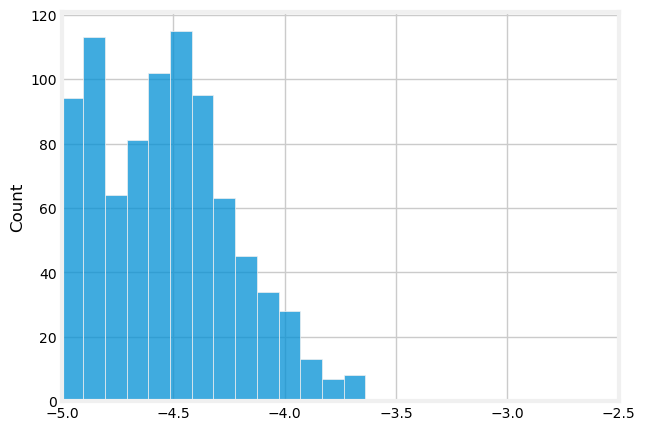

In [142]:
sns.histplot(pd.Series(lnds).sample(frac=0.01))

plt.xlim(-5, -2.5);

Looking at the $\Delta$s instead:

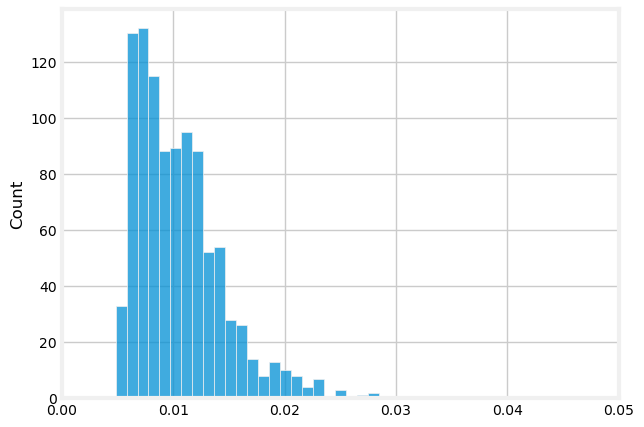

In [143]:
ds = np.exp(lnds)

sns.histplot(pd.Series(ds).sample(frac=0.01))

plt.xlim(0, 0.05);

But typically we round up the contributions to the neares 0.25%:

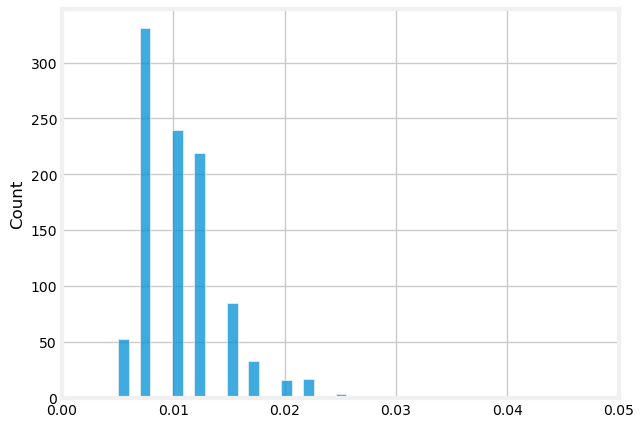

In [144]:
ds = np.round(ds*400)/400

sns.histplot(pd.Series(ds).sample(frac=0.01))

plt.xlim(0, 0.05);

In [145]:
del lnds, ds

#### B: Treatment

Let us now model the changes to the coefficients $\boldsymbol\alpha$ for the treatment:

In [146]:
alpha_coeffs_treat = alpha_coeffs_base.copy()

# age [increase = 10 years]:
# treatment boosts relative contribution growth by 20% for every 10 years *younger*
alpha_coeffs_treat['age'] = alpha_j(-0.2, 10)

# income [increase = one order of magnitude]:
# treatment boosts relative contribution growth by 20% for every order of magnitude more in income
alpha_coeffs_treat['log10_income'] += alpha_j(0.2, 1)

# balance [increase = one order of magnitude]
# treatment boosts relative contribution growth by 10% for every order of magnitude more in balance
alpha_coeffs_treat['log10_retirement_balance'] += alpha_j(0.1, 1)

Compare the treatment coefficients:

In [147]:
alpha_coeffs_treat

log10_income                      0.70
log10_retirement_balance         -0.10
current_pct_above_7pp            -0.50
current_pct_above_employer_cap   -0.50
age                              -0.02
dtype: float64

With the baseline/control:

In [148]:
alpha_coeffs_base

log10_income                      0.5
log10_retirement_balance         -0.2
current_pct_above_7pp            -0.5
current_pct_above_employer_cap   -0.5
dtype: float64

Let us now define a function that takes the population data and applies to it the necessary transformations to turn it into the feature matrix `Xmatrix`:

In [149]:
def X_features_alpha_treat(data):
    """
    Construct a feature matrix for treatment contributions growth modeling.

    Includes base features (log-transformed income and retirement balance, and binary contribution indicators) plus age.

    Args:
        data (DataFrame): Input dataset containing columns:
            'income', 'retirement_balance', 'current_pct', 'employer_cap', 'age'.

    Returns:
        DataFrame: Feature matrix suitable for contributions growth modeling with treatment features.
    """

    Xmatrix = pd.DataFrame()
    
    Xmatrix['log10_income'] = np.log10(data['income'])
    Xmatrix['log10_retirement_balance'] = np.log10(data['retirement_balance'])
    
    Xmatrix['current_pct_above_7pp'] =\
        (data['current_pct'] > 0.07).astype(int)
    
    Xmatrix['current_pct_above_employer_cap'] =\
        (data['current_pct'] >= data['employer_cap']).astype(int)

    Xmatrix['age'] = data['age']

    return Xmatrix

Example computation:

In [150]:
Xm = X_features_alpha_treat(full_data)

display(Xm)

log10_income  log10_retirement_balance  current_pct_above_7pp  \
0          5.372373                  6.296701                      1   
1          5.516026                  5.769385                      1   
2          6.369193                  6.481226                      1   
3          6.764428                  6.312154                      1   
4          6.325588                  5.675320                      1   
...             ...                       ...                    ...   
99995      5.756427                  6.736509                      1   
99996      6.052392                  6.324063                      1   
99997      5.381335                  6.000331                      1   
99998      5.533808                  6.445209                      1   
99999      5.038841                  5.819271                      1   

       current_pct_above_employer_cap        age  
0                                   1  83.117431  
1                                   1  60.998169  
2                                   0  61.260696  
3                                   0  59.790852  
4                                   1  59.981025  
...                               ...        ...  
99995                               1  47.424480  
99996                               1  58.010022  
99997                               1  45.240766  
99998                               1  71.982608  
99999                               1  74.327107  

[100000 rows x 5 columns]

We can then compute $\alpha_0$, assuming a boost from 1% to 3% contribution increments:

In [151]:
inter = alpha0_fn(np.log(0.03), alpha_coeffs_treat, Xm)
print(inter)

-4.84604606819906


From that we can compute $\ln\Delta = \boldsymbol\alpha \mathbf{X} + \alpha_0$:

In [152]:
lnds = lndelta_fn((alpha_coeffs_treat, inter), Xm)

print(lnds)
print(np.mean(lnds))
print(np.std(lnds, ddof=1))

[-4.37740363 -3.78172938 -2.76094734 ... -3.58396034 -4.05655333
 -4.3873263 ]
-3.506557897319981
0.5244745482592135


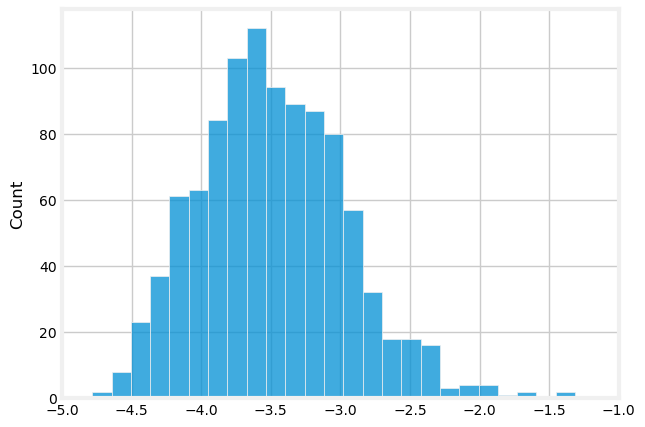

In [153]:
sns.histplot(pd.Series(lnds).sample(frac=0.01))

plt.xlim(-5, -1);

Looking at the $\Delta$s instead:

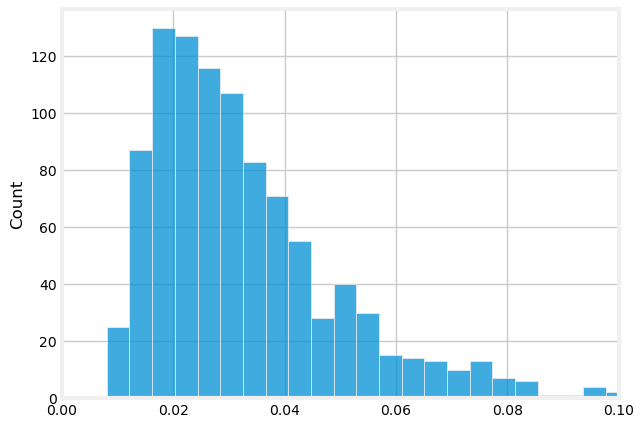

In [154]:
ds = np.exp(lnds)

sns.histplot(pd.Series(ds).sample(frac=0.01))

plt.xlim(0, 0.1);

Rounding up to the neares 0.25%:

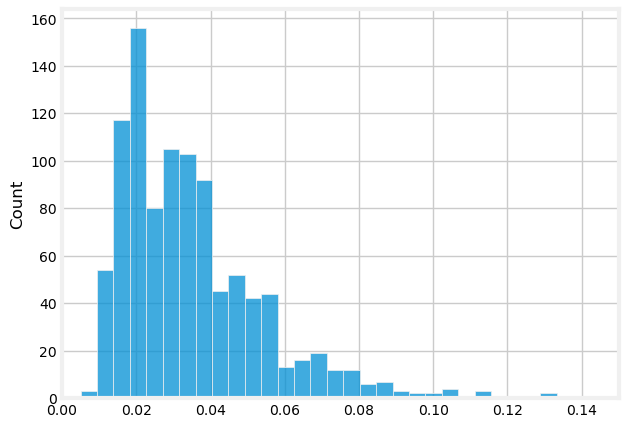

In [155]:
ds = np.round(ds*400)/400

sns.histplot(pd.Series(ds).sample(frac=0.01))

plt.xlim(0, 0.15);

In [156]:
del lnds, ds

### Experiment

We now devise the experiment. The recipe:

1. We compute the size $n = n_A = n_B$ of each of the arms based on our previous knowledge of $p_0$ ($= p_A$), what we want for the Type I and II errors ($\alpha$ and $\beta$), and the MDE $\Delta = p_B - p_A$ we want. Compute power curve ($n$ vs. $p_A$, taken to vary accross $2\sigma$ (_i.e._ $\pm p_A(1-p_A)$)).

2. We highlight the secondary metric (the increase $\Delta$ in contributions), and any guardrail metrics to monitor.

3. We simulate the experiment: take the population and randomly assign either A or B to $2 n$ members of it, by hashing the user id. We can do the experiment once and for all, or simulate a 10%-25%-50%-100% roll-out. At any rate, we simply create two new tables, one for each group. The table for A has extra information about when and how it was nudged. Regardless, the point is that each element has a probability $p_i$, taken from our conversion model, of converting, and thus there is a Bernoulli process associated to each element. Note that we add a little bit of noise to create $p_i$ (it's not deterministic). There is also $\Delta_i$ for each, also with some noise in $\mu$ (but not in $\sigma$).

4. We perform the analysis, compute the SE and CI

#### Experiment Design

We are interested in designing an experiment that tests whether we can observe any uplift in the conversion rate ("user decides to increase retirement contributions").

Here are some important terms:

- **RCT (Randomized Controlled Trial):** this A/B experiment.
- **ATE (Average Treatment Effect):** effect of actual treatment.
- **ITT (Intention-To-Test):** effect of assignment (policy lever). ITT = ATE if there is perfect compliance (assignment = receipt)
- **CACE (Complier Average Causal Effect):** effect among those who receive treatment if there is noncompliance
- **CATE (Aonditional ATE)** the ATE conditional on covariates.
- **HTE (Heterogeneous Treatment Effects):** how the treatment effect varies across individuals or subgroups. Basically, the CATE when conditioning on groups.

Here are some important quantities:

- **Primary metric ITT:** $\mathbb{E}[Y | Z = 1] - \mathbb{E}[Y | Z = 0] = p_B - p_A$, where $Y$ is "yes, user converted" (got a 1 in its Bernoulli trial to increase contribution), and $Z = 0/1$ is "received treatment/did not receive treatment".
- **Primary metric ATE:** estimates the ITT, and is the difference in sample conversion rates: $\hat{d} \equiv \hat{p}_B - \hat{p}_A$.
- **Secondary metric:** $\mathbb{E}[\Delta | Z = 1] - \mathbb{E}[\Delta | Z = 0] = \mu_{\ln,A} - \mu_{\ln,B}$. Possible additional ITT if we can power enough. We estimate it (secondary ATE) as $\hat{m} \equiv \hat{\mu}_{\ln,A} - \hat{\mu}_{\ln,B} = \langle \ln \Delta_B \rangle - \langle \ln \Delta_A \rangle$.
- **Type I and II errors:** $\alpha = 0.05$, $\beta = 0.2$.
- **MDE (Minimum Detectable Effect):** ($\delta$) the smallest primary ATE which we define as actionable. If it is positive, it is also called the _(up)lift_. We will take it to be $\delta = 2 \%$ (a lift of 2%).

##### Arm Size

Based on $\alpha$, $\beta$, and required $\delta$, we can find $n_A = n_B = n$:

$n = \frac{\left( z_{1-\alpha/2} \sqrt{2\overline{p}(1 - \overline{p})} + z_{1 - \beta} \sqrt{p_B (1 - p_B) + p_A (1 - p_A)} \right)^2}{\delta^2}$,

where

$\overline{p} = (p_A + p_B)/2 = p_A + \delta/2$ is the pooled conversion probability.

If we are interested in powering the difference in means of the continuous variables as well, $m = \mu_B - \mu_A$, we need

$n \approx \frac{2 \, (z_{1 - \alpha/2} + z_{1 - \beta})^2 \, \sigma_{\Delta}^2}{m^2}$,

where $\sigma_{\Delta}$ is the variance of the $\Delta$'s, assumed to be the same in both arms. Conservatively, we can take $\sigma_{\Delta} = \max(\sigma_{\Delta,A}, \sigma_{\Delta,B})$.
**N.B.:** Here $\mu_X$ and $\sigma_\Delta$ are the mean and std, respectively, of the $\Delta$ _of the true underlying PDF_ (for large $N$, the same as those _of the entire population_, including conversions AND non-conversions). In other words they are _different_ from the mean and std of the **log**-normal distribution, which was conditioned upon conversion: $\mu_X \neq \mu_{\ln,X}$, and $\sigma_\Delta \neq \sigma_{\ln}$.

In [157]:
from scipy.stats import norm, t as student_t

In [158]:
def n_per_arm_diff_props(pA, pB, alpha=0.05, power=0.80):
    """
    Compute per-arm sample size for detecting a difference in proportions.

    Uses a two-sided z-test with specified significance level and power.

    Args:
        pA (float): Conversion rate in control group.
        pB (float): Conversion rate in treatment group.
        alpha (float, optional): Significance level. Defaults to 0.05.
        power (float, optional): Desired power. Defaults to 0.80.

    Returns:
        float: Required sample size per arm.
    """
    
    beta = 1 - power # Type II error rate

    z_a = norm.ppf(1 - alpha/2) # z_{1 - alpha/2}

    z_b = norm.ppf(1 - beta) # z_{1-beta}
    
    pbar = 0.5*(pA + pB) # pooled conversion rate

    # numerator
    num = (z_a*np.sqrt(2*pbar*(1-pbar)) + z_b*np.sqrt(pA*(1-pA)+pB*(1-pB)))**2

    # denominator
    den = (pB - pA)**2

    # number of samples per arm
    n = num/den
    
    return n



def n_per_arm_diff_means(delta, sigma2, alpha=0.05, power=0.8):
    """
    Compute per-arm sample size for detecting a difference in means.

    Assumes equal variance per group and equal allocation between groups.

    Args:
        delta (float): Difference in means to detect (muB - muA).
        sigma2 (float): Assumed variance per group.
        alpha (float, optional): Significance level. Defaults to 0.05.
        power (float, optional): Desired power. Defaults to 0.80.

    Returns:
        float: Required sample size per arm.
    """

    beta = 1 - power # Type II error rate

    z_a = norm.ppf(1 - alpha/2) # z_{1 - alpha/2}

    z_b = norm.ppf(1 - beta) # z_{1-beta}
    
    num = 2 * (z_a + z_b)**2 * sigma2
    
    den = delta**2
    
    return num / den

Given a baseline $p_0$ with variance $p_0 (1-p_0)$, we can make a power curve by varying the estimated $\hat{p}_0$ of a population of size $N$ over its standard error $\hat{\mathrm{SE}}$ for a given $\delta$ and power specification.

**NOTE:** the variance above is the variance in a single Bernoulli trial, NOT the standard error of the estimated proportion. The standard error is

$\hat{\mathrm{SE}} = \sqrt{\hat{p}_0 (1-\hat{p}_0) / N}$

by the CLT.

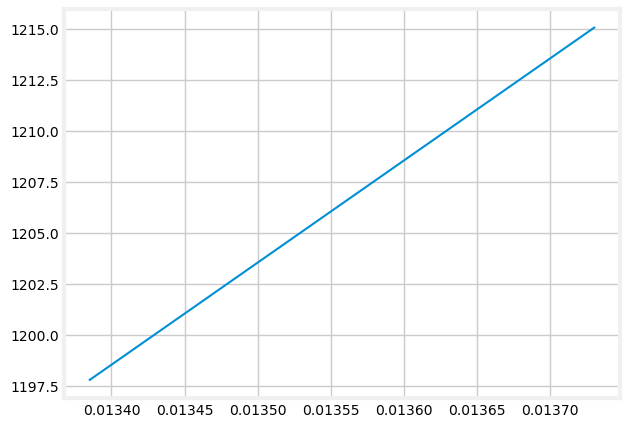

In [159]:
std = np.sqrt(pstar*(1-pstar))/1_000 # assuming 1,000 points of historical data
lift = 0.02

parr = np.linspace(np.min(pstar-1*std,0), pstar+2*std, 101)
narr = n_per_arm_diff_props(parr, parr + lift, alpha=0.05, power=0.90)

plt.plot(parr, narr)

del std, lift, parr, narr

##### Confidence Intervals

We can build the confidence intervals:

$\hat{d} \pm z_{1 - \alpha/2} \hat{\mathrm{SE}}$,

where

$\hat{SE} = \sqrt{\frac{\hat{s}_A^2}{n_A} + \frac{\hat{s}_B^2}{n_B}}$

and $\hat{s}_X^2$ the sample variance of the proportions:

$\hat{s}_X^2 = \frac{1}{N-1}\sum\limits_{i=1}^N (\text{(Y or N)} - \hat{p}_X)^2 \approx \hat{p}_X (1 - \hat{p}_X)$.

Similarly for the continuous secondary metric.

In [160]:
def props_diff_CI(xA, xB, alpha=0.05):
    """
    Compute the difference in proportions and its confidence interval.

    Args:
        xA (array-like): Binary outcomes for group A.
        xB (array-like): Binary outcomes for group B.
        alpha (float, optional): Significance level. Defaults to 0.05.

    Returns:
        tuple: (Difference in proportions, lower and upper bounds of CI)
    """

    nA, nB = len(xA), len(xB)
    
    hat_pA, hat_pB = np.sum(xA)/nA, np.sum(xB)/nB
    
    hat_d = hat_pB - hat_pA
    
    hat_se = np.sqrt(hat_pA*(1-hat_pA)/nA + hat_pB*(1-hat_pB)/nB)
    
    z_crit = norm.ppf(1 - alpha/2.0)
    
    return hat_d, (hat_d - z_crit*hat_se, hat_d + z_crit*hat_se)



def welch_df(s1_sq, s2_sq, n1, n2):
    """
    Compute the Welch-Satterthwaite degrees of freedom for unequal variances.

    Args:
        s1_sq (float): Variance of group 1.
        s2_sq (float): Variance of group 2.
        n1 (int): Sample size of group 1.
        n2 (int): Sample size of group 2.

    Returns:
        float: Approximate degrees of freedom for Welch's t-test.
    """
    
    num = (s1_sq/n1 + s2_sq/n2)**2
    
    den = (s1_sq**2)/((n1**2)*(n1-1)) + (s2_sq**2)/((n2**2)*(n2-1))
    
    return num/den



def means_diff_CI(YA, YB, alpha=0.05, use_tdist=False):
    """
    Compute the difference in means and its confidence interval.

    Can use either normal approximation or Welch's t-distribution for CI.

    Args:
        YA (array-like): Observations for group A.
        YB (array-like): Observations for group B.
        alpha (float, optional): Significance level. Defaults to 0.05.
        use_tdist (bool, optional): Use Welch's t-distribution for CI. Defaults to False.

    Returns:
        tuple: (Difference in means, lower and upper bounds of CI, degrees of freedom if t-dist used)
    """

    
    nA, nB = len(YA), len(YB)
    
    hat_mA, hat_mB = YA.mean(), YB.mean()
    
    hat_vA, hat_vB = YA.var(ddof=1), YB.var(ddof=1)
    
    hat_se = np.sqrt(hat_vA/nA + hat_vB/nB)

    if use_tdist:
        df = welch_df(vA, vB, nA, nB)
        crit = student_t.ppf(1 - alpha/2.0, df)

    else:
        df = None
        crit = norm.ppf(1 - alpha/2.)
    
    hat_nu = hat_mB - hat_mA
    
    return hat_nu, (hat_nu - crit*hat_se, hat_nu + crit*hat_se), df

##### Randomization

We now define the randomization function:

In [161]:
def ab_randomize(n_arm, all_ids, random_state=1):
    """
    Randomly assign IDs to two experimental arms.

    Selects 2*n_arm IDs from all_ids and splits them into two groups of size n_arm.

    Args:
        n_arm (int): Number of samples per experimental arm.
        all_ids (array-like): Pool of available IDs.
        random_state (int, optional): Seed for reproducibility. Defaults to 1.

    Returns:
        tuple: Two arrays containing IDs assigned to arm A and arm B.
    """

    rng = np.random.default_rng(seed=random_state)
    test_ids = rng.choice(all_ids, size=2*n_arm, replace=False)

    rng = np.random.default_rng(seed=random_state)
    ids_A = rng.choice(test_ids, size=n_arm, replace=False)
    ids_B = np.array(list(set(test_ids) - set(ids_A)))

    return ids_A, ids_B

#### Simulation

We now proceed to simulate the experiment.

In [162]:
from scipy.stats import bernoulli

##### User Response

Let us begin by defining a function that computes the user response (_i.e._ performs the bare bones of the experiment) for a given dataset.

In [163]:
def experiment_fn(binary_true, cont_true, data, b0_a0=(None, None), random_state=1, intercepts=False):
    """
    Simulate an A/B-style experiment with binary conversion and continuous contribution outcomes.

    The binary outcome models conversion (Y/N) using logistic regression, while the continuous outcome models contribution growth for converters.

    Args:
        binary_true (float): Target population conversion rate.
        cont_true (float): Target average contribution growth for converters.
        data (DataFrame): Input dataset containing necessary feature columns.
        b0_a0 (tuple, optional): Pre-specified intercepts (b0, a0) for binary and continuous models.
            Defaults to (None, None) to compute intercepts automatically.
        random_state (int, optional): Seed for random number generation. Defaults to 1.
        intercepts (bool, optional): Whether to return the computed intercepts. Defaults to False.

    Returns:
        DataFrame: Simulated dataset with columns 'conv_rate', 'converted', 'delta_pct', 'new_pct'.
        dict (optional): Dictionary of intercepts if `intercepts=True`.
    """

    # splitting intercepts:
    b0, a0 = b0_a0

    # begin with the binary part
    X_props = X_features_beta_base(data) # feature matrix
    if b0 == None:
        b0 = beta0_fn(binary_true, beta_coeffs_base, X_props) # intercept
    prob_i = sigma_fn((beta_coeffs_base, b0), X_props) # Bernoulli prob
    conv = bernoulli.rvs(p=prob_i, random_state=(random_state)) # convert Y/N?

    # find the indices where there was a conversion
    idx_conv = np.where(conv == 1)[0]

    # addt'l contributions
    X_means = X_features_alpha_base(data) # feature matrix
    # for contributions, we are interested only on those converted
    X_means = X_means.iloc[idx_conv]
    
    if a0 == None:
        a0 = alpha0_fn(cont_true, alpha_coeffs_base, X_means) # intercept
    DiA = np.exp(lndelta_fn((alpha_coeffs_base, a0), X_means)) # contribution growth
    DiA = np.round(DiA*100*4)/400 # rounding to nearest 0.25%

    # defining the result dataframe
    df = data.copy()

    # conversion rate
    df['conv_rate'] = prob_i

    # converted?
    df['converted'] = conv
    
    # additional contributions
    df['delta_pct'] = 0. # default is 0
    addtl_idx = df.columns.get_loc('delta_pct')
    df.iloc[idx_conv,addtl_idx] = DiA # locating those that converted

    # new contributions
    df['new_pct'] = df['current_pct'] + df['delta_pct']

    if intercepts:
        return df, {'binary_intercept':b0, 'cont_intercept':a0}
    else:
        return df

In [164]:
# test = experiment_fn(pstar, np.log(0.02), full_data, b0_a0=(None, None), random_state=1, intercepts=False)

# del test

##### Metrics

We now define a dictionary of important metrics:

_conversion rates_

`exper_binary_metric = {'baseline_true':[ true baseline conversion rate ],
                 'treatment_true':[ true treatment conversion rate ],
                 'MDE':[ minimum detectable effect in conversion rate]}`

_contributions growth_

`exper_continuous_metric = {'baseline_true':[ true baseline mean of logs ],
                     'treatment_true':[ true treatment mean of logs ],
                     'MDE':[ minimum detectable effect in mean of logs ]}`

For example, this:

In [165]:
# conversion rates
exper_binary_metric = {'baseline_true':(1.35/100), # 1.35% (not necessarily reference pstar!)
                 'treatment_true':(1.35 + 2.5)/100, # 3.85%
                 'MDE':2/100} # 2%

# contributions growth
exper_continuous_metric = {'baseline_true':np.log(1.5/100), # 1.5%
                     'treatment_true':np.log(3/100), # 3%
                     'MDE':(1/100)} # +1% over baseline --> 1.5% --> 2.5% [NOT LOGS]

##### Arm Size of Continuous Secondary Metric is Important

We now define another useful function: computing the size of each arm if we are interested in _also_ detecting the MDE in the (continuous) mean of the log of the additional contributions:

In [166]:
def n_arm_cont_historical(primary_metric, secondary_metric, data, alpha=0.05, power=0.8, cushion=0.1, random_state=1):
    """
    Estimate per-arm sample size for a continuous metric using historical data.

    Accounts for conversion conditioning and the population-level variance of additional contributions. Applies a cushion to ensure robustness.

    Args:
        primary_metric (dict): Contains 'baseline_true' conversion rate.
        secondary_metric (dict): Contains 'baseline_true' mean contribution
            (conditioned on conversion) and 'MDE' (minimum detectable effect).
        data (DataFrame): Input dataset for simulation.
        alpha (float, optional): Significance level. Defaults to 0.05.
        power (float, optional): Desired power. Defaults to 0.8.
        cushion (float, optional): Extra padding on sample size. Defaults to 0.1.
        random_state (int, optional): Seed for reproducibility. Defaults to 1.

    Returns:
        int: Estimated number of samples per arm to detect the target effect.
    """

    # extracting the true proportions
    true_pA = primary_metric['baseline_true']

    # extracting the true means (of log-normal, i.e. conditioned on conversion)
    true_mulnA = secondary_metric['baseline_true']

    # extracting the MDE (conditioned on conversion)
    mde_ITT = secondary_metric['MDE'] # MDE on the means of Delta, conditioned on conversion
    mde_ITT *= true_pA # multiplying by conversion rate to obtain the means in the population

    # we can now compute the historical data (just do the entire population)
    hist_data = experiment_fn(true_pA,
                              true_mulnA,
                              data,
                              b0_a0=(None, None),
                              random_state=(3*random_state),
                              intercepts=False)

    # conditioning on conversion
    hist_conv_data = hist_data[hist_data['converted'] == 1]

    # CHECKS:
    # (1) the conversion proportion estimator should be close to true rate
    assert np.isclose((np.mean(hist_data['converted'])/true_pA),
                      1,
                      rtol=0.1)

    # (2) the estimator of the mean of the logs of the addt'l contributions should be close to true value
    assert np.isclose(np.mean(np.log(hist_conv_data['delta_pct']))/true_mulnA,
                      1,
                      rtol=1.e-3)

    # sample mean of the deltas, conditioned on conversion
    mean_conv = np.mean(hist_conv_data['delta_pct'])
    
    # sample variance of the deltas, conditioned on conversion
    sigma_conv2 = np.var(hist_conv_data['delta_pct'], ddof=1)

    # full (i.e. universal) variance of Deltas
    # Var(Delta) = p*s^2 + p(1-p)*m^2
    # = (within-converter variance contribution (averaged over the fraction p who convert)) + (between-converter vs non-converter variance (the variance due to mixing converters of mean m with non-converters at 0))
    p = np.mean(hist_data['converted'])
    sigma_ITT2 = p*sigma_conv2 + p*(1-p)*mean_conv**2
    # sigma_ITT2 = true_pA*sigma_conv2 + true_pA*(1-true_pA)*mean_conv**2

    # full (i.e. universal) variance of Deltas
    sigma_delta2 = np.var(hist_data['delta_pct'], ddof=1)

    # print(sigma_ITT2)
    # print(sigma_delta2)
    # print(sigma_ITT2/sigma_delta2)

    # size of arm required to detect MDE in mean of log of addt'l contributions
    cont_n_arm = n_per_arm_diff_means(mde_ITT,
                                      sigma_ITT2,
                                      alpha=alpha,
                                      power=power)
    
    # padding with cushion, and converting to integer
    cont_n_arm = int(cont_n_arm*(1+cushion))

    return cont_n_arm

In [167]:
n_arm_cont_historical(exper_binary_metric, exper_continuous_metric, full_data, power=0.9)

4951

**N.B.:** a larger number! (due to the smallness of the conversion rate!)

##### Rollout Schedule

A few simple functions that assign rollout dates to the experiment subjects.

In [168]:
from datetime import datetime, timedelta

In [169]:
def rollout_schedule(indices,
                     rollouts=[0.10, 0.15, 0.25],
                     start_date=datetime(2025, 9, 3),
                     delta_days=2):
    """
    Generate a staged rollout schedule for a set of indices.

    Divides the indices into sequential groups based on specified proportions, assigning each group a rollout date starting from `start_date` and incremented by `delta_days`.

    Args:
        indices (array-like): IDs or indices to be rolled out.
        rollouts (list of float, optional): Proportions for each rollout stage.
            Defaults to [0.10, 0.15, 0.25].
        start_date (datetime, optional): Date of first rollout. Defaults to 2025-09-03.
        delta_days (int, optional): Days between successive rollouts. Defaults to 2.

    Returns:
        dict: Mapping from group number to a tuple (rollout_date, indices in group).
    """
    
    N = len(indices) # length of data
    sizes = [int(np.floor(p*N)) for p in rollouts] # size of each rollout
    sizes.append(N - sum(sizes)) # remainder

    rollout_groups = {}
    rollout_date = pd.to_datetime(start_date)
    
    start = 0
    for gp, s in enumerate(sizes):
        
        rollout_groups[gp+1] =\
                (rollout_date, indices[start:start+s])
        
        start += s
        rollout_date += timedelta(days=delta_days)
    
    return rollout_groups

##### Group-wise Experiments

We define a helper function that performs the experiment per group.

In [170]:
def groupwise_experiment(true_binary,
                         true_continuous,
                         arm_data,
                         b0_a0,
                         duration_experiment=30,
                         prep_time=30,
                         nudge_cost_per_user=0.001, # 0.1 cents
                         flat_cost_per_day=(0.5*3*100_000/12/30), # $6,000/month
                         random_state=1):
    """
    Simulate a groupwise A/B experiment with conversion timing and ROI calculation.

    Generates conversion events over a specified duration, computes user and employer contribution growth, and calculates per-user ROI accounting for nudge and flat costs.

    Args:
        true_binary (float): Target conversion rate.
        true_continuous (float): Target contribution growth for converters.
        arm_data (DataFrame): Experimental arm data with necessary feature columns.
        b0_a0 (tuple): Intercepts for binary and continuous models.
        duration_experiment (int, optional): Number of days the experiment runs. Defaults to 30 days.
        prep_time (int, optional): Preparation time in days before experiment. Defaults to 30 days.
        nudge_cost_per_user (float, optional): Direct cost per user for nudges. Defaults to $0.001.
        flat_cost_per_day (float, optional): Daily fixed cost of running the experiment. Defaults to $12,500/30.
        random_state (int, optional): Seed for reproducibility. Defaults to 1.

    Returns:
        DataFrame: Experimental results including conversion dates, delta AUM, and per-user ROI.
    """
    
    res_df = experiment_fn(true_binary,
                          true_continuous,
                          arm_data,
                          b0_a0=b0_a0,
                          random_state=random_state,
                          intercepts=False)

    # conversion date
    res_df['conversion_date'] = pd.NaT # default

    # indices of users with conversions
    conv_idx = res_df[res_df['converted'] == 1].index.to_list()

    # conversion dates

    rng = np.random.default_rng(random_state)   # reproducible global RNG
    # offsets in days: integers from 0..duration_experiment inclusive
    offsets = rng.integers(0, duration_experiment+1, size=len(res_df))
    offsets = pd.Series(offsets, index=res_df.index)
    
    # mask for converted users (assumes 'converted' column exists 0/1)
    mask = (res_df['converted'] == 1)
    # compute conversion dates only for converters
    res_df.loc[mask, 'conversion_date'] = (
        pd.to_datetime(res_df.loc[mask, 'assign_date'])
        + pd.to_timedelta(offsets[mask], unit='D'))

    # business value
    # increase in AUM from user
    res_df['user_delta_aum'] = res_df['delta_pct']*res_df['income']

    # increase in AUM from employer
    maximum_delta_employer = (res_df['employer_cap'] - res_df['current_pct']).clip(lower=0) # the largest the employer can grow

    employer_delta_pct = res_df['delta_pct'].combine(maximum_delta_employer, min) # employer's growth in contributions: the same as user or the most it can grow, whichever is smallest
    
    res_df['employer_delta_aum'] = employer_delta_pct*res_df['income'] # increase in AUM due to employer

    # total increase in AUM
    res_df['total_delta_aum'] = res_df['user_delta_aum'] + res_df['employer_delta_aum']

    # total flat cost

    # earliest day in the experiment
    earliest_day = res_df['assign_date'].min() - timedelta(days=prep_time) # subtract a month of preparation

    # latest_day in the experiment
    latest_day = res_df['assign_date'].max() + timedelta(days=duration_experiment)

    # computing the flat cost per user
    num_users = 2*len(res_df) # anticipating the other arm
    flat_cost_per_user = (flat_cost_per_day*(latest_day - earliest_day).days)/num_users
    
    # ROI
    res_df['roi'] = res_df['total_delta_aum'] - nudge_cost_per_user - flat_cost_per_user

    return res_df

##### Experiment Routine

We are ready to create the experimental routine

In [171]:
column_new_order = ['user_id',
 'rollout_group',
 'assign_date',
 'group',
 'age',
 'age_cohort',
 'income',
 'income_cohort',
 'net_worth',
 'networth_cohort',
 'retirement_balance',
 'balance_cohort',
 'current_pct',
 'employer_cap',
 'last_login',
 'acct_tenure',
 'time_online_frac',
 'conv_rate',
 'converted',
 'conversion_date',
 'delta_pct',
 'new_pct',
 'user_delta_aum',
 'employer_delta_aum',
 'total_delta_aum',
 'roi']

In [375]:
def ab_experiment(primary_metric, secondary_metric, data,
                  largest_narm=False,
                  alpha=0.05, power=0.8,
                  cushion=0.1,
                  rollouts=[0.10, 0.15, 0.25],
                  start_date=datetime(2025, 9, 3),
                  delta_days=2,
                  duration_experiment=30,
                  prep_time=30,
                  nudge_cost_per_user=0.001, # 0.1 cents
                  flat_cost_per_day=(0.5*3*100_000/12/30), # team of 3 people $100k/year, working 0.5 FTE on this project (i.e. half the work day)
                  random_state=1,
                  save_to_file=True):
    """
    Conduct a full A/B experiment simulation with binary and continuous outcomes.

    Randomizes users into arms, assigns rollout schedules, simulates conversions and contribution growth, and computes confidence intervals for primary and secondary metrics. Optionally saves results and experiment summary to files.

    Args:
        primary_metric (dict): Dictionary with keys 'baseline_true', 'treatment_true', 'MDE'.
        secondary_metric (dict): Dictionary with keys 'baseline_true', 'treatment_true', 'MDE'.
        data (DataFrame): Dataset containing user features and IDs.
        largest_narm (bool or int, optional): If True, ensure arm size accommodates secondary metric; if int, minimum arm size. Defaults to False.
        alpha (float, optional): Significance level. Defaults to 0.05.
        power (float, optional): Desired statistical power. Defaults to 0.8.
        cushion (float, optional): Extra padding on sample sizes. Defaults to 0.1.
        rollouts (list of float, optional): Proportions for staged rollout. Defaults to [0.10, 0.15, 0.25].
        start_date (datetime, optional): Start date for rollouts. Defaults to 2025-09-03.
        delta_days (int, optional): Days between rollout stages. Defaults to 2.
        duration_experiment (int, optional): Number of days each experiment runs. Defaults to 30 days.
        prep_time (int, optional): Days of preparation before experiment. Defaults to 30 days.
        nudge_cost_per_user (float, optional): Cost per user for nudges. Defaults to $0.001.
        flat_cost_per_day (float, optional): Daily fixed experiment cost. Defaults to $12,500/30.
        random_state (int, optional): Seed for reproducibility. Defaults to 1.
        save_to_file (bool, optional): Whether to save results and summary to file. Defaults to True.

    Returns:
        tuple: 
            - (hat_d, CI_d) Confidence interval for difference in conversion rates.
            - (hat_m, CI_m) Confidence interval for difference in additional contributions.
            - DataFrame: Full experiment results with conversion, contributions, and ROI.
    """


    #----------------------
    # Extracting parameters
    #......................

    # extracting the true proportions and MDE
    true_pA = primary_metric['baseline_true']
    true_pB = primary_metric['treatment_true']
    prop_mde = primary_metric['MDE']

    # extracting the true means and MDE
    true_mulnA = secondary_metric['baseline_true']
    true_mulnB = secondary_metric['treatment_true']
    cont_mde = secondary_metric['MDE']

    #----------------------
    # Computing arm sizes
    #......................

    # computing the size of each arm, with a cushion
    n_arm = n_per_arm_diff_props(true_pA,
                                 true_pA + prop_mde,
                                 alpha=alpha,
                                 power=power)

    n_arm = int(n_arm*(1+cushion))

    if largest_narm == True: # need to compute arm size from addt'l contributions

        # size of arm required to detect MDE in mean of log of addt'l contributions
        cont_n_arm = n_arm_cont_historical(primary_metric,
                                           secondary_metric,
                                           data,
                                           alpha=alpha,
                                           power=power,
                                           cushion=cushion,
                                           random_state=random_state)
        

        n_arm = max(n_arm, cont_n_arm)

    elif type(largest_narm) == int:
        n_arm = max(n_arm, largest_narm)

    else:
        pass

    
    #----------------------
    # Computing intercepts from the underlying (i.e. true) model(s)
    #......................
    
    # Group A
    # extract beta_0 and alpha_0 from underlying control-model truth (i.e., using the "universal" data)
    _, intercept_dicts = experiment_fn(true_pA,
                                       true_mulnA,
                                       data,
                                       b0_a0=(None, None),
                                       random_state=random_state,
                                       intercepts=True)

    b0_base, a0_base = intercept_dicts['binary_intercept'], intercept_dicts['cont_intercept']

    # Group B
    # extract beta_0 and alpha_0 from underlying treatment-model truth (i.e., using the "universal" data)
    _, intercept_dicts = experiment_fn(true_pB,
                                       true_mulnB,
                                       data,
                                       b0_a0=(None, None),
                                       random_state=random_state,
                                       intercepts=True)

    b0_treat, a0_treat = intercept_dicts['binary_intercept'], intercept_dicts['cont_intercept']

    
    #----------------------
    # Randomization Process
    #......................

    # starting randomization process
    all_ids = data['user_id'].to_numpy()
    ids_A, ids_B = ab_randomize(n_arm, all_ids, random_state=random_state)

    # extracting both groups
    arm_A = data.loc[data['user_id'].isin(ids_A)].copy()
    arm_B = data.loc[data['user_id'].isin(ids_B)].copy()

    # resetting indices
    arm_A.reset_index(drop=True, inplace=True)
    arm_B.reset_index(drop=True, inplace=True)

    # writing groups
    arm_A['group'] = "A"
    arm_B['group'] = "B"

    # writing rollout dates
    # group A
    rollouts_A = rollout_schedule(arm_A.index.to_list(),
                                  rollouts=rollouts,
                                  start_date=start_date,
                                  delta_days=delta_days)

    # group B
    rollouts_B = rollout_schedule(arm_B.index.to_list(),
                                  rollouts=rollouts,
                                  start_date=start_date,
                                  delta_days=delta_days)

    # default
    arm_A['rollout_group'] = 0
    arm_B['rollout_group'] = 0
    
    arm_A['assign_date'] = pd.NaT
    arm_B['assign_date'] = pd.NaT

    # assigning rollout groups and dates
    for group_number, value in rollouts_A.items():
        
        assign_date, indices = value
        
        arm_A.loc[indices, ['rollout_group']] = group_number
        arm_A.loc[indices, ['assign_date']] = assign_date

    for group_number, value in rollouts_B.items():
        
        assign_date, indices = value
        
        arm_B.loc[indices,['rollout_group']] = group_number
        arm_B.loc[indices,['assign_date']] = assign_date


    #----------------------
    # Experiments
    #......................

    #...............
    # group A
    res_A = groupwise_experiment(true_pA,
                                 true_mulnA,
                                 arm_A,
                                 (b0_base, a0_base),
                                 duration_experiment=duration_experiment,
                                 prep_time=prep_time,
                                 nudge_cost_per_user=nudge_cost_per_user,
                                 flat_cost_per_day=flat_cost_per_day,
                                 random_state=random_state)

    #...............
    # group B
    res_B = groupwise_experiment(true_pB,
                                 true_mulnB,
                                 arm_B,
                                 (b0_treat, a0_treat),
                                 duration_experiment=duration_experiment,
                                 prep_time=prep_time,
                                 nudge_cost_per_user=nudge_cost_per_user,
                                 flat_cost_per_day=flat_cost_per_day,
                                 random_state=random_state)


    #----------------------
    # Results
    #......................

    results = pd.concat([res_A, res_B], axis=0) # final result
    results.reset_index(drop=True, inplace=True) # resetting index
    results.sort_values(by=['assign_date', 'group'], ascending=True, inplace=True) # sorted

    # otherwise I'm missing some columns in my new ordering
    assert (len(results.columns) == len(column_new_order))
    
    results = results[column_new_order].copy() # new column

    # means and CIs of conversion rates
    A_conversions = res_A['converted']
    B_conversions = res_B['converted']
    
    hat_d, CI_d = props_diff_CI(A_conversions,
                                B_conversions,
                                alpha=alpha)

    # means and CIs of addt'l contributions
    A_contributions = res_A['delta_pct']
    B_contributions = res_B['delta_pct']
    hat_m, CI_m, _ = means_diff_CI(A_contributions,
                                   B_contributions,
                                   alpha=alpha)

    if save_to_file:

        # defining experiment number
        num = 1 # experiment number
        for file_name in os.listdir(output_data_dir):
            if "experiment_no-" in file_name:
                num += 1

        num = str(num).zfill(2) # padding with 0's

        # defining experiment name
        file_name = "experiment_no-"+num+".csv"

        # saving final dataframe
        results.to_csv(output_data_dir+file_name)

        # saving experiment summary data
        summary = {'primary_metric':primary_metric,
                   'secondary_metric':secondary_metric,
                   'alpha':alpha,
                   'power':power,
                   'n_arm':n_arm,
                   'prop_mean_CI':(hat_d, CI_d),
                   'cont_mean_CI':(hat_m, CI_m),
                   'rollouts':rollouts,
                   'start_date':start_date.strftime("%Y-%m-%d"),
                   'duration_experiment':duration_experiment,
                   'prep_time':prep_time,
                   'nudge_cost_per_user':nudge_cost_per_user,
                   'flat_cost_per_day':flat_cost_per_day}

        with open(output_data_dir+"experiments.txt", "a") as f:
            f.write(f"experiment_no-{num}: "+str(summary)+"\n")
    
    return summary['prop_mean_CI'], summary['cont_mean_CI'], results

#### Plots

In [376]:
print(exper_binary_metric)

cont_copy = exper_continuous_metric.copy()
cont_copy['baseline_true'] = np.exp(cont_copy['baseline_true'])
cont_copy['treatment_true'] = np.exp(cont_copy['treatment_true'])
print(cont_copy)

{'baseline_true': 0.013500000000000002, 'treatment_true': 0.0385, 'MDE': 0.02}
{'baseline_true': np.float64(0.014999999999999998), 'treatment_true': np.float64(0.029999999999999995), 'MDE': 0.01}


In [377]:
d, m, df = ab_experiment(exper_binary_metric,
              exper_continuous_metric,
              full_data,
              largest_narm=False,
              alpha=0.05, power=0.9)

In [378]:
display(df)

user_id  rollout_group assign_date group        age age_cohort  \
0      519101              1  2025-09-03     A  70.808642        >65   
1      733752              1  2025-09-03     A  55.510700      41-65   
2      850898              1  2025-09-03     A  85.503007        >65   
3      813727              1  2025-09-03     A  69.215678        >65   
4      839548              1  2025-09-03     A  70.772645        >65   
...       ...            ...         ...   ...        ...        ...   
2641   625164              4  2025-09-09     B  64.991008      41-65   
2642   313886              4  2025-09-09     B  41.311567      41-65   
2643   386224              4  2025-09-09     B  90.291894        >65   
2644   558031              4  2025-09-09     B  36.908283      18-40   
2645   364032              4  2025-09-09     B  78.352513        >65   

            income income_cohort     net_worth networth_cohort  \
0     2.072441e+05        50-75%  7.371825e+06            >75%   
1     1.161254e+05        25-50%  9.701096e+05          25-50%   
2     4.563369e+05        50-75%  2.452204e+07            >75%   
3     9.549802e+04        25-50%  1.232210e+06          25-50%   
4     1.766107e+05        25-50%  4.250656e+06          50-75%   
...            ...           ...           ...             ...   
2641  1.043806e+06          >75%  6.876300e+07            >75%   
2642  6.793975e+04         0-25%  2.831070e+05           0-25%   
2643  3.966768e+05        50-75%  1.975186e+07            >75%   
2644  4.038721e+04         0-25%  1.004603e+05           0-25%   
2645  3.728349e+05        50-75%  2.643960e+07            >75%   

      retirement_balance balance_cohort  current_pct  employer_cap  \
0           4.278031e+06           >75%         8.25         13.75   
1           2.836017e+05         25-50%         9.50          4.50   
2           8.206726e+06           >75%         5.25          8.50   
3           9.988653e+04          0-25%         8.00         11.00   
4           8.071911e+05         50-75%         5.75          9.75   
...                  ...            ...          ...           ...   
2641        2.996251e+06           >75%         6.00          3.75   
2642        2.156692e+04          0-25%        10.75          1.50   
2643        1.820429e+06           >75%         6.75          7.75   
2644        2.616595e+05         25-50%         2.75          5.75   
2645        3.597985e+06           >75%        13.00          3.75   

      last_login  acct_tenure  time_online_frac  conv_rate  converted  \
0           15.8     8.165112             0.120   0.002917          0   
1           39.9     5.564062             0.174   0.004529          0   
2           32.3     3.145453             0.116   0.001867          0   
3            3.5     2.130527             0.102   0.006121          0   
4           16.2     0.290296             0.146   0.004786          0   
...          ...          ...               ...        ...        ...   
2641        16.0    12.773116             0.142   0.011554          0   
2642        41.5     8.903905             0.250   0.034916          0   
2643        29.1    12.485109             0.114   0.004615          0   
2644        22.5     1.098876             0.291   0.049974          0   
2645         2.7     3.989433             0.097   0.004631          0   

     conversion_date  delta_pct  new_pct  user_delta_aum  employer_delta_aum  \
0                NaT        0.0     8.25             0.0                 0.0   
1                NaT        0.0     9.50             0.0                 0.0   
2                NaT        0.0     5.25             0.0                 0.0   
3                NaT        0.0     8.00             0.0                 0.0   
4                NaT        0.0     5.75             0.0                 0.0   
...              ...        ...      ...             ...                 ...   
2641             NaT        0.0     6.00             0.0              

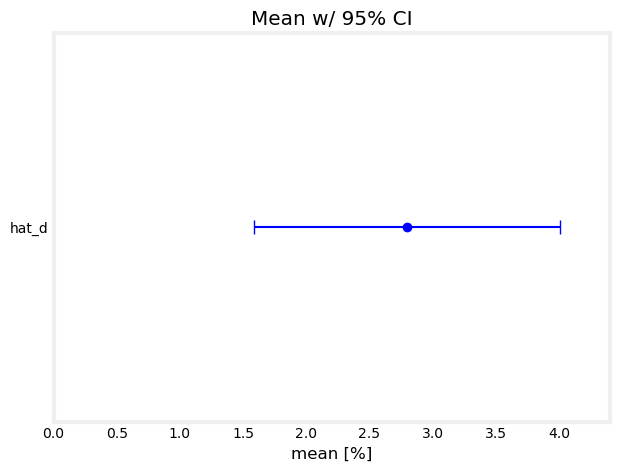

In [379]:
mean = d[0]*100
upper = d[1][1]*100
lower = d[1][0]*100
y_pos = 1    # vertical position
# compute asymmetric x errors
xerr = np.array([[mean - lower], [upper - mean]])  # shape [[left], [right]]
plt.errorbar(mean, y_pos, xerr=xerr, fmt='o', capsize=5, color='blue')
plt.yticks([y_pos], ["hat_d"])

plt.xlabel("mean [%]")
plt.title("Mean w/ 95% CI")
plt.xlim(min(lower - abs(lower)*0.1, 0), upper+abs(upper)*0.1)
plt.grid(False)
plt.show()

del mean, upper, lower

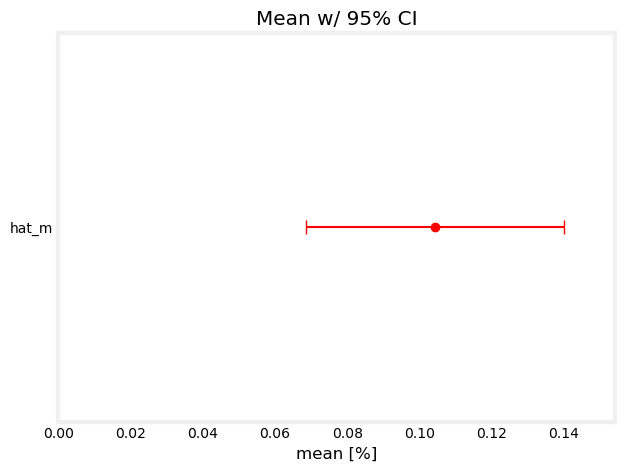

In [380]:
mean = m[0]*100
upper = m[1][1]*100
lower = m[1][0]*100
y_pos = 1    # vertical position
# compute asymmetric x errors
xerr = np.array([[mean - lower], [upper - mean]])  # shape [[left], [right]]
plt.errorbar(mean, y_pos, xerr=xerr, fmt='o', capsize=5, color='red')
plt.yticks([y_pos], ["hat_m"])

plt.xlabel("mean [%]")
plt.title("Mean w/ 95% CI")
plt.xlim(min(lower - abs(lower)*0.1, 0), upper+abs(upper)*0.1)
plt.grid(False)
plt.show()

del mean, upper, lower

In [381]:
d, m, df = ab_experiment(exper_binary_metric,
              exper_continuous_metric,
              full_data,
              largest_narm=True,
              alpha=0.05, power=0.9)

In [382]:
display(df)

user_id  rollout_group assign_date group        age age_cohort  \
0      760626              1  2025-09-03     A  50.807486      41-65   
1      382182              1  2025-09-03     A  75.300699        >65   
2      290257              1  2025-09-03     A  76.807371        >65   
3      737089              1  2025-09-03     A  87.092971        >65   
4      362296              1  2025-09-03     A  52.341119      41-65   
...       ...            ...         ...   ...        ...        ...   
9897   760490              4  2025-09-09     B  75.408418        >65   
9898   844319              4  2025-09-09     B  69.342395        >65   
9899   988816              4  2025-09-09     B  42.028653      41-65   
9900   954371              4  2025-09-09     B  48.410297      41-65   
9901   364032              4  2025-09-09     B  78.352513        >65   

             income income_cohort     net_worth networth_cohort  \
0     152898.084989        25-50%  4.352512e+05          25-50%   
1     999197.722991          >75%  4.833897e+06          50-75%   
2     180214.242015        25-50%  2.646060e+07            >75%   
3      57613.326760         0-25%  6.744081e+05          25-50%   
4     313756.115331        50-75%  1.727729e+07            >75%   
...             ...           ...           ...             ...   
9897  112769.375912        25-50%  2.073968e+07            >75%   
9898  154722.815183        25-50%  1.827660e+07            >75%   
9899   94059.359235         0-25%  4.627786e+05          25-50%   
9900  157043.010001        25-50%  6.031444e+05          25-50%   
9901  372834.910129        50-75%  2.643960e+07            >75%   

      retirement_balance balance_cohort  current_pct  employer_cap  \
0           4.129923e+05         25-50%         9.75          7.50   
1           2.113745e+06           >75%         4.00          6.75   
2           4.378884e+05         25-50%        10.00          6.00   
3           1.322783e+06         50-75%        13.00          6.25   
4           7.091134e+05         50-75%         8.00          6.75   
...                  ...            ...          ...           ...   
9897        5.275650e+06           >75%         5.50          2.50   
9898        1.536038e+06         50-75%         8.75          6.00   
9899        4.339875e+05         25-50%         9.25          6.75   
9900        2.155208e+05         25-50%         9.50         13.00   
9901        3.597985e+06           >75%        13.00          3.75   

      last_login  acct_tenure  time_online_frac  conv_rate  converted  \
0           35.0    10.548975             0.149   0.005312          0   
1            2.2     0.755936             0.114   0.006699          0   
2          107.5     2.271933             0.113   0.001613          0   
3           44.1     5.003151             0.103   0.000483          0   
4            8.8    13.280373             0.170   0.005889          0   
...          ...          ...               ...        ...        ...   
9897        25.5    20.344693             0.183   0.001847          0   
9898        53.4     3.436725             0.189   0.005474          0   
9899        16.6     7.591322             0.254   0.022109          0   
9900        46.9     6.322336             0.187   0.044394          0   
9901         2.7     3.989433             0.097   0.004631          0   

     conversion_date  delta_pct  new_pct  user_delta_aum  employer_delta_aum  \
0                NaT        0.0     9.75             0.0                 0.0   
1                NaT        0.0     4.00             0.0                 0.0   
2                NaT        0.0    10.00             0.0                 0.0   
3                NaT        0.0    13.00             0.0                 0.0   
4                NaT        0.0     8.00             0.0                 0.0   
...              ...        ...      ...             ...                 ...   
9897             NaT        0.0     5.50             0.0  

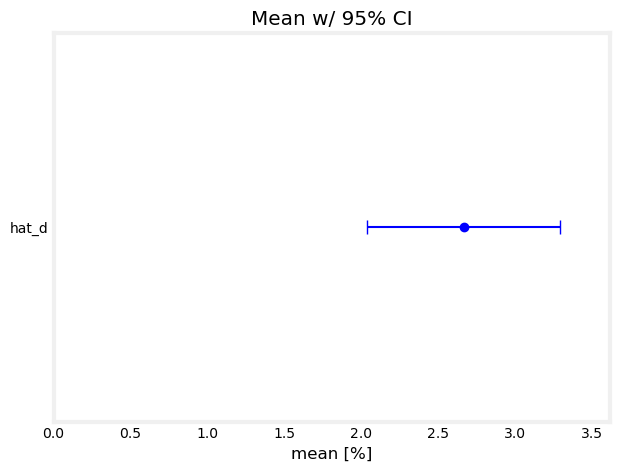

In [383]:
mean = d[0]*100
upper = d[1][1]*100
lower = d[1][0]*100
y_pos = 1    # vertical position
# compute asymmetric x errors
xerr = np.array([[mean - lower], [upper - mean]])  # shape [[left], [right]]
plt.errorbar(mean, y_pos, xerr=xerr, fmt='o', capsize=5, color='blue')
plt.yticks([y_pos], ["hat_d"])

plt.xlabel("mean [%]")
plt.title("Mean w/ 95% CI")
plt.xlim(min(lower - abs(lower)*0.1, 0), upper+abs(upper)*0.1)
plt.grid(False)
plt.show()

del mean, upper, lower

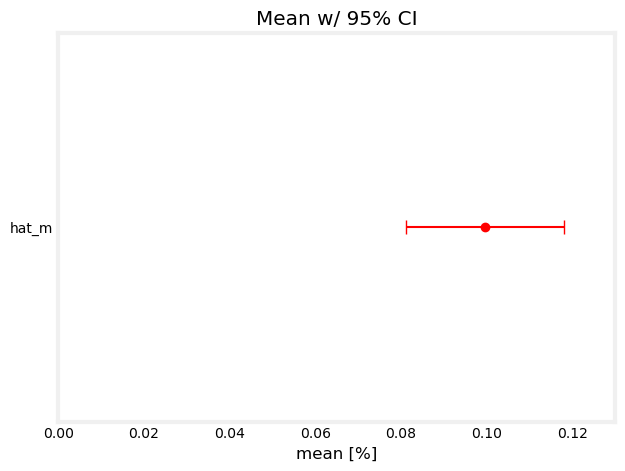

In [384]:
mean = m[0]*100
upper = m[1][1]*100
lower = m[1][0]*100
y_pos = 1    # vertical position
# compute asymmetric x errors
xerr = np.array([[mean - lower], [upper - mean]])  # shape [[left], [right]]
plt.errorbar(mean, y_pos, xerr=xerr, fmt='o', capsize=5, color='red')
plt.yticks([y_pos], ["hat_m"])

plt.xlabel("mean [%]")
plt.title("Mean w/ 95% CI")
plt.xlim(min(lower - abs(lower)*0.1, 0), upper+abs(upper)*0.1)
plt.grid(False)
plt.show()

del mean, upper, lower

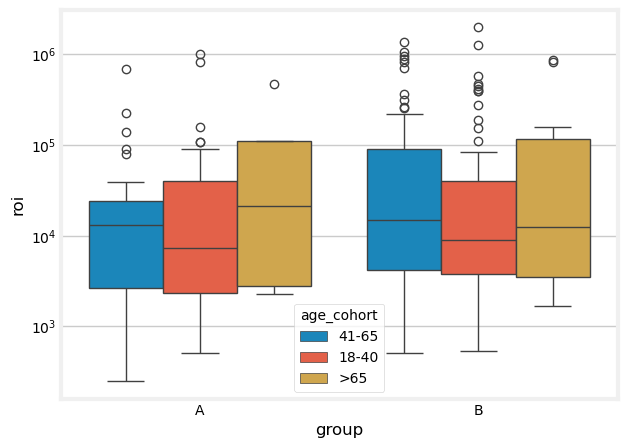

In [182]:
sns.boxplot(data=df[df['converted']==1], x='group', y='roi', hue='age_cohort', order=['A', 'B'])
plt.yscale('log')

/home/mbuenabad/miniforge3/envs/ml_env/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 37.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


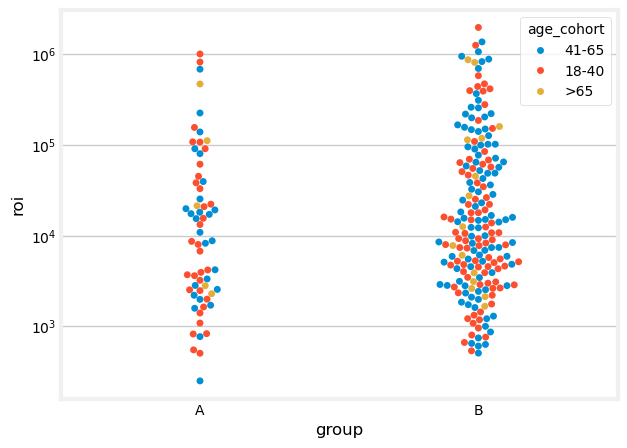

In [183]:
sns.swarmplot(data=df[df['converted']==1], x='group', y='roi', hue='age_cohort', order=['A', 'B'])
plt.yscale('log')

In [184]:
full_data.groupby('age_cohort')['user_id'].count()

age_cohort
18-40    17949
41-65    54441
>65      27544
Name: user_id, dtype: int64

In [185]:
(full_data.groupby('age_cohort')['user_id'].count()['18-40'] / full_data.groupby('age_cohort')['user_id'].count().sum())

np.float64(0.17960854163748075)

In [186]:
(full_data.groupby('age_cohort')['income'].median())['18-40']

np.float64(150240.39871436814)

In [187]:
df['roi'].sum()

np.float64(24606120.957020197)

In [188]:
df[df['converted']==1]['converted'].sum()

np.int64(258)

In [189]:
display(df[df['converted']==1].groupby(['group'])['roi'].sum())

display(df[df['converted']==1].groupby(['group', 'age_cohort'])['roi'].sum())

group
A    4.591138e+06
B    2.004178e+07
Name: roi, dtype: float64

group  age_cohort
A      18-40         2.564226e+06
       41-65         1.425623e+06
       >65           6.012896e+05
B      18-40         7.643824e+06
       41-65         1.023908e+07
       >65           2.158870e+06
Name: roi, dtype: float64

<Axes: xlabel='group', ylabel='delta_pct'>

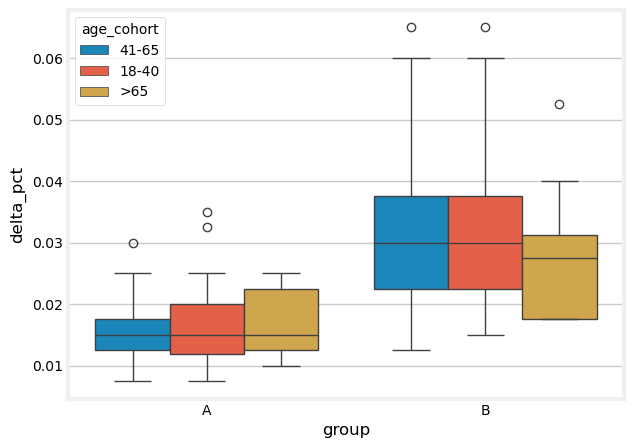

In [190]:
sns.boxplot(data=df[df['converted']==1], x='group', y='delta_pct', hue='age_cohort')

<Axes: xlabel='group', ylabel='delta_pct'>

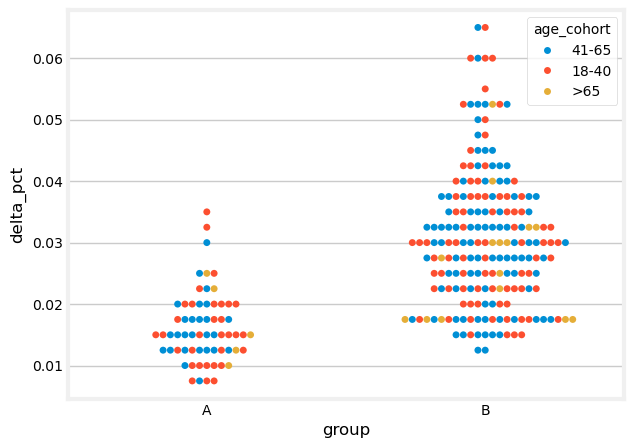

In [191]:
sns.swarmplot(data=df[df['converted']==1], x='group', y='delta_pct', hue='age_cohort')

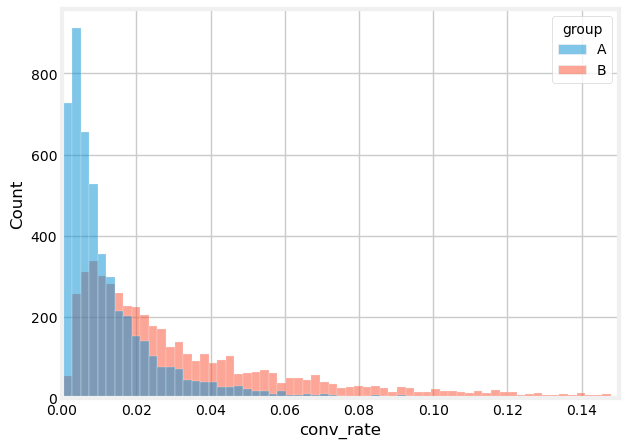

In [192]:
sns.histplot(data=df, x='conv_rate', hue='group')
plt.xlim(0, 0.15);

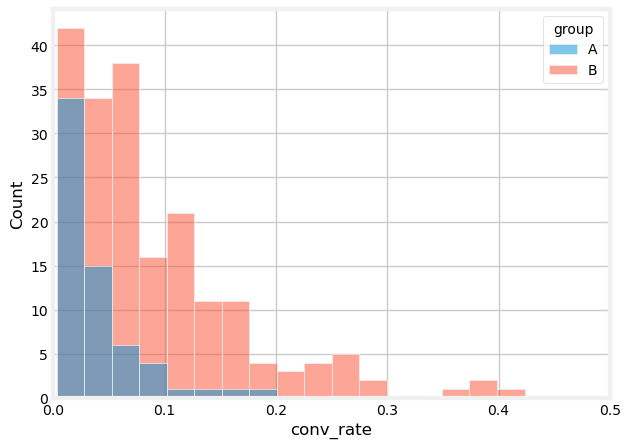

In [193]:
sns.histplot(data=df[df['converted']==1], x='conv_rate', hue='group')
plt.xlim(0, 0.5);

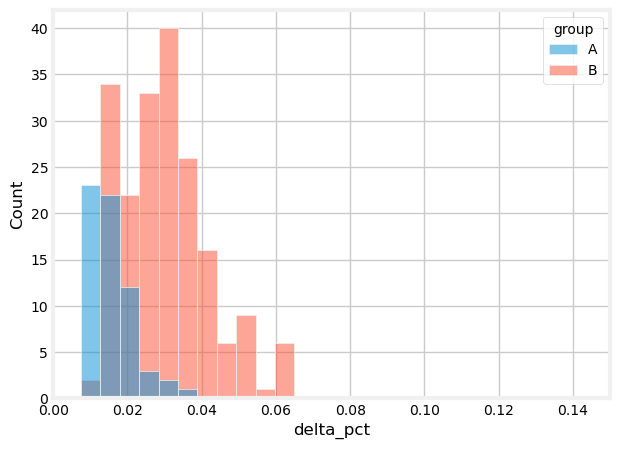

In [194]:
sns.histplot(data=df[df['converted']==1], x='delta_pct', hue='group')
plt.xlim(0, 0.15);

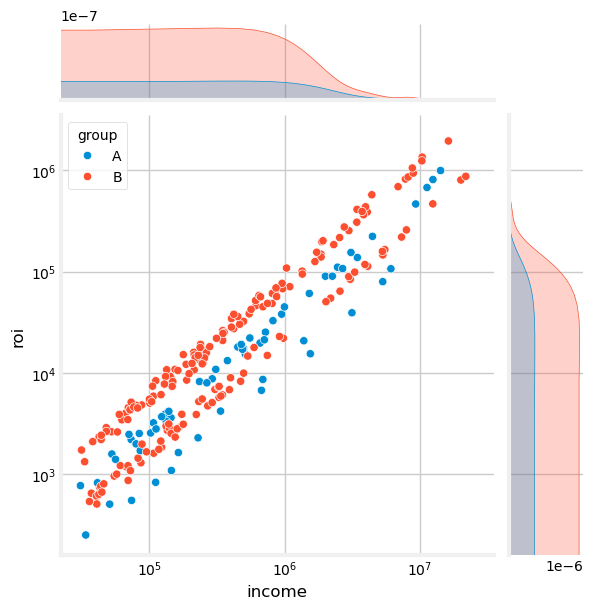

In [195]:
sns.jointplot(data=df[df['converted']==1], x='income', y='roi', hue='group')
plt.yscale('log');
plt.xscale('log');

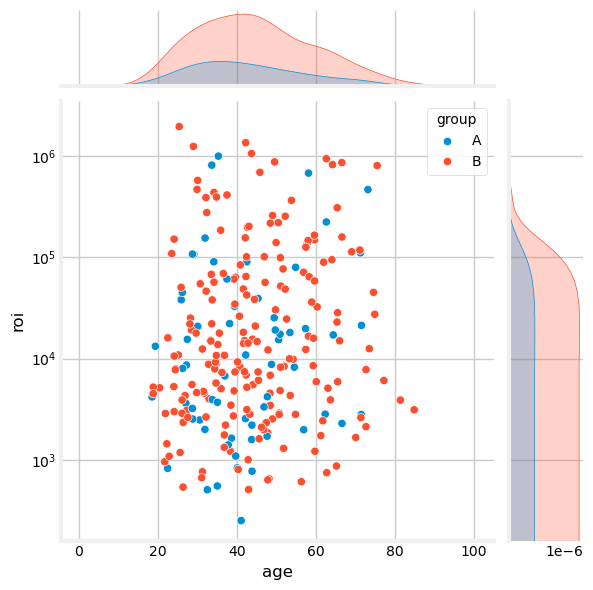

In [196]:
sns.jointplot(data=df[df['converted']==1], x='age', y='roi', hue='group')
plt.yscale('log');

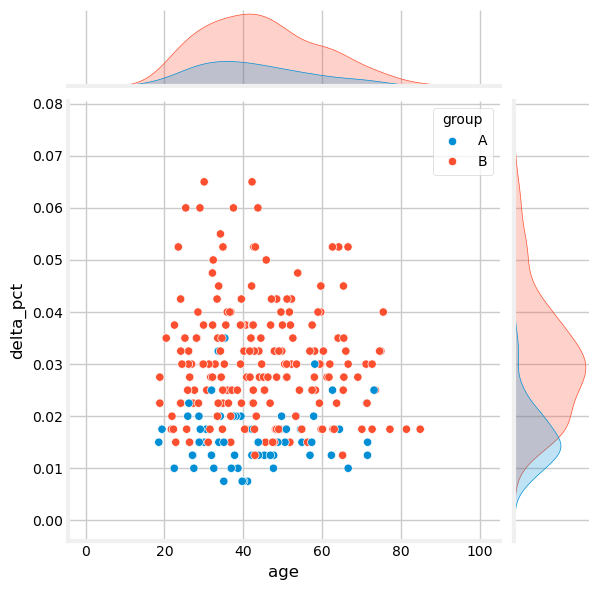

In [197]:
sns.jointplot(data=df[df['converted']==1], x='age', y='delta_pct', hue='group')

### Cleanup

In [200]:
Out.clear()

for name in dir():
    if name.startswith('_') and name[1:].isdigit():
        del globals()[name]

del name, d, m, df

## 4. Analysis

### Monitoring

Some simple plots of what monitoring could look like:

In [202]:
num = 1
num = str(num).zfill(2)
file_name = f"experiment_no-{num}.csv"

df = pd.read_csv(output_data_dir+file_name, index_col=0)

#### Age Buckets

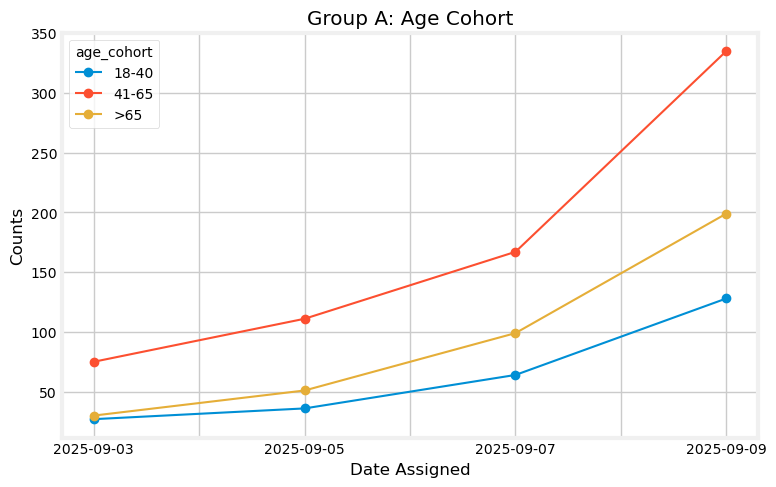

In [225]:
# computing buckets as a function of time

age_evolution = df[df['group'] == 'A'].groupby(['assign_date', 'age_cohort'])['user_id'].count()

age_evolution = age_evolution.unstack()
age_evolution.plot(figsize=(8,5), marker='o')
plt.xlabel("Date Assigned")
plt.ylabel("Counts")
plt.title("Group A: Age Cohort")
plt.grid(True)
plt.show()

del age_evolution

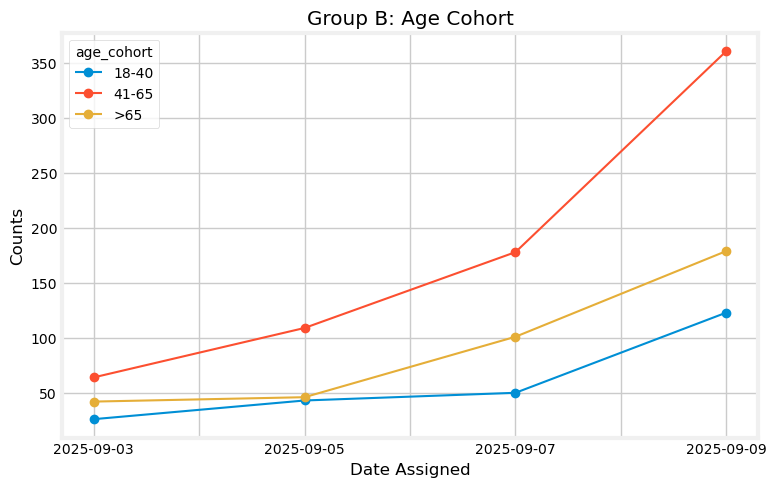

In [226]:
# computing buckets as a function of time

age_evolution = df[df['group'] == 'B'].groupby(['assign_date', 'age_cohort'])['user_id'].count()

age_evolution = age_evolution.unstack()
age_evolution.plot(figsize=(8,5), marker='o')
plt.xlabel("Date Assigned")
plt.ylabel("Counts")
plt.title("Group B: Age Cohort")
plt.grid(True)
plt.show()

del age_evolution

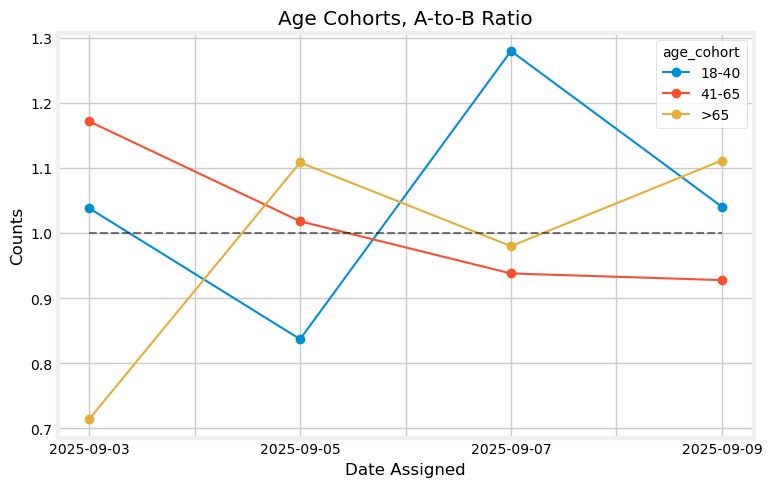

In [227]:
# computing buckets as a function of time

age_evolution = df[df['group'] == 'A'].groupby(['assign_date', 'age_cohort'])['user_id'].count() / df[df['group'] == 'B'].groupby(['assign_date', 'age_cohort'])['user_id'].count()

age_evolution = age_evolution.unstack()

age_evolution.plot(figsize=(8,5), marker='o')

plt.plot(age_evolution.index, np.ones_like(age_evolution.index), color='k', ls='--', alpha=0.5)

plt.xlabel("Date Assigned")
plt.ylabel("Counts")
plt.title("Age Cohorts, A-to-B Ratio")
plt.grid(True)
plt.show()

del age_evolution

#### Income Buckets

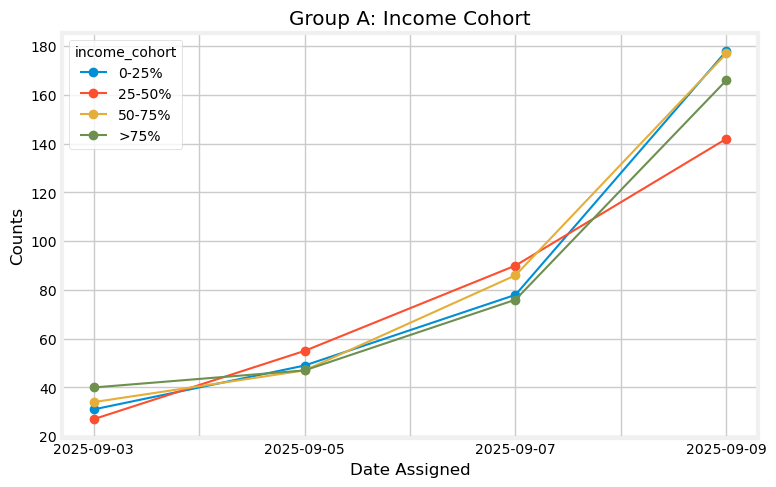

In [229]:
# computing buckets as a function of time

income_evolution = df[df['group'] == 'A'].groupby(['assign_date', 'income_cohort'])['user_id'].count()

income_evolution = income_evolution.unstack()
income_evolution.plot(figsize=(8,5), marker='o')
plt.xlabel("Date Assigned")
plt.ylabel("Counts")
plt.title("Group A: Income Cohort")
plt.grid(True)
plt.show()

del income_evolution

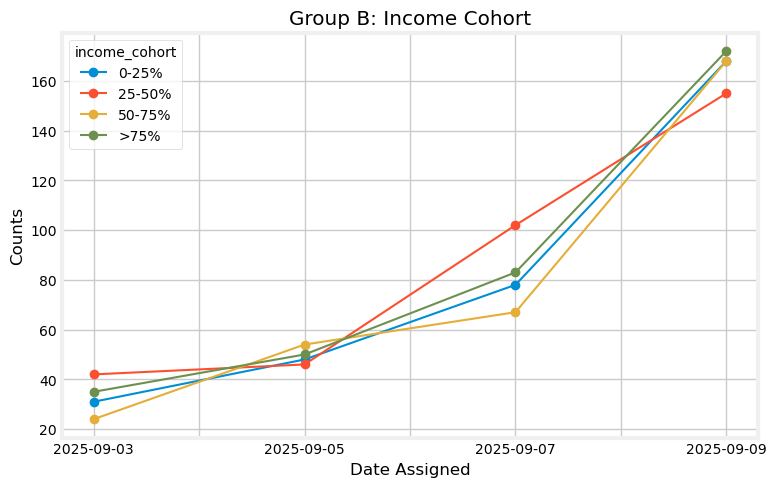

In [230]:
# computing buckets as a function of time

income_evolution = df[df['group'] == 'B'].groupby(['assign_date', 'income_cohort'])['user_id'].count()

income_evolution = income_evolution.unstack()
income_evolution.plot(figsize=(8,5), marker='o')
plt.xlabel("Date Assigned")
plt.ylabel("Counts")
plt.title("Group B: Income Cohort")
plt.grid(True)
plt.show()

del income_evolution

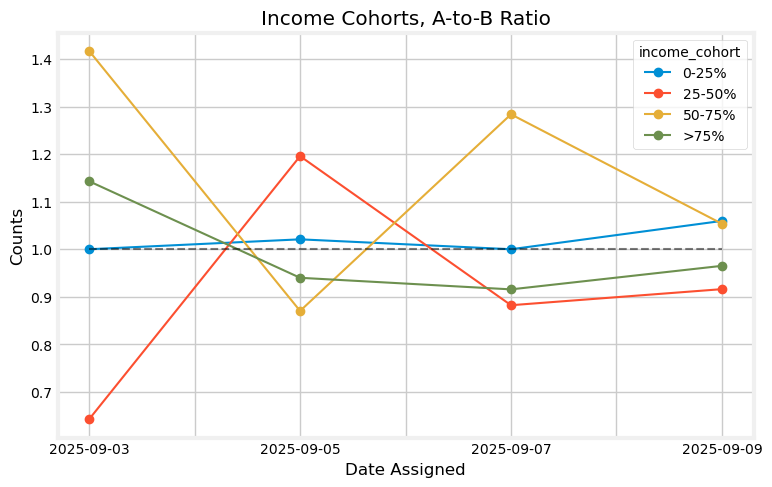

In [231]:
# computing buckets as a function of time

income_evolution = df[df['group'] == 'A'].groupby(['assign_date', 'income_cohort'])['user_id'].count() / df[df['group'] == 'B'].groupby(['assign_date', 'income_cohort'])['user_id'].count()

income_evolution = income_evolution.unstack()

income_evolution.plot(figsize=(8,5), marker='o')

plt.plot(income_evolution.index, np.ones_like(income_evolution.index), color='k', ls='--', alpha=0.5)

plt.xlabel("Date Assigned")
plt.ylabel("Counts")
plt.title("Income Cohorts, A-to-B Ratio")
plt.grid(True)
plt.show()

del income_evolution

#### Balance Buckets

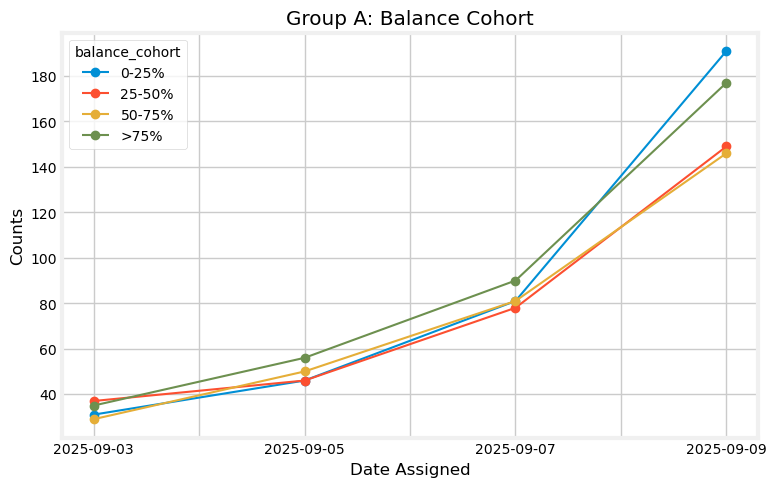

In [232]:
# computing buckets as a function of time

balance_evolution = df[df['group'] == 'A'].groupby(['assign_date', 'balance_cohort'])['user_id'].count()

balance_evolution = balance_evolution.unstack()
balance_evolution.plot(figsize=(8,5), marker='o')
plt.xlabel("Date Assigned")
plt.ylabel("Counts")
plt.title("Group A: Balance Cohort")
plt.grid(True)
plt.show()

del balance_evolution

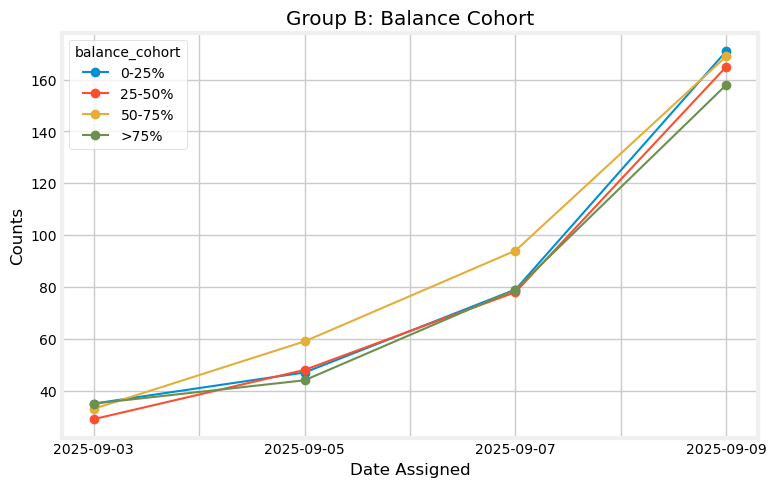

In [233]:
# computing buckets as a function of time

balance_evolution = df[df['group'] == 'B'].groupby(['assign_date', 'balance_cohort'])['user_id'].count()

balance_evolution = balance_evolution.unstack()
balance_evolution.plot(figsize=(8,5), marker='o')
plt.xlabel("Date Assigned")
plt.ylabel("Counts")
plt.title("Group B: Balance Cohort")
plt.grid(True)
plt.show()

del balance_evolution

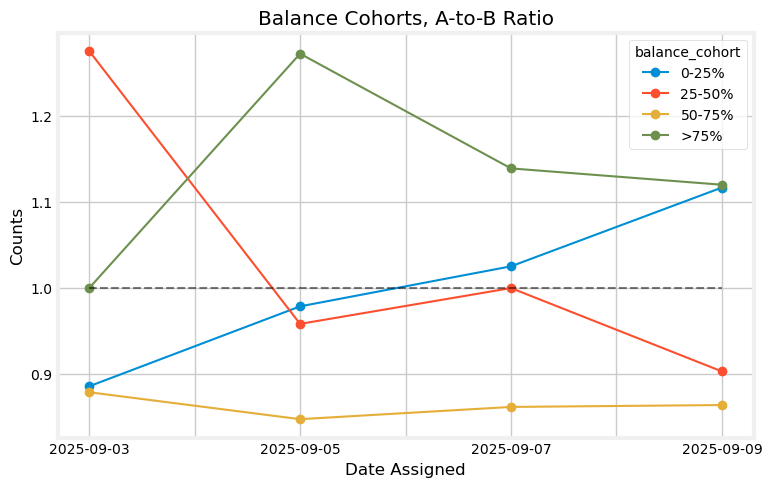

In [235]:
# computing buckets as a function of time

balance_evolution = df[df['group'] == 'A'].groupby(['assign_date', 'balance_cohort'])['user_id'].count() / df[df['group'] == 'B'].groupby(['assign_date', 'balance_cohort'])['user_id'].count()

balance_evolution = balance_evolution.unstack()

balance_evolution.plot(figsize=(8,5), marker='o')

plt.plot(balance_evolution.index, np.ones_like(balance_evolution.index), color='k', ls='--', alpha=0.5)

plt.xlabel("Date Assigned")
plt.ylabel("Counts")
plt.title("Balance Cohorts, A-to-B Ratio")
plt.grid(True)
plt.show()

del balance_evolution

#### Proportions

In [314]:
def props_time_fn(group, data):

    df = data.copy()
    df = df[df['group'] == group]

    conversion_dates = sorted(list(df[df['conversion_date'].isna() == False]['conversion_date'].sort_values().unique()) + list(df['assign_date'].unique()))
    conversion_dates = np.unique(conversion_dates)
    conversion_dates = pd.date_range(pd.to_datetime(conversion_dates[0]),
                                     pd.to_datetime(conversion_dates[-1]),
                                     freq='d')
    conversion_dates = conversion_dates.astype(str)

    counts = df.groupby(['assign_date','rollout_group']).size().unstack(fill_value=0).sum(axis=1)
    counts = counts.reindex(conversion_dates, fill_value=0)
    counts = counts.cumsum()

    conversions = df.groupby('conversion_date')['converted'].sum()
    conversions = conversions.reindex(conversion_dates, fill_value=0)
    conversions = conversions.cumsum()

    props_time = conversions/counts

    return props_time

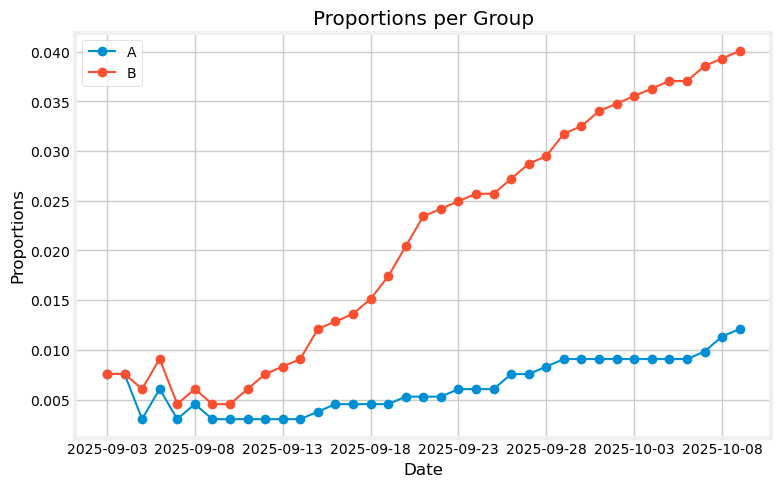

In [323]:
props_time_fn('A', df).plot(figsize=(8,5), marker='o', label='A')
props_time_fn('B', df).plot(figsize=(8,5), marker='o', label='B')

plt.xlabel("Date")
plt.ylabel("Proportions")
plt.title("Proportions per Group")
plt.legend()
plt.grid(True)
plt.show()

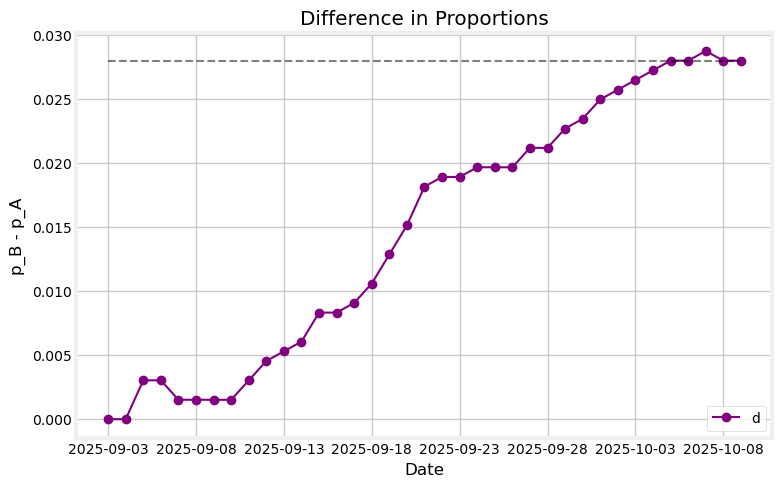

In [333]:
diffs = (props_time_fn('B', df)-props_time_fn('A', df))
diffs.plot(figsize=(8,5), marker='o', label=r'd', color='purple')

refs = pd.Series(diffs.iloc[-1], index=props_time_fn('B', df).index)
refs.plot(figsize=(8,5), color='k', ls='--', alpha=0.5)

plt.xlabel("Date")
plt.ylabel("p_B - p_A")
plt.title("Difference in Proportions")
plt.legend()
plt.grid(True)
plt.show()

del diffs, refs

In [ ]:
# computing proportions as a function of time

monitor_Aprops = df.groupby(['conversion_date', 'group']).sum()

monitor_Bprops = df[df['group'] == 'B'].groupby('conversion_date')['converted'].mean()

#### Contribution Growth

In [339]:
def means_time_fn(group, data):

    df = data.copy()
    df = df[df['group'] == group]

    conversion_dates = sorted(list(df[df['conversion_date'].isna() == False]['conversion_date'].sort_values().unique()) + list(df['assign_date'].unique()))
    conversion_dates = np.unique(conversion_dates)
    conversion_dates = pd.date_range(pd.to_datetime(conversion_dates[0]),
                                     pd.to_datetime(conversion_dates[-1]),
                                     freq='d')
    conversion_dates = conversion_dates.astype(str)

    counts = df.groupby(['assign_date','rollout_group']).size().unstack(fill_value=0).sum(axis=1)
    counts = counts.reindex(conversion_dates, fill_value=0)
    counts = counts.cumsum()

    deltas = df.groupby('conversion_date')['delta_pct'].sum()
    deltas = deltas.reindex(conversion_dates, fill_value=0)
    deltas = deltas.cumsum()

    means_time = deltas/counts

    return means_time

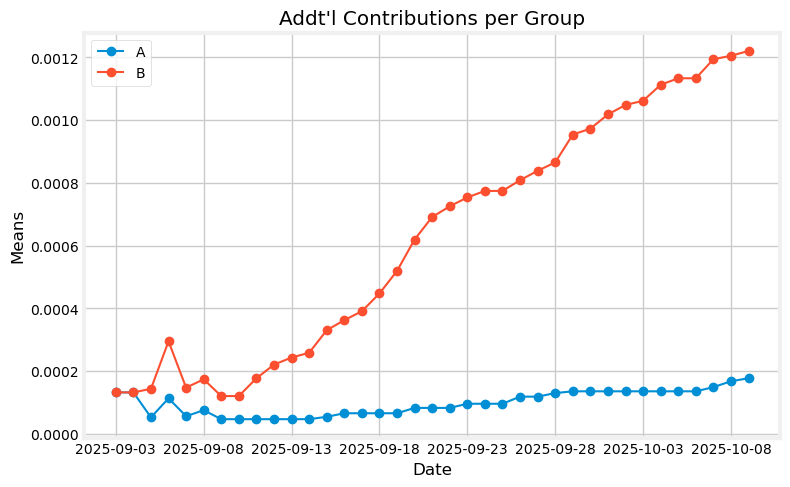

In [340]:
means_time_fn('A', df).plot(figsize=(8,5), marker='o', label='A')
means_time_fn('B', df).plot(figsize=(8,5), marker='o', label='B')

plt.xlabel("Date")
plt.ylabel("Means")
plt.title("Addt'l Contributions per Group")
plt.legend()
plt.grid(True)
plt.show()

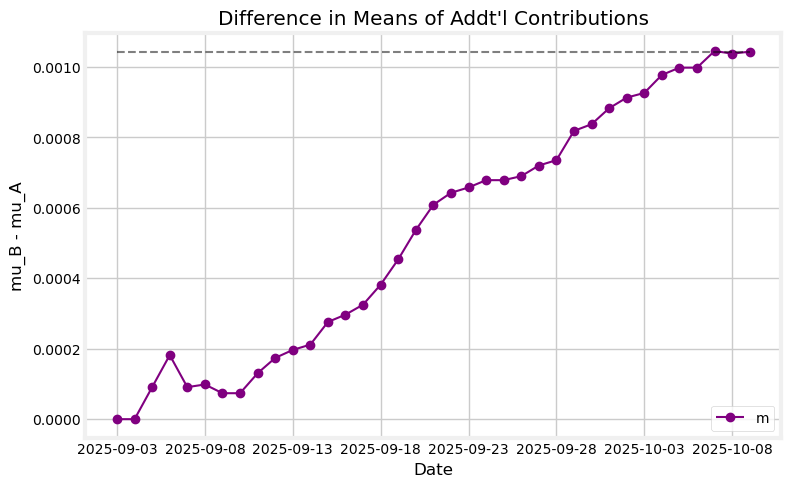

In [344]:
diffs = (means_time_fn('B', df)-means_time_fn('A', df))
diffs.plot(figsize=(8,5), marker='o', label=r'm', color='purple')

refs = pd.Series(diffs.iloc[-1], index=means_time_fn('B', df).index)
refs.plot(figsize=(8,5), color='k', ls='--', alpha=0.5)

plt.xlabel("Date")
plt.ylabel("mu_B - mu_A")
plt.title("Difference in Means of Addt'l Contributions")
plt.legend()
plt.grid(True)
plt.show()

del diffs, refs

### HTE

#### ANOVA

#### Meta-learners

## IGNORE FROM HERE: NOTES

**TODO:**
- chi2/Cramer's V analysis of Yes/Nos in Income/Balance and Age Batches?
- leave "powering" groups/strata for another time; just do exploratory

In [ ]:
# 1. Generate user covariates (N users)
N = 10000
age ~ Normal(45, 12) clipped to [18,75]
income ~ LogNormal(mean=10.5, sigma=0.7)   # annual income
balance ~ LogNormal(mean=10.0, sigma=1.0)  # retirement balance proxy
current_pct ~ Beta(a=2, b=20) * 0.2         # current contribution pct (0-20%)
last_login_days ~ Exponential(1/30)        # recency in days
segment = categorical by age/income (e.g., young/low-income / old/high-income)

# 2. Randomize treatment
treatment = Bernoulli(0.5)  # simple randomized A/B

# 3. Baseline probability of increasing contribution (p0) as logistic of covariates
logit_p0 = -3.0 
         + 0.01*(income/1000) 
         + 0.5*(current_pct < 0.05) 
         - 0.01*(age-45) 
         - 0.005*(balance/1000)
p0 = logistic(logit_p0)

# 4. Treatment effect heterogeneity (delta)
# Example: younger & lower-balance users respond more to default nudge
treatment_effect = 0.03 \
                   + 0.02*(age<35) \
                   + 0.03*(current_pct < 0.02) \
                   - 0.01*(balance > 100000)

# 5. Final outcome: Bernoulli(p = p0 + treatment*treatment_effect)
p = clip(p0 + treatment * treatment_effect, 0, 1)
converted = Bernoulli(p)

# 6. Continuous outcome: delta_pct (if converted) ~ Normal(mu = 0.5 * treatment + covariate effects, sigma=0.5)


In [ ]:
# Nudge-to-Save simulation (runnable)
import numpy as np
import pandas as pd
from scipy.special import expit as logistic  # logistic(x) = 1 / (1+exp(-x))
np.random.seed(42)

def simulate_nudge_data(N=20000, treatment_rate=0.5,
                        base_conversion=0.10,  # baseline prob scale (for reference)
                        avg_balance=100_000):
    """
    Returns a DataFrame with:
      user_id, age, income, balance, current_pct, last_login_days, segment,
      treatment (0/1), p0 (baseline conv prob), tau (treatment effect),
      p_final, converted (0/1), delta_pct (if converted)
    """
    # --- 1. Covariates ---
    age = np.clip(np.random.normal(loc=45, scale=12, size=N).astype(int), 18, 90)
    # income as lognormal; adjust mean to get plausible US incomes
    income = np.random.lognormal(mean=10.5, sigma=0.8, size=N)  # ~exp(10.5) ~ 36k *but lognormal shape matters
    # balances skewed
    balance = np.random.lognormal(mean=np.log(avg_balance), sigma=1.0, size=N)
    # current contribution pct (0-0.3)
    current_pct = np.clip(np.random.beta(a=2, b=18, size=N) * 0.25, 0.0, 0.30)
    last_login_days = np.random.exponential(scale=30, size=N)  # recency
    # simple segment (young/low vs old/high)
    segment = np.where((age < 35) & (income < np.percentile(income, 40)), 'young_low', 'other')

    # --- 2. Randomize treatment (A/B) ---
    treat = np.random.binomial(1, treatment_rate, size=N)

    # --- 3. Baseline logit for conversion (increase contribution within 30d) ---
    # We choose coefficients so baseline probability approx 8-12%
    # logit_p0 = intercept + coef * features
    intercept = -3.0
    coef_income = 0.00002    # small positive with income
    coef_currentpct = -5.0   # those already contributing more are less likely to increase
    coef_recency = -0.01     # more recent login -> more likely to respond (negative sign because last_login_days larger = less likely)
    coef_age = -0.01
    coef_balance = -0.000002

    logit_p0 = (intercept
                + coef_income * income
                + coef_currentpct * current_pct
                + coef_recency * last_login_days
                + coef_age * (age - 45)
                + coef_balance * (balance - avg_balance))
    p0 = logistic(logit_p0)  # baseline prob vector

    # --- 4. Treatment effect heterogeneity (tau) on probability scale (additive in prob) ---
    # We'll model tau on the logit scale (so multiplicative-ish) or additive — here additive on logit:
    tau_base = 0.25  # roughly translates to ~+2-5 percentage points depending on p0
    tau_age_factor = -0.005 * (age - 45)       # younger more responsive
    tau_currentpct = -1.5 * np.where(current_pct > 0.05, 1, 0)  # those already at >5% less uplift
    tau_balance = -0.0000008 * (balance - avg_balance)          # rich clients somewhat less sensitive
    logit_tau = tau_base + tau_age_factor + tau_currentpct + tau_balance

    # --- 5. Final probability and outcome ---
    logit_post = logit_p0 + treat * logit_tau
    p_final = logistic(logit_post)
    converted = np.random.binomial(1, p_final)

    # Continuous delta_pct: magnitude of change if converted (in percent points)
    mu_delta = 0.5 + 0.2 * treat - 0.1 * (current_pct > 0.05)  # pct points
    delta_pct = np.where(converted == 1, np.random.normal(loc=mu_delta, scale=0.5, size=N), 0.0)
    delta_pct = np.clip(delta_pct, 0.0, 10.0)  # can't go negative in our sim

    df = pd.DataFrame({
        'user_id': np.arange(N),
        'age': age,
        'income': income,
        'balance': balance,
        'current_pct': current_pct,
        'last_login_days': last_login_days,
        'segment': segment,
        'treatment': treat,
        'p0': p0,
        'logit_tau': logit_tau,
        'p_final': p_final,
        'converted': converted,
        'delta_pct': delta_pct
    })
    return df

# Example usage:
# df = simulate_nudge_data(N=20000)
# df.to_csv("nudge_sim.csv", index=False)


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
# X = covariates
X = df[['age','income','balance','current_pct','last_login_days']]
T = df['treatment']
y = df['converted']

model = GradientBoostingClassifier()
model.fit(np.hstack([X, T.reshape(-1,1)]), y)

# predictions
X_t1 = np.hstack([X, np.ones((X.shape[0],1))])
X_t0 = np.hstack([X, np.zeros((X.shape[0],1))])
pred_t1 = model.predict_proba(X_t1)[:,1]
pred_t0 = model.predict_proba(X_t0)[:,1]
uplift = pred_t1 - pred_t0


In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# simulate arrival timestamps over 30 days
start = datetime(2025,8,1)
N = len(df)
days = 30
df['assigned_at'] = [start + timedelta(days=int(x)) for x in np.random.uniform(0, days, size=N)]

# simulate treatment_sent at assigned_at + small jitter
df['treatment_sent'] = True  # or Bernoulli for delivery failures
df['treatment_received_at'] = df['assigned_at'] + pd.to_timedelta(np.random.exponential(scale=0.5, size=N), unit='D')

# simulate conversion timestamps if converted
df.loc[df.converted==1, 'conversion_at'] = df.loc[df.converted==1, 'assigned_at'] + pd.to_timedelta(np.random.exponential(scale=5, size=df.converted.sum()), unit='D')
